In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import loguniform
from sklearn.impute import SimpleImputer
from sklearn.cross_decomposition import PLSRegression
import shap

In [2]:
Clinical_Contineous_data = ['Baseline FVC Volume L', 'Age',
                            'FEV1 Volume L'
        ]

Clinical_Categorical_data = [
       'Primary Diagnosis_CHP', 'Primary Diagnosis_CTD-ILD',
       'Primary Diagnosis_Emphysema', 'Primary Diagnosis_Exposure-related',
       'Primary Diagnosis_Fibrotic HP (FHP)', 'Primary Diagnosis_INSIP',
       'Primary Diagnosis_IPF', 'Primary Diagnosis_Idiopathic OP',
       'Primary Diagnosis_Idiopathic pleuroparenchymal fibroelastosis (IPPFE)',
       'Primary Diagnosis_Miscellaneous', 'Primary Diagnosis_NSIP',
       'Primary Diagnosis_No information',
       'Primary Diagnosis_Occupational-related ILD',
       'Primary Diagnosis_Sarcoidosis',
       'Primary Diagnosis_Smoking Related ILD (DIP / RB / RB-ILD)',
       'Primary Diagnosis_UILD', 'Sex_Female', 'Sex_Male',
       'Smoking History_Active Smoker', 'Smoking History_Ex Smoker',
       'Smoking History_Never Smoker', 'Smoking History_No Knowledge'
       ]

#Clinical_Categorical_data = ['Sex_Male', 'Primary Diagnosis_CTD-ILD', 'Primary Diagnosis_Exposure-related', 'Primary Diagnosis_Fibrotic HP (FHP)', 'Primary Diagnosis_INSIP', 'Primary Diagnosis_IPF', 'Primary Diagnosis_Idiopathic OP', 'Primary Diagnosis_Miscellaneous', 'Primary Diagnosis_No information', 'Primary Diagnosis_Occupational-related ILD', 'Primary Diagnosis_Other', 'Primary Diagnosis_Sarcoidosis', 'Primary Diagnosis_Smoking Related ILD (DIP / RB / RB-ILD)', 'Primary Diagnosis_UILD', 'Smoking History_Ex Smoker', 'Smoking History_Never Smoker', 'Smoking History_No Knowledge']


In [3]:
def train_and_evaluate_pls(X_train, X_test, y_train, y_test,
                           feature_list, numeric_features, onehot_features,
                           model_name="pls_regression_pipeline.pkl"):

    print("Numeric features:", numeric_features)
    print("One-hot features:", onehot_features)
    print("number of features given as input:", len(numeric_features) + len(onehot_features))

    # ------------------------------
    # Preprocessor
    # ------------------------------
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("onehot", "passthrough", onehot_features)
        ]
    )

    # ------------------------------
    # Base PLS model
    # ------------------------------
    from sklearn.cross_decomposition import PLSRegression
    from sklearn.model_selection import GridSearchCV, RepeatedKFold

    rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
    n_components_grid = list(range(2, min(len(numeric_features) + len(onehot_features), 30)))

    pipeline = Pipeline([
        ("scaler", preprocessor),
        ("pls", PLSRegression(scale=False))
    ])

    # ------------------------------
    # Hyperparameter tuning
    # ------------------------------
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid={"pls__n_components": n_components_grid},
        cv=rkf,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print("\nBest hyperparameters found:")
    print(grid_search.best_params_)

    # ------------------------------
    # Extract CV results
    # ------------------------------
    cv_results = pd.DataFrame(grid_search.cv_results_)
    print("\nRepeated 5-Fold CV Results (PLS):")
    print(cv_results[["param_pls__n_components", "mean_test_score", "std_test_score"]])

    # ------------------------------
    # Compute CV MAE, RMSE, R2 manually
    # ------------------------------
    cv_mae_list, cv_mse_list, cv_rmse_list, cv_r2_list = [], [], [], []

    for train_idx, val_idx in rkf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit best model on this fold
        fold_model = Pipeline([
            ("scaler", preprocessor),
            ("pls", PLSRegression(n_components=grid_search.best_params_["pls__n_components"], scale=False))
        ])

        fold_model.fit(X_tr, y_tr)
        y_val_pred = fold_model.predict(X_val).ravel()

        cv_mae_list.append(mean_absolute_error(y_val, y_val_pred))
        cv_mse_list.append(mean_squared_error(y_val, y_val_pred))
        cv_rmse_list.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
        cv_r2_list.append(r2_score(y_val, y_val_pred))

    cv_results1 = pd.DataFrame({
        "MAE": cv_mae_list,
        "MSE": cv_mse_list,
        "RMSE": cv_rmse_list,
        "R2": cv_r2_list
    })

    print(f"MAE: {cv_mae_list}")
    print(f"MSE: {cv_mse_list}")
    # Convert each np.float64 to a normal float
    rmse = [float(x) for x in cv_rmse_list]
    print(f"RMSE: {rmse}")
    print(f"R2: {cv_r2_list}")
    print(cv_results1)

    print("\nCross‑Validation Performance (Averaged Across Folds):")
    print(f"CV MAE:  {np.mean(cv_mae_list):.4f}")
    print(f"CV MSE: {np.mean(cv_mse_list):.4f}")
    print(f"CV RMSE: {np.mean(cv_rmse_list):.4f}")
    print(f"CV R²:   {np.mean(cv_r2_list):.4f}")

    # ------------------------------ # Plot MSE vs n_components # ------------------------------ 
    cv_results = pd.DataFrame(grid_search.cv_results_) 
    n_components = cv_results["param_pls__n_components"].astype(int) 
    mse_mean = -cv_results["mean_test_score"] 
    mse_std = cv_results["std_test_score"] 
    best_ncomp = grid_search.best_params_["pls__n_components"] 
    plt.figure(figsize=(8, 6)) 
    plt.errorbar( n_components, mse_mean, yerr=mse_std, fmt='o-', color='blue', ecolor='lightgray', capsize=4, label="MSE ± std" ) 
    plt.axvline(best_ncomp, color="red", linestyle="--", label=f"Best n_components = {best_ncomp}") 
    plt.xlabel("Number of PLS Components") 
    plt.ylabel("Mean Squared Error") 
    plt.title("PLS Regression: MSE vs Number of Components") 
    plt.grid(True) 
    plt.legend() 
    plt.tight_layout() 
    plt.show()

    # ------------------------------
    # Fit final model
    # ------------------------------
    best_pipeline = grid_search.best_estimator_
    y_test_pred = best_pipeline.predict(X_test).ravel()

    best_ncomp = grid_search.best_params_["pls__n_components"]
    print(f"\nBest number of PLS components: {best_ncomp}")

    # ------------------------------
    # Test performance
    # ------------------------------
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)

    print("\nTest set performance (PLS):")
    print(f"- MAE:  {test_mae:.2f} L")
    print(f"- MSE:  {test_mse:.2f} L²")
    print(f"- RMSE: {test_rmse:.2f} L")
    print(f"- R²:   {test_r2:.3f}")

    # ------------------------------
    # Training set performance
    # ------------------------------
    y_train_pred = best_pipeline.predict(X_train).ravel()
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, y_train_pred)

    print("\nTraining set performance (PLS):")
    print(f"- MAE:  {train_mae:.2f} L")
    print(f"- MSE:  {train_mse:.2f} L²")
    print(f"- RMSE: {train_rmse:.2f} L")
    print(f"- R²:   {train_r2:.3f}")

    # ------------------------------
    # Inspect coefficients
    # ------------------------------
    coefs = best_pipeline.named_steps["pls"].coef_.ravel()
    feature_names = best_pipeline.named_steps["scaler"].get_feature_names_out()
    clean_feature_names = [name.split("__")[-1] for name in feature_names]

    coef_df = pd.DataFrame({
        "Feature": clean_feature_names,
        "Coefficient": coefs,
        "AbsCoefficient": np.abs(coefs)
    }).sort_values(by="AbsCoefficient", ascending=False)

    print("\nPLS coefficients (sorted by |coef|):")
    print(coef_df[["Feature", "Coefficient"]])

    # ------------------------------
    # Save model
    # ------------------------------
    joblib.dump(best_pipeline, model_name)

    # ------------------------------
    # Predicted vs Actual Plot
    # ------------------------------
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             color="red", linestyle="--", label="Perfect Prediction")
    plt.xlabel("Actual Values (L)")
    plt.ylabel("Predicted Values (L)")
    plt.title("PLS Regression: Predicted vs Actual (Test Set)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ------------------------------
    # Worst 5 patients (largest errors)
    # ------------------------------
    errors = np.abs(y_test - y_test_pred)
    error_df = pd.DataFrame({
        "Baseline_FVC": X_test["Baseline FVC Volume L"].values if "Baseline FVC Volume L" in X_test.columns else np.nan,
        "Target_FVC": y_test.values,
        "Predicted_FVC": y_test_pred,
        "Abs_Error": errors,
        "Baseline_FVC_Week": X_test["Baseline FVC Week"].values if "Baseline FVC Week" in X_test.columns else np.nan,
        "Followup_FVC_Week": X_test["Followup FVC Week"].values if "Followup FVC Week" in X_test.columns else np.nan,
    })

    worst5 = error_df.sort_values(by="Abs_Error", ascending=False).head(5)
    print("\nTop 5 patients with largest errors:")
    print(worst5)

    for idx, row in worst5.iterrows():
        patient_df = pd.DataFrame({
            "Week": [row["Baseline_FVC_Week"], row["Followup_FVC_Week"]],
            "Actual_FVC": [row["Baseline_FVC"], row["Target_FVC"]],
            "Predicted_FVC": [row["Baseline_FVC"], row["Predicted_FVC"]]
        })
        plot_df = patient_df.melt(id_vars="Week",
                                  value_vars=["Actual_FVC", "Predicted_FVC"],
                                  var_name="Type", value_name="FVC")
        plt.figure(figsize=(7, 5))
        sns.lineplot(data=plot_df, x="Week", y="FVC", hue="Type", marker="o")
        plt.title(f"Patient {idx}: Actual vs Predicted FVC (Worst Error)")
        plt.xlabel("Week")
        plt.ylabel("FVC (Liters)")
        plt.tight_layout()
        plt.show()

    # ------------------------------
    # Best 5 patients (increasing FVC + lowest error)
    # ------------------------------
    increasing = error_df["Target_FVC"] > error_df["Baseline_FVC"]
    best_patients = error_df[increasing].sort_values(by="Abs_Error", ascending=True).head(5)

    print("\nTop 5 patients with increasing FVC and lowest error:")
    print(best_patients)

    for idx, row in best_patients.iterrows():
        patient_df = pd.DataFrame({
            "Week": [row["Baseline_FVC_Week"], row["Followup_FVC_Week"]],
            "Actual_FVC": [row["Baseline_FVC"], row["Target_FVC"]],
            "Predicted_FVC": [row["Baseline_FVC"], row["Predicted_FVC"]]
        })

        plot_df = patient_df.melt(id_vars="Week",
                                value_vars=["Actual_FVC", "Predicted_FVC"],
                                var_name="Type", value_name="FVC")

        plt.figure(figsize=(7, 5))
        sns.lineplot(data=plot_df, x="Week", y="FVC", hue="Type", marker="o")
        plt.title(f"Patient {idx}: Actual vs Predicted FVC (Low Error, Increasing FVC)")
        plt.xlabel("Week")
        plt.ylabel("FVC (Liters)")
        plt.legend(title="Measurement")
        plt.tight_layout()
        plt.show()

    # # ------------------------------
    # # SHAP Interpretability
    # # ------------------------------
    # pls_model = best_pipeline.named_steps["pls"]
    # fitted_preprocessor = best_pipeline.named_steps["scaler"]
    # X_train_scaled = fitted_preprocessor.transform(X_train)
    # X_test_scaled = fitted_preprocessor.transform(X_test)

    # explainer = shap.KernelExplainer(pls_model.predict, X_train_scaled[:100])
    # shap_values = explainer.shap_values(X_test_scaled[:50])

    # shap.summary_plot(shap_values, X_test_scaled[:50], feature_names=feature_names, max_display=20)
    # shap.summary_plot(shap_values, X_test_scaled[:50], feature_names=feature_names, plot_type="bar", max_display=20)

    # patient_index = 0
    # shap.plots.waterfall(shap.Explanation(values=shap_values[patient_index],
    #                                       base_values=explainer.expected_value,
    #                                       data=X_test_scaled[patient_index],
    #                                       feature_names=feature_names))

    return {
        "cv_results_raw": cv_results,
        "cv_mean_metrics": {
            "CV_MAE": np.mean(cv_mae_list),
            "CV_RMSE": np.mean(cv_rmse_list),
            "CV_R2": np.mean(cv_r2_list)
        },
        "test_results": {
            "MAE": test_mae,
            "MSE": test_mse,
            "RMSE": test_rmse,
            "R2": test_r2
        },
        "coef_df": coef_df,
        "best_params": grid_search.best_params_
    }


Numeric features: ['Baseline FVC Volume L', 'Age', 'FEV1 Volume L', 'original_shape_Elongation_right_lung', 'original_shape_Flatness_right_lung', 'original_shape_LeastAxisLength_right_lung', 'original_shape_MajorAxisLength_right_lung', 'original_shape_Maximum2DDiameterColumn_right_lung', 'original_shape_Maximum2DDiameterRow_right_lung', 'original_shape_Maximum2DDiameterSlice_right_lung', 'original_shape_Maximum3DDiameter_right_lung', 'original_shape_MeshVolume_right_lung', 'original_shape_MinorAxisLength_right_lung', 'original_shape_Sphericity_right_lung', 'original_shape_SurfaceArea_right_lung', 'original_shape_SurfaceVolumeRatio_right_lung', 'original_shape_VoxelVolume_right_lung', 'original_firstorder_10Percentile_right_lung', 'original_firstorder_90Percentile_right_lung', 'original_firstorder_Energy_right_lung', 'original_firstorder_Entropy_right_lung', 'original_firstorder_InterquartileRange_right_lung', 'original_firstorder_Kurtosis_right_lung', 'original_firstorder_Maximum_right

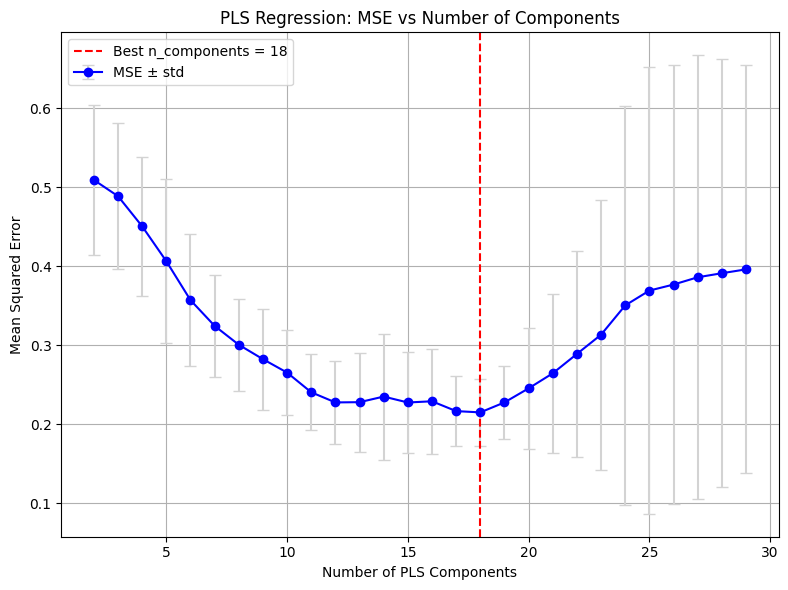


Best number of PLS components: 18

Test set performance (PLS):
- MAE:  0.33 L
- MSE:  0.18 L²
- RMSE: 0.42 L
- R²:   0.721

Training set performance (PLS):
- MAE:  0.19 L
- MSE:  0.07 L²
- RMSE: 0.26 L
- R²:   0.912

PLS coefficients (sorted by |coef|):
                                                Feature  Coefficient
0                                 Baseline FVC Volume L     0.317352
2                                         FEV1 Volume L     0.285233
2651                                         Sex_Female    -0.061800
2652                                           Sex_Male     0.061800
1                                                   Age    -0.051600
...                                                 ...          ...
2105                     wavelet-LLL_glcm_Idm_left_lung    -0.000013
372   wavelet-LHH_gldm_DependenceNonUniformityNormal...    -0.000006
1181  log-sigma-4-0-mm-3D_glrlm_LongRunLowGrayLevelE...    -0.000005
1554             wavelet-LHL_glcm_JointEnergy_left_lung

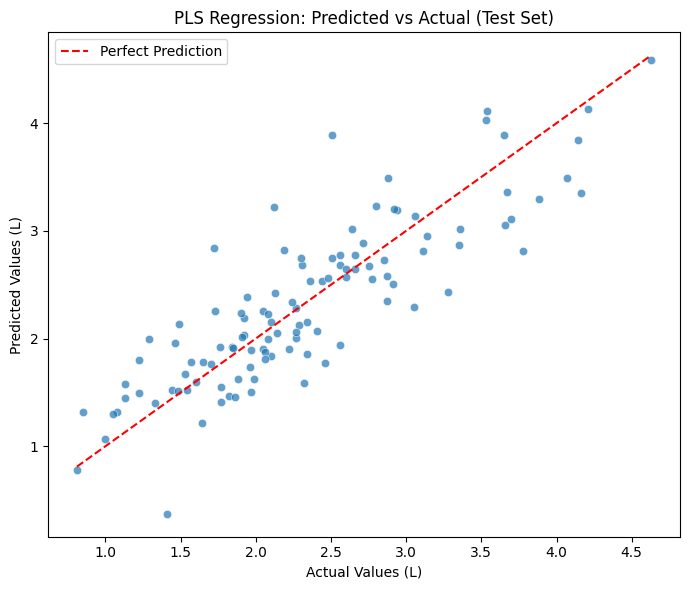


Top 5 patients with largest errors:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
152          3.63        2.51       3.888244   1.378244                0.0   
426          1.66        1.72       2.837409   1.117409                0.0   
83           2.37        2.12       3.217770   1.097770                0.0   
8            1.32        1.41       0.372593   1.037407                0.0   
123          2.23        3.78       2.814645   0.965355                0.0   

     Followup_FVC_Week  
152               53.0  
426               52.0  
83                52.0  
8                 52.0  
123               51.0  


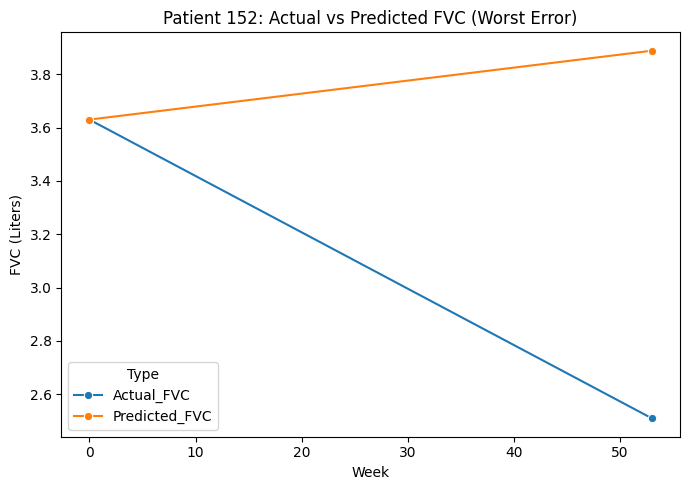

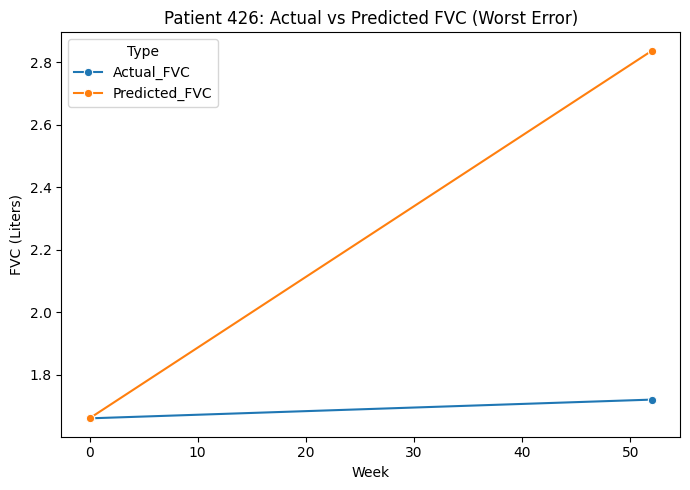

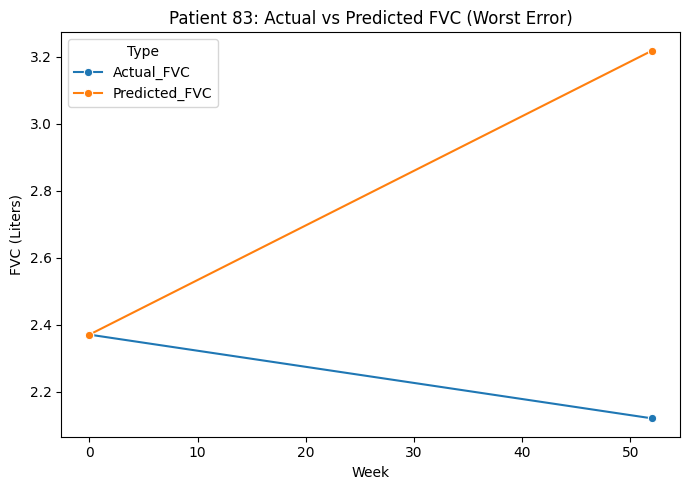

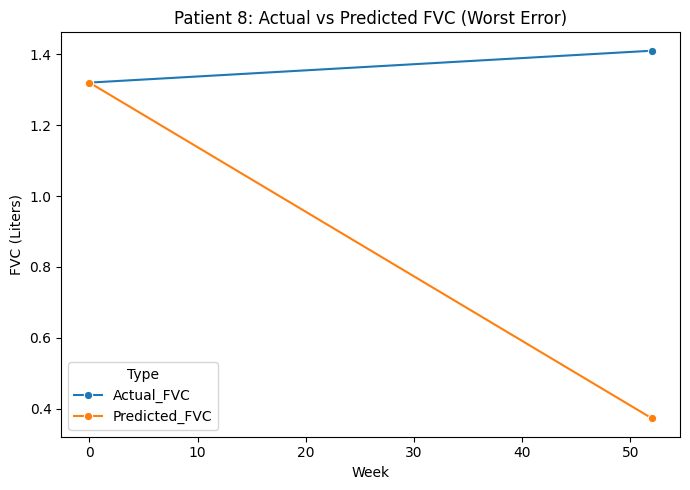

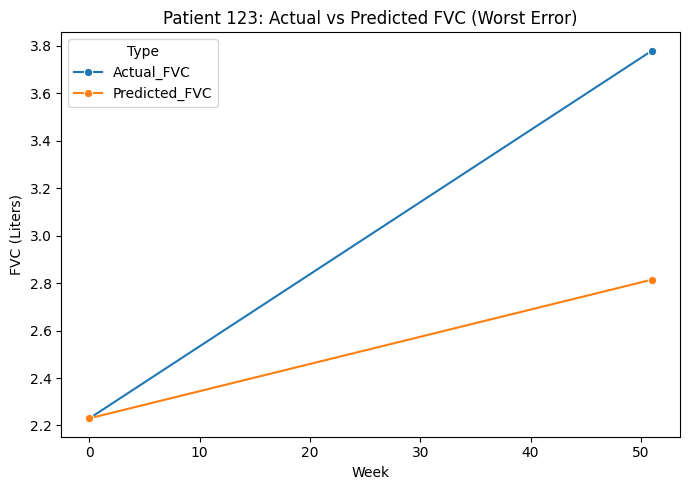


Top 5 patients with increasing FVC and lowest error:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
514          2.65        2.66       2.643070   0.016930                0.0   
156          2.48        2.60       2.567003   0.032997                0.0   
535          1.43        1.48       1.517289   0.037289                0.0   
467          2.38        2.60       2.649325   0.049325                0.0   
264          1.19        1.44       1.520262   0.080262                0.0   

     Followup_FVC_Week  
514               52.0  
156               49.0  
535               55.0  
467               56.0  
264               52.0  


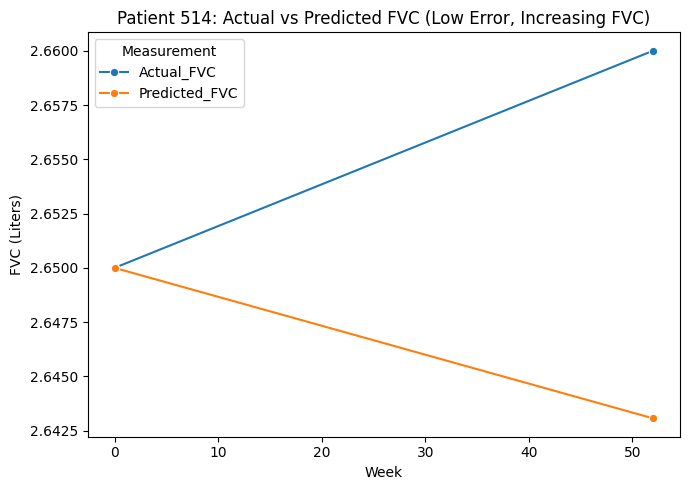

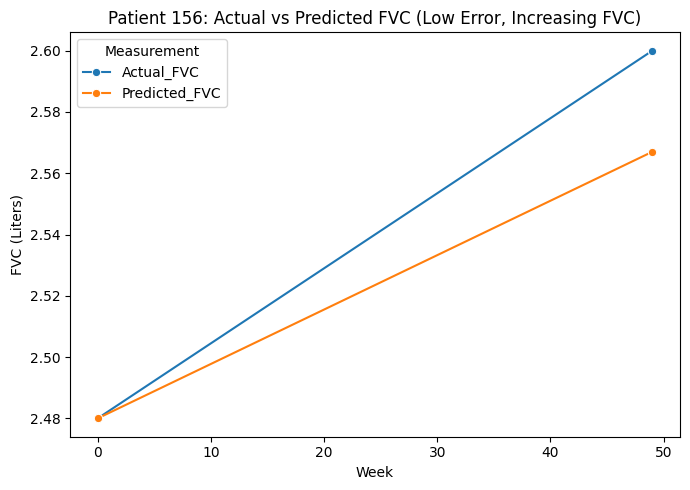

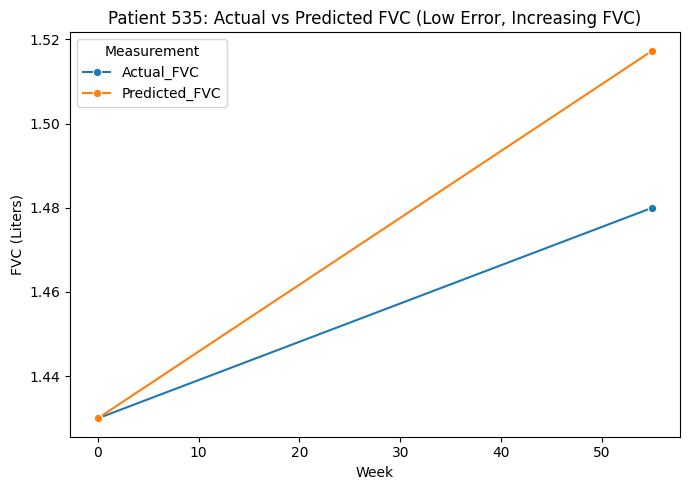

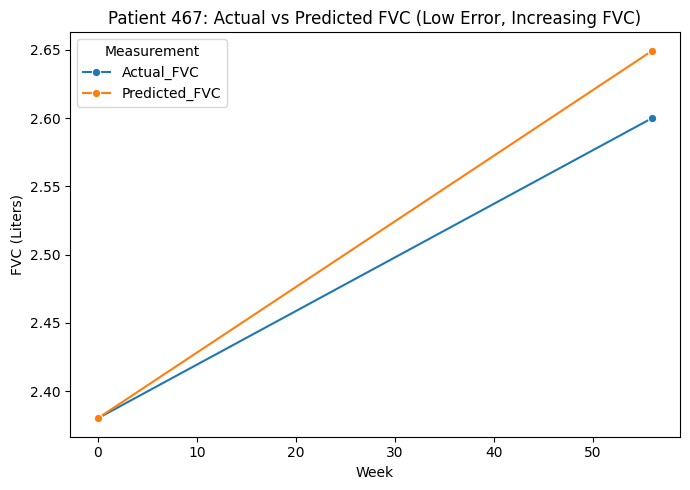

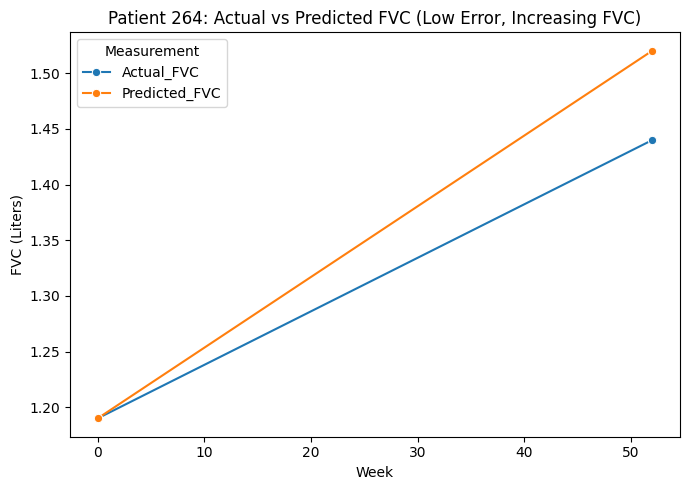

In [18]:
# all combined radiomics + clinical features
X_train, X_test, y_train, y_test = joblib.load("/home/pansurya/OSIC_thesis/radiomics_files/data_splits_clinical_without_harmonization.pkl")
# Radiomics: automatically grab all columns with certain prefixes
Radiomics_data = [col for col in X_train.columns 
                  if col.startswith(("wavelet", "original", "log-sigma"))]
all_features = Clinical_Contineous_data + Radiomics_data


X_train_clini_log = X_train.copy()
X_test_clini_log  = X_test.copy()

# Transform Age
for col in ['Age']:
    X_train_clini_log[col] = np.log(X_train_clini_log[col])
    X_test_clini_log[col] = np.log(X_test_clini_log[col])

# Median imputation (only needed if missing values exist)
imp_median = SimpleImputer(strategy='median')
imp_median.fit(X_train_clini_log)

X_train_median_filled = pd.DataFrame(
    imp_median.transform(X_train_clini_log),
    columns=X_train_clini_log.columns,
    index=X_train_clini_log.index
)

X_test_median_filled = pd.DataFrame(
    imp_median.transform(X_test_clini_log),
    columns=X_test_clini_log.columns,
    index=X_test_clini_log.index
)

results1 = train_and_evaluate_pls(X_train_median_filled, X_test_median_filled, y_train, y_test, all_features, all_features, Clinical_Categorical_data, model_name="/home/pansurya/OSIC_thesis/PLS_model/PLS_With_All_Clinical_Radiomics_without_harmonization.pkl")

Numeric features: ['original_shape_Elongation_right_lung', 'original_shape_Flatness_right_lung', 'original_shape_LeastAxisLength_right_lung', 'original_shape_MajorAxisLength_right_lung', 'original_shape_Maximum2DDiameterColumn_right_lung', 'original_shape_Maximum2DDiameterRow_right_lung', 'original_shape_Maximum2DDiameterSlice_right_lung', 'original_shape_Maximum3DDiameter_right_lung', 'original_shape_MeshVolume_right_lung', 'original_shape_MinorAxisLength_right_lung', 'original_shape_Sphericity_right_lung', 'original_shape_SurfaceArea_right_lung', 'original_shape_SurfaceVolumeRatio_right_lung', 'original_shape_VoxelVolume_right_lung', 'original_firstorder_10Percentile_right_lung', 'original_firstorder_90Percentile_right_lung', 'original_firstorder_Energy_right_lung', 'original_firstorder_Entropy_right_lung', 'original_firstorder_InterquartileRange_right_lung', 'original_firstorder_Kurtosis_right_lung', 'original_firstorder_Maximum_right_lung', 'original_firstorder_MeanAbsoluteDeviatio

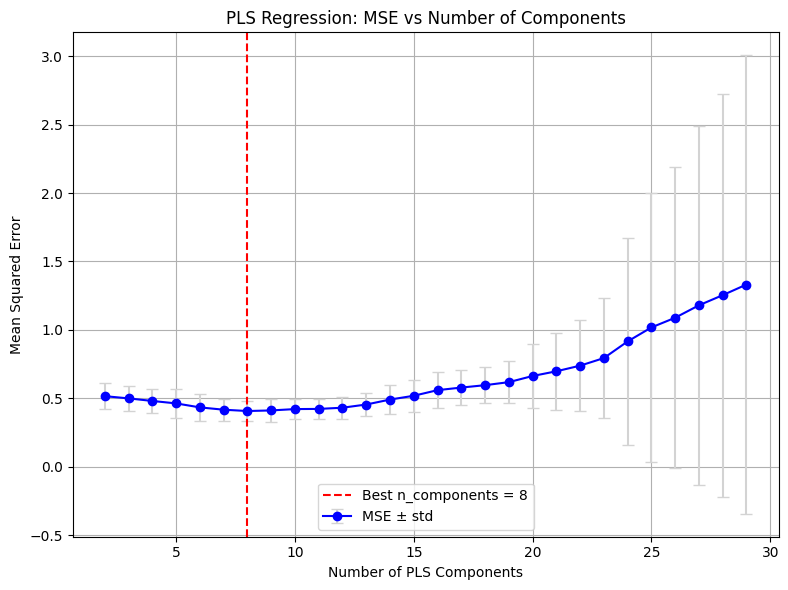


Best number of PLS components: 8

Test set performance (PLS):
- MAE:  0.47 L
- MSE:  0.36 L²
- RMSE: 0.60 L
- R²:   0.445

Training set performance (PLS):
- MAE:  0.43 L
- MSE:  0.30 L²
- RMSE: 0.54 L
- R²:   0.623

PLS coefficients (sorted by |coef|):
                                                Feature  Coefficient
9             original_shape_MinorAxisLength_right_lung     0.026299
1325           original_shape_MinorAxisLength_left_lung     0.025061
301              wavelet-LHH_firstorder_Mean_right_lung     0.016587
1524              wavelet-LHL_firstorder_Mean_left_lung    -0.015315
673              wavelet-HHH_firstorder_Mean_right_lung     0.015227
...                                                 ...          ...
2192  log-sigma-1-0-mm-3D_glcm_DifferenceEntropy_lef...    -0.000005
785                      wavelet-LLL_glcm_Id_right_lung     0.000003
1209  log-sigma-4-0-mm-3D_gldm_GrayLevelVariance_rig...     0.000003
1981      wavelet-HHH_firstorder_10Percentile_left_lung 

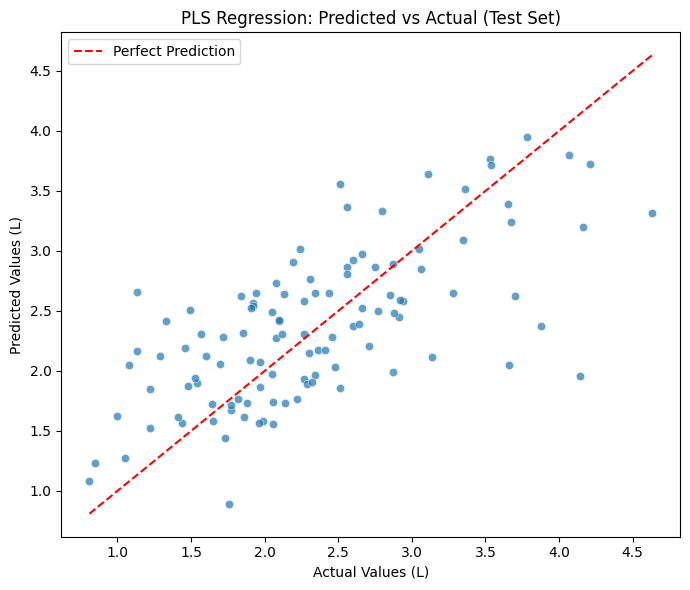


Top 5 patients with largest errors:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
470          4.04        4.14       1.955973   2.184027                0.0   
501          3.56        3.66       2.052000   1.608000                0.0   
54           1.39        1.13       2.654983   1.524983                0.0   
81           3.59        3.88       2.371105   1.508895                0.0   
163          4.73        4.63       3.311747   1.318253                0.0   

     Followup_FVC_Week  
470               53.0  
501               50.0  
54                55.0  
81                52.0  
163               49.0  


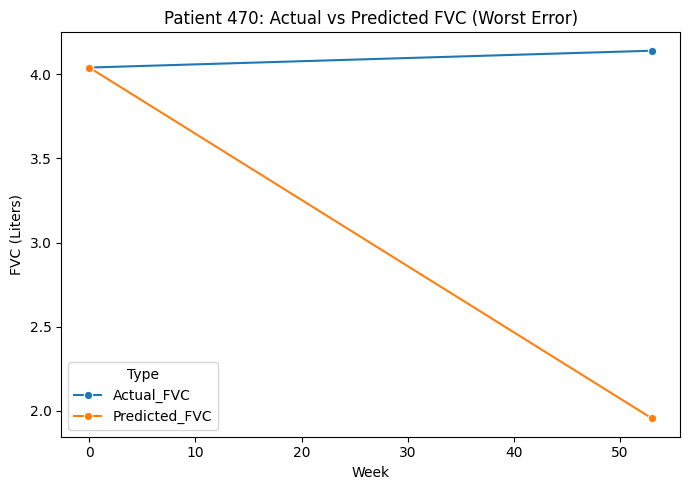

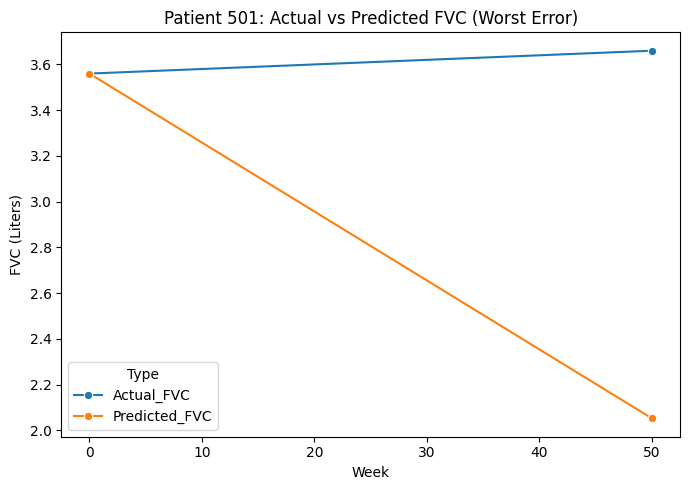

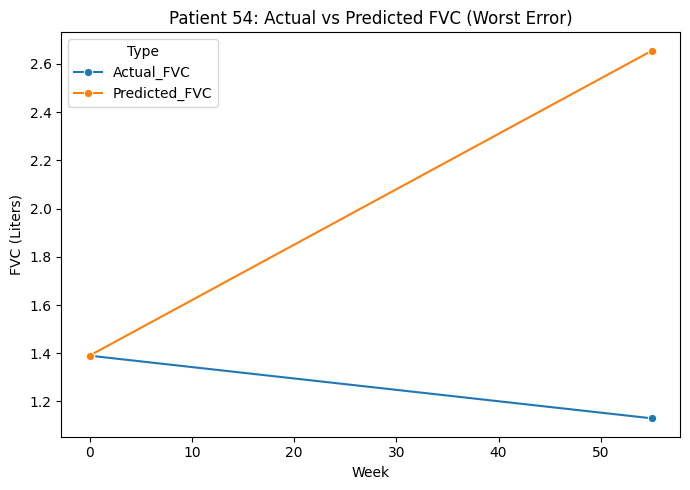

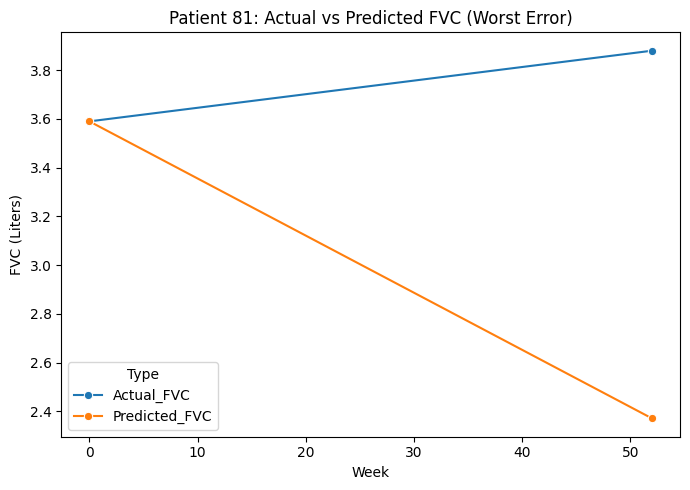

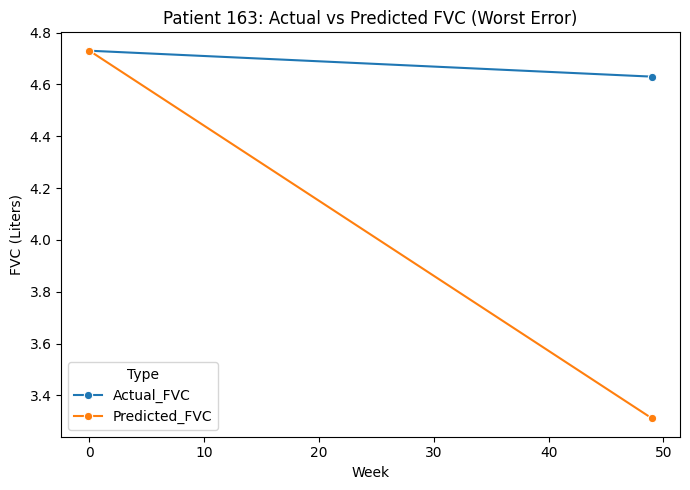


Top 5 patients with increasing FVC and lowest error:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
453          2.87       2.871       2.892235   0.021235                0.0   
360          2.99       3.050       3.017293   0.032707                0.0   
283          1.60       1.640       1.721908   0.081908                0.0   
369          1.93       1.970       2.070443   0.100443                0.0   
264          1.19       1.440       1.569049   0.129049                0.0   

     Followup_FVC_Week  
453               55.0  
360               50.0  
283               52.0  
369               55.0  
264               52.0  


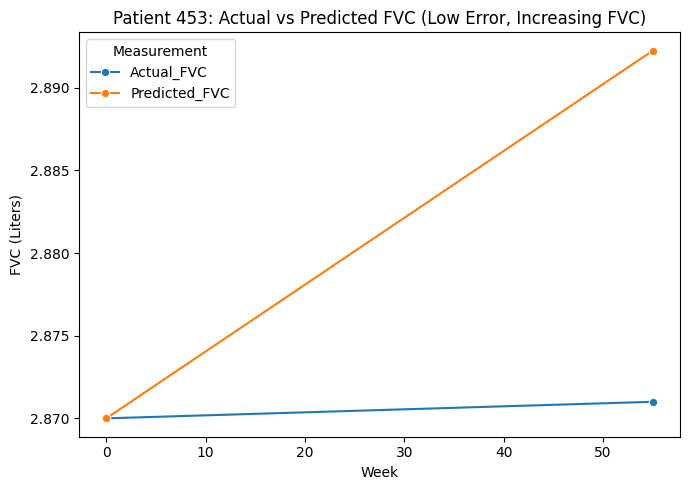

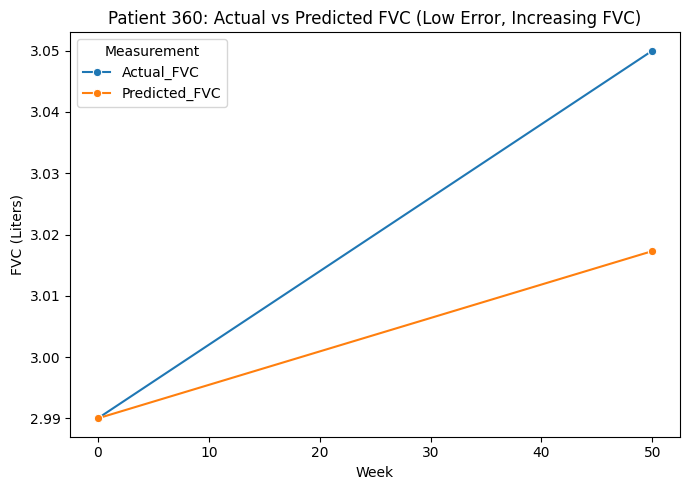

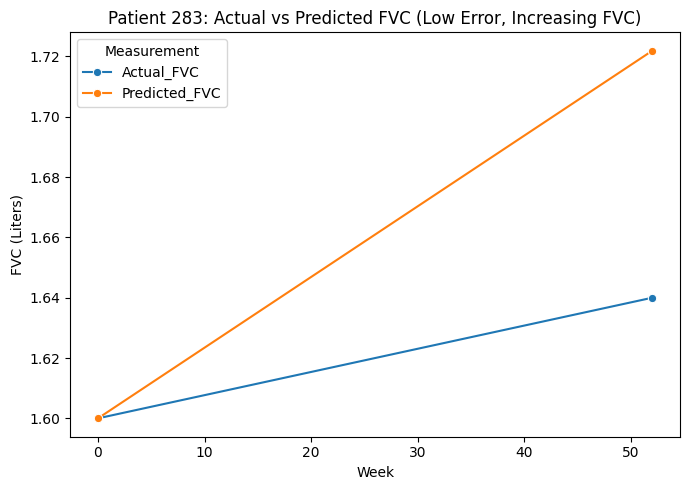

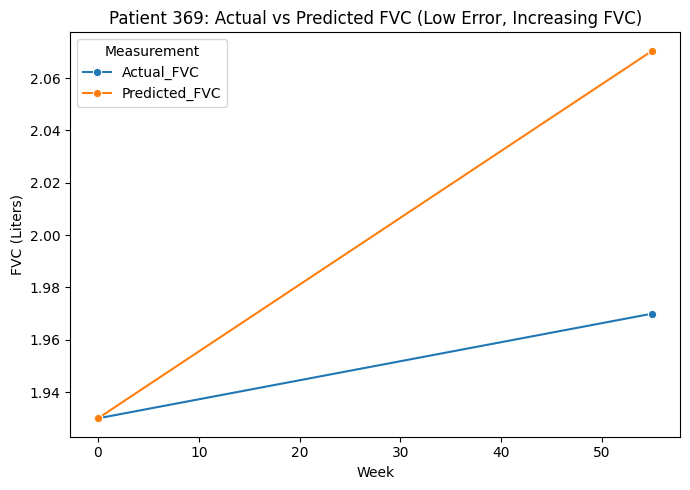

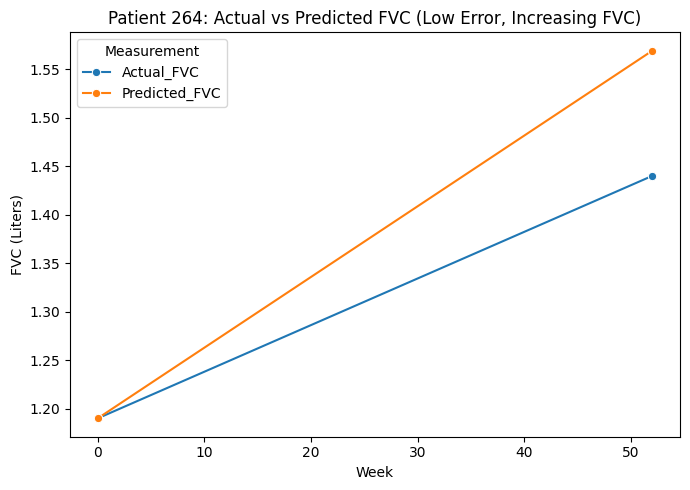

In [10]:
# all radiomics-only features
X_train, X_test, y_train, y_test = joblib.load("/home/pansurya/OSIC_thesis/radiomics_files/data_splits_clinical_without_harmonization.pkl")
# Radiomics: automatically grab all columns with certain prefixes
Radiomics_data = [col for col in X_train.columns 
                  if col.startswith(("wavelet", "original", "log-sigma"))]
all_features = Radiomics_data 

Clinical_Categorical_data = []
X_train_clini_log = X_train.copy()
X_test_clini_log  = X_test.copy()

# Transform Age
for col in ['Age']:
    X_train_clini_log[col] = np.log(X_train_clini_log[col])
    X_test_clini_log[col] = np.log(X_test_clini_log[col])

# Median imputation (only needed if missing values exist)
imp_median = SimpleImputer(strategy='median')
imp_median.fit(X_train_clini_log)

X_train_median_filled = pd.DataFrame(
    imp_median.transform(X_train_clini_log),
    columns=X_train_clini_log.columns,
    index=X_train_clini_log.index
)

X_test_median_filled = pd.DataFrame(
    imp_median.transform(X_test_clini_log),
    columns=X_test_clini_log.columns,
    index=X_test_clini_log.index
)

results1 = train_and_evaluate_pls(X_train_median_filled, X_test_median_filled, y_train, y_test, all_features, all_features, Clinical_Categorical_data, model_name="/home/pansurya/OSIC_thesis/PLS_model/PLS_With_all_radiomics-only_features_without_harmonization.pkl")

['Baseline FVC Volume L', 'Age', 'FEV1 Volume L']
Numeric features: ['Baseline FVC Volume L', 'Age', 'FEV1 Volume L']
One-hot features: ['Primary Diagnosis_CHP', 'Primary Diagnosis_CTD-ILD', 'Primary Diagnosis_Emphysema', 'Primary Diagnosis_Exposure-related', 'Primary Diagnosis_Fibrotic HP (FHP)', 'Primary Diagnosis_INSIP', 'Primary Diagnosis_IPF', 'Primary Diagnosis_Idiopathic OP', 'Primary Diagnosis_Idiopathic pleuroparenchymal fibroelastosis (IPPFE)', 'Primary Diagnosis_Miscellaneous', 'Primary Diagnosis_NSIP', 'Primary Diagnosis_No information', 'Primary Diagnosis_Occupational-related ILD', 'Primary Diagnosis_Sarcoidosis', 'Primary Diagnosis_Smoking Related ILD (DIP / RB / RB-ILD)', 'Primary Diagnosis_UILD', 'Sex_Female', 'Sex_Male', 'Smoking History_Active Smoker', 'Smoking History_Ex Smoker', 'Smoking History_Never Smoker', 'Smoking History_No Knowledge']
number of features given as input: 25
Fitting 15 folds for each of 23 candidates, totalling 345 fits

Best hyperparameters fou

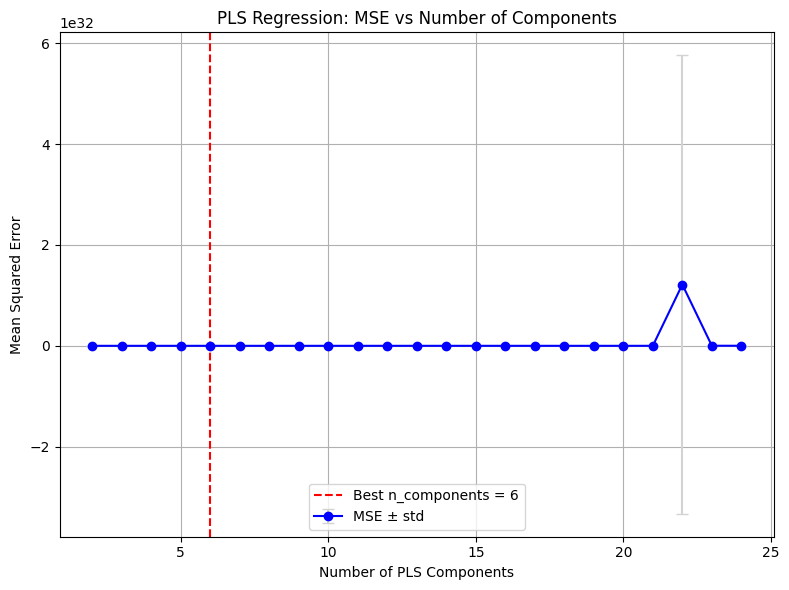


Best number of PLS components: 6

Test set performance (PLS):
- MAE:  0.23 L
- MSE:  0.10 L²
- RMSE: 0.32 L
- R²:   0.842

Training set performance (PLS):
- MAE:  0.25 L
- MSE:  0.13 L²
- RMSE: 0.36 L
- R²:   0.831

PLS coefficients (sorted by |coef|):
                                              Feature  Coefficient
0                               Baseline FVC Volume L     0.796342
8                             Primary Diagnosis_INSIP     0.347124
3                               Primary Diagnosis_CHP    -0.204947
6                  Primary Diagnosis_Exposure-related     0.144590
21                      Smoking History_Active Smoker     0.109970
18                             Primary Diagnosis_UILD    -0.105951
13                             Primary Diagnosis_NSIP    -0.100868
9                               Primary Diagnosis_IPF    -0.093668
7                 Primary Diagnosis_Fibrotic HP (FHP)    -0.074101
1                                                 Age    -0.066710
19       

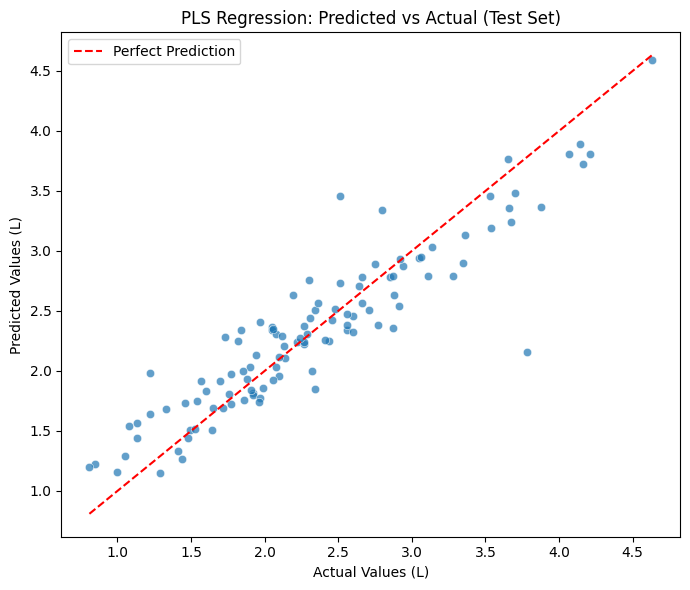


Top 5 patients with largest errors:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
123          2.23        3.78       2.157443   1.622557                0.0   
152          3.63        2.51       3.456028   0.946028                0.0   
233          1.98        1.22       1.983450   0.763450                0.0   
326          2.37        1.73       2.283684   0.553684                0.0   
44           3.44        2.80       3.342503   0.542503                0.0   

     Followup_FVC_Week  
123               51.0  
152               53.0  
233               54.0  
326               56.0  
44                50.0  


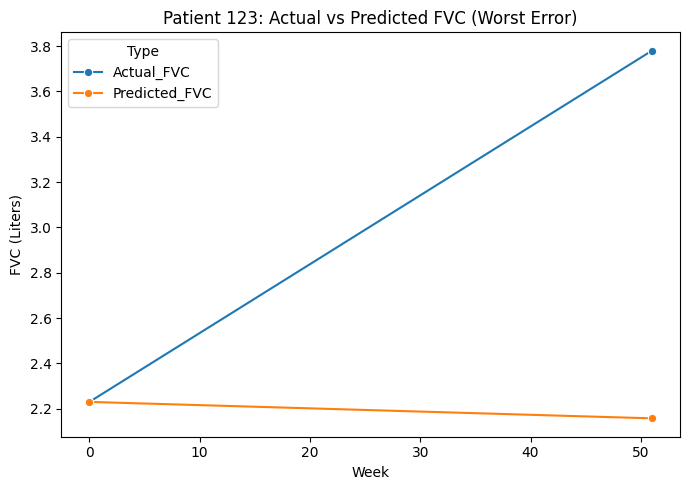

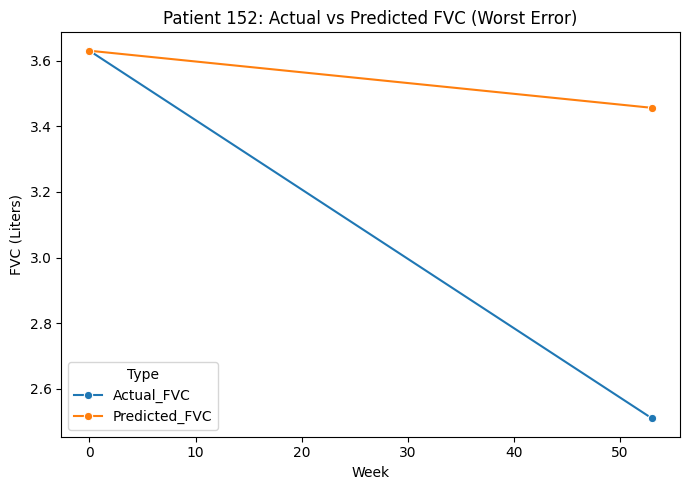

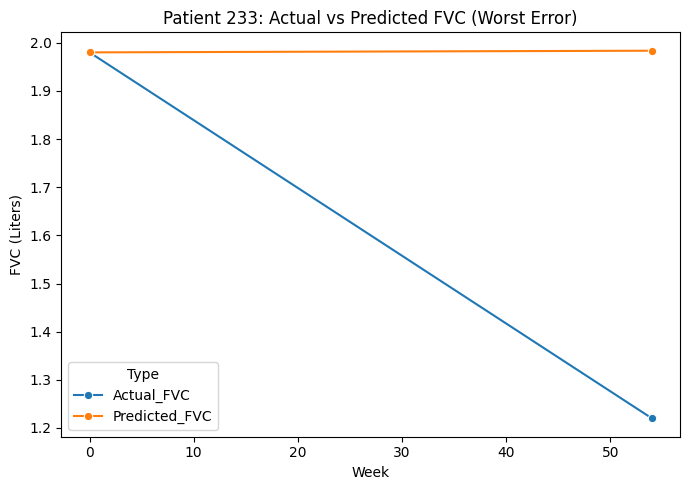

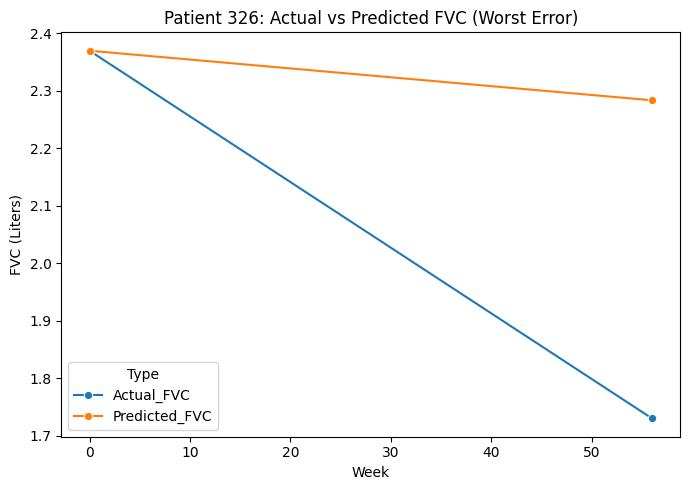

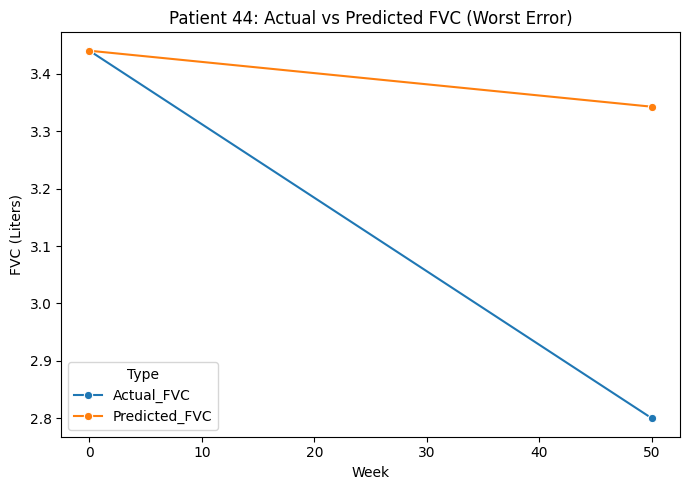


Top 5 patients with increasing FVC and lowest error:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
511          1.43        1.49       1.511189   0.021189                0.0   
426          1.66        1.72       1.691009   0.028991                0.0   
100          2.35        2.46       2.423629   0.036371                0.0   
535          1.43        1.48       1.440813   0.039187                0.0   
8            1.32        1.41       1.329612   0.080388                0.0   

     Followup_FVC_Week  
511               54.0  
426               52.0  
100               53.0  
535               55.0  
8                 52.0  


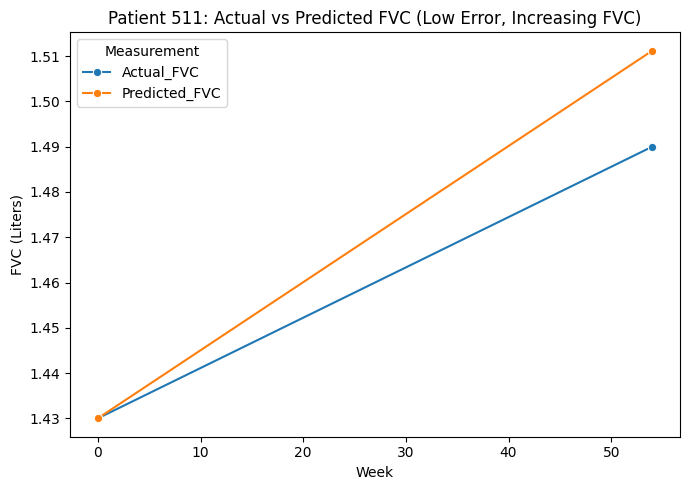

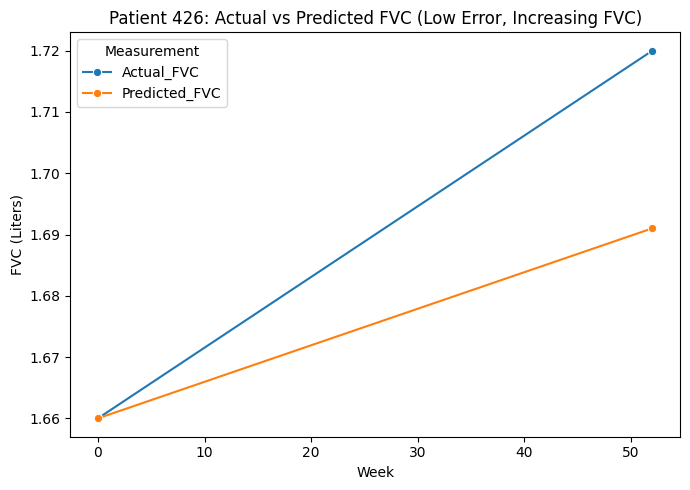

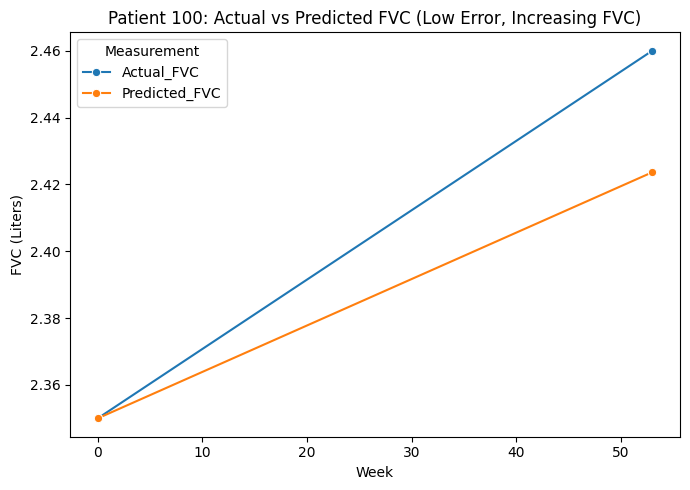

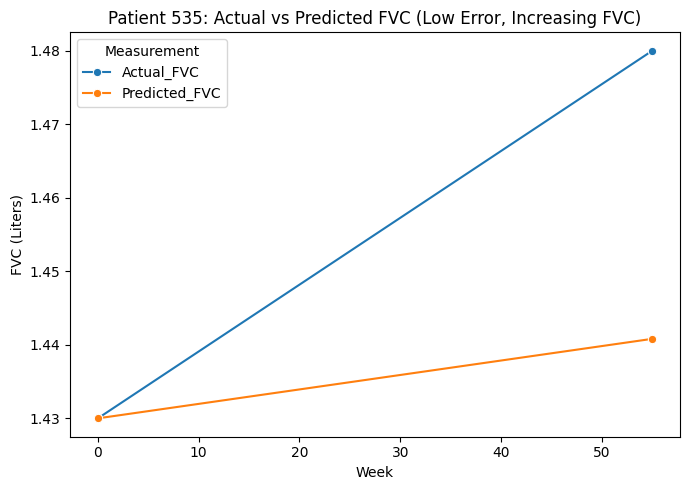

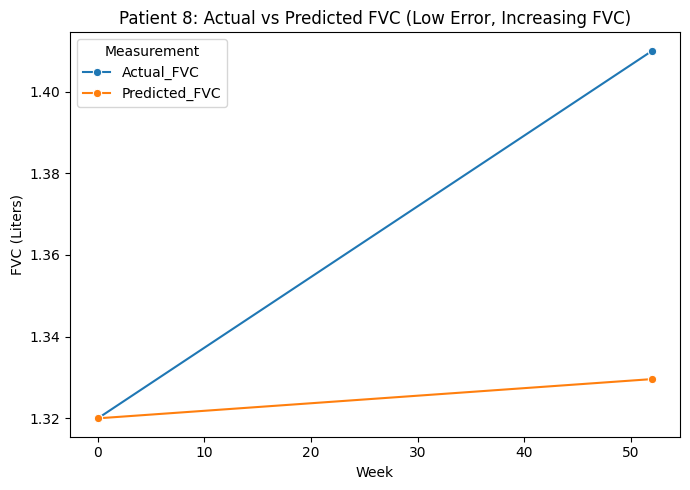

In [14]:
#all clinical-only features
selected_features = []
Clinical_Contineous_data_ext = selected_features + Clinical_Contineous_data
print(Clinical_Contineous_data_ext)
X_train, X_test, y_train, y_test = joblib.load("/home/pansurya/OSIC_thesis/radiomics_files/data_splits_clinical_without_harmonization.pkl")
X_train_clini_log = X_train.copy()
X_test_clini_log  = X_test.copy()

# Transform Age
for col in ['Age']:
    X_train_clini_log[col] = np.log(X_train_clini_log[col])
    X_test_clini_log[col] = np.log(X_test_clini_log[col])

# Median imputation (only needed if missing values exist)
imp_median = SimpleImputer(strategy='median')
imp_median.fit(X_train_clini_log)

X_train_median_filled = pd.DataFrame(
    imp_median.transform(X_train_clini_log),
    columns=X_train_clini_log.columns,
    index=X_train_clini_log.index
)

X_test_median_filled = pd.DataFrame(
    imp_median.transform(X_test_clini_log),
    columns=X_test_clini_log.columns,
    index=X_test_clini_log.index
)


# Run experiments
results1 = train_and_evaluate_pls(X_train_median_filled, X_test_median_filled, y_train, y_test, selected_features, Clinical_Contineous_data_ext, Clinical_Categorical_data, model_name="/home/pansurya/OSIC_thesis/PLS_model/PAM__with_all_clinical-only_features_without_harmonization.pkl")

Model Training using Selected Features

['wavelet-LLL_glszm_GrayLevelVariance_left_lung', 'original_shape_MinorAxisLength_left_lung', 'original_gldm_SmallDependenceHighGrayLevelEmphasis_right_lung', 'original_glszm_LargeAreaLowGrayLevelEmphasis_left_lung', 'log-sigma-3-0-mm-3D_glrlm_ShortRunEmphasis_left_lung', 'log-sigma-5-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_right_lung', 'Baseline FVC Volume L', 'Age', 'FEV1 Volume L']
Numeric features: ['wavelet-LLL_glszm_GrayLevelVariance_left_lung', 'original_shape_MinorAxisLength_left_lung', 'original_gldm_SmallDependenceHighGrayLevelEmphasis_right_lung', 'original_glszm_LargeAreaLowGrayLevelEmphasis_left_lung', 'log-sigma-3-0-mm-3D_glrlm_ShortRunEmphasis_left_lung', 'log-sigma-5-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_right_lung', 'Baseline FVC Volume L', 'Age', 'FEV1 Volume L']
One-hot features: ['Primary Diagnosis_CHP', 'Primary Diagnosis_CTD-ILD', 'Primary Diagnosis_Emphysema', 'Primary Diagnosis_Exposure-related', 'Primary Diagnosis_Fibrotic HP (FHP)', 'Prim

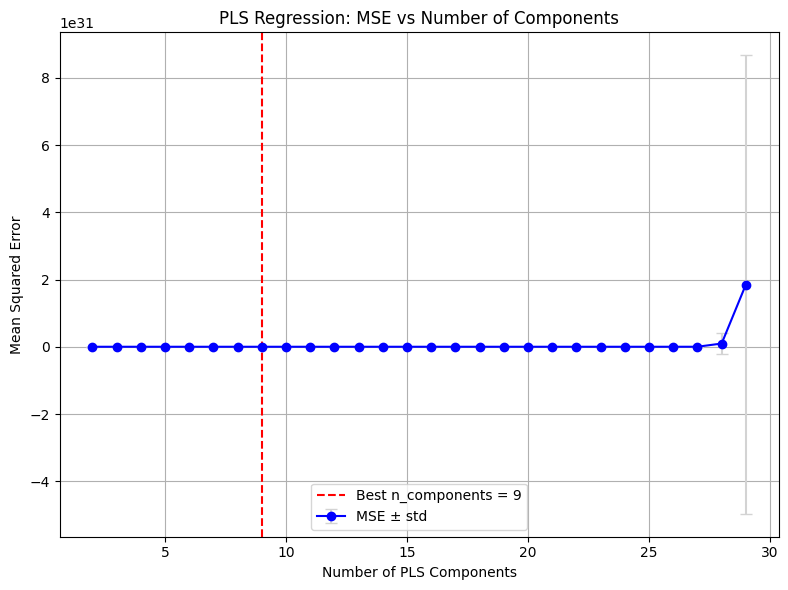


Best number of PLS components: 9

Test set performance (PLS):
- MAE:  0.24 L
- MSE:  0.11 L²
- RMSE: 0.33 L
- R²:   0.834

Training set performance (PLS):
- MAE:  0.24 L
- MSE:  0.13 L²
- RMSE: 0.35 L
- R²:   0.840

PLS coefficients (sorted by |coef|):
                                              Feature  Coefficient
6                               Baseline FVC Volume L     0.722086
14                            Primary Diagnosis_INSIP     0.263186
9                               Primary Diagnosis_CHP    -0.201865
12                 Primary Diagnosis_Exposure-related     0.120327
27                      Smoking History_Active Smoker     0.103727
15                              Primary Diagnosis_IPF    -0.086421
1            original_shape_MinorAxisLength_left_lung     0.071201
19                             Primary Diagnosis_NSIP    -0.066974
26                                           Sex_Male     0.066423
25                                         Sex_Female    -0.066423
28       

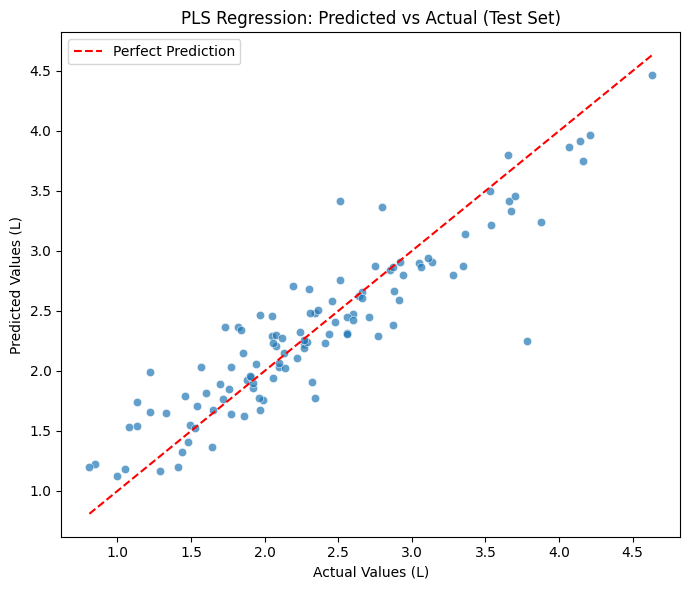


Top 5 patients with largest errors:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
123          2.23        3.78       2.250069   1.529931                0.0   
152          3.63        2.51       3.415721   0.905721                0.0   
233          1.98        1.22       1.987208   0.767208                0.0   
81           3.59        3.88       3.237984   0.642016                0.0   
326          2.37        1.73       2.363254   0.633254                0.0   

     Followup_FVC_Week  
123               51.0  
152               53.0  
233               54.0  
81                52.0  
326               56.0  


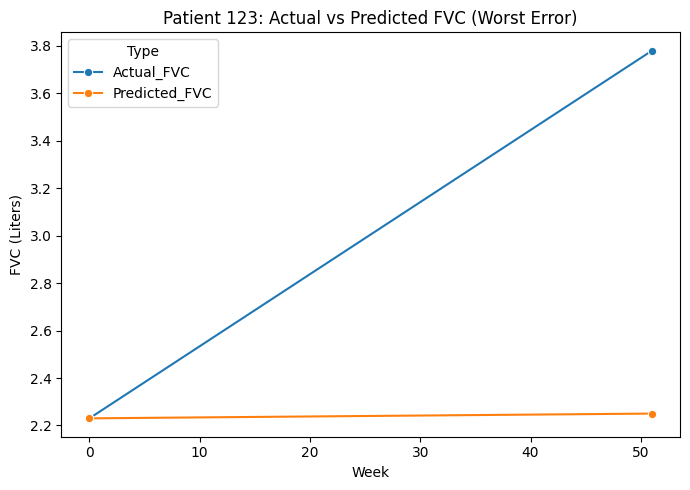

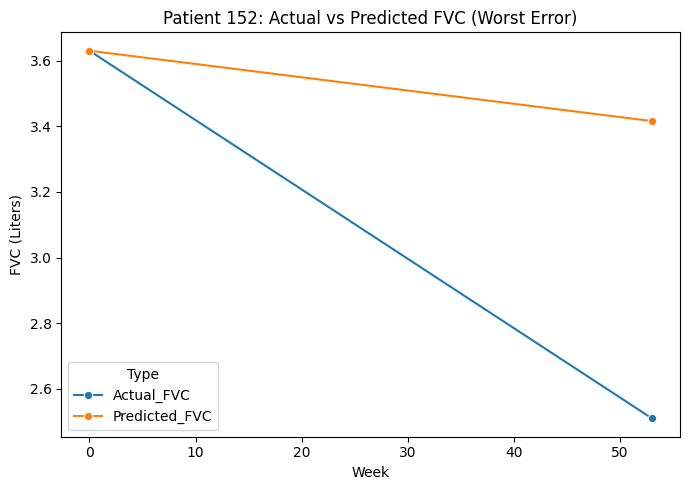

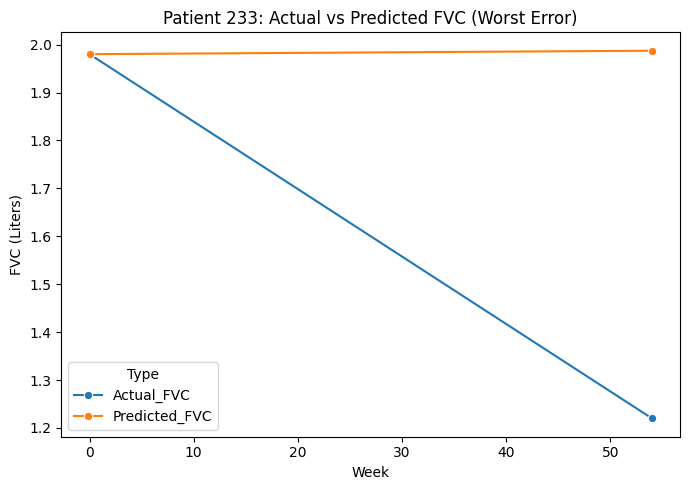

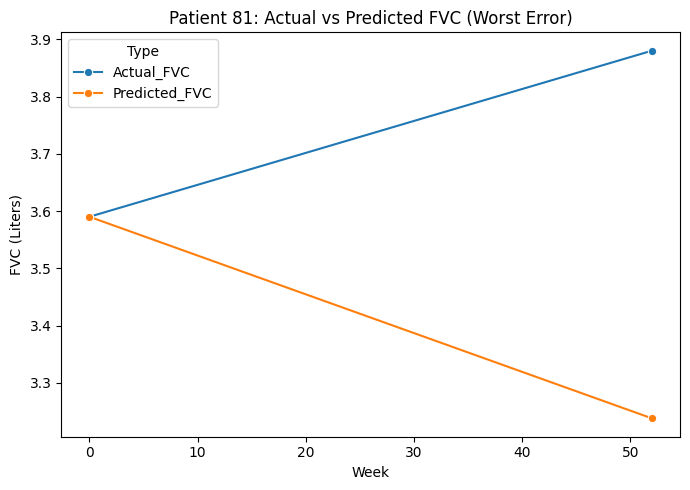

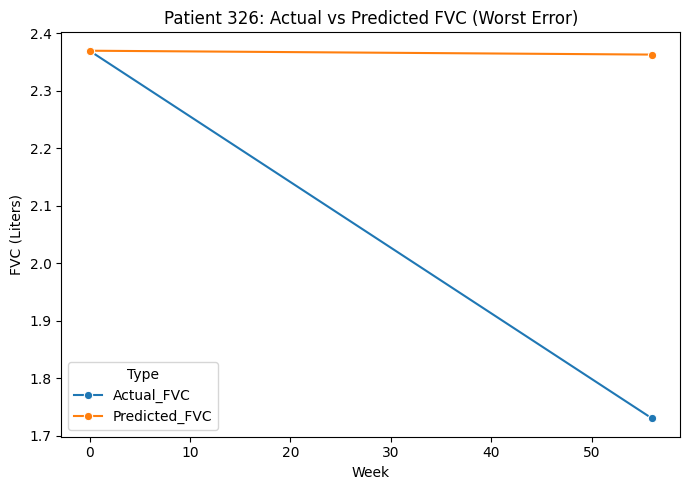


Top 5 patients with increasing FVC and lowest error:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
453          2.87       2.871       2.868074   0.002926                0.0   
99           1.81       1.920       1.899137   0.020863                0.0   
426          1.66       1.720       1.766303   0.046303                0.0   
514          2.65       2.660       2.606742   0.053258                0.0   
511          1.43       1.490       1.549142   0.059142                0.0   

     Followup_FVC_Week  
453               55.0  
99                48.0  
426               52.0  
514               52.0  
511               54.0  


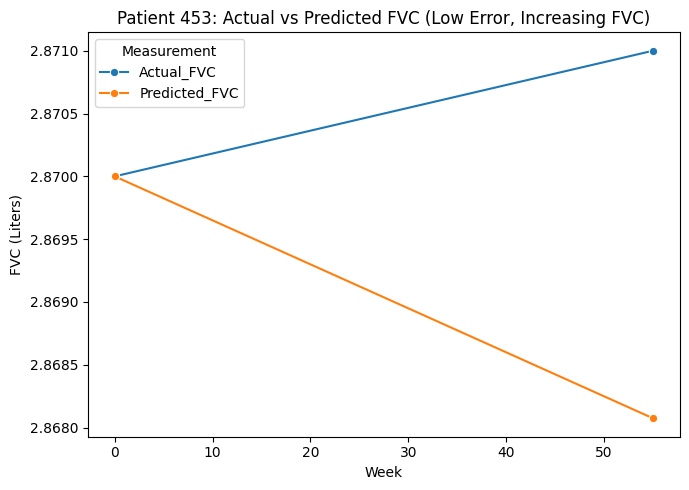

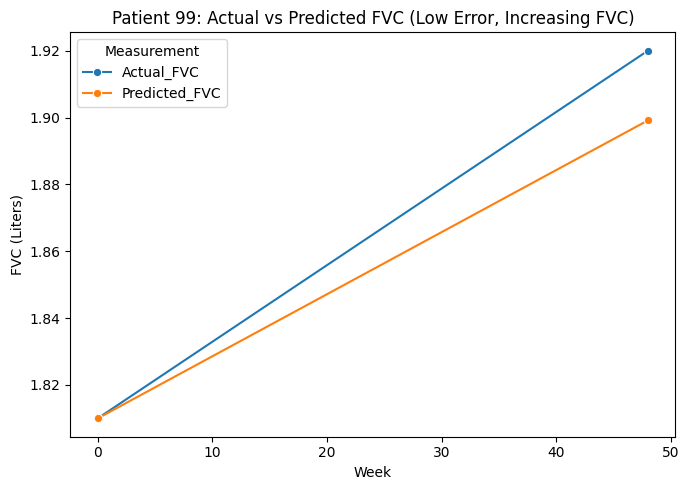

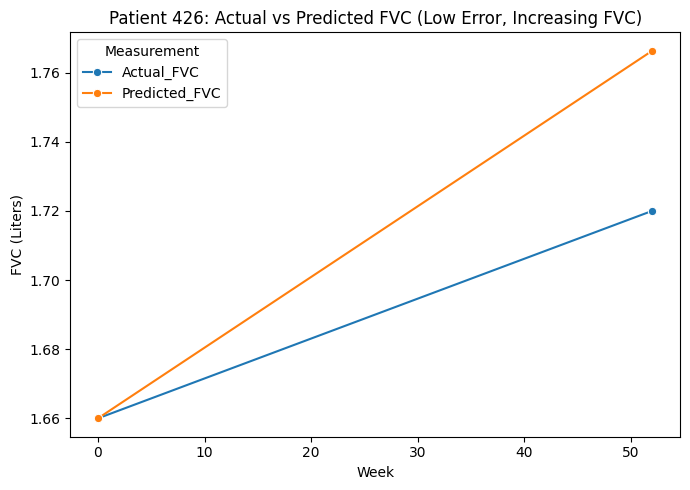

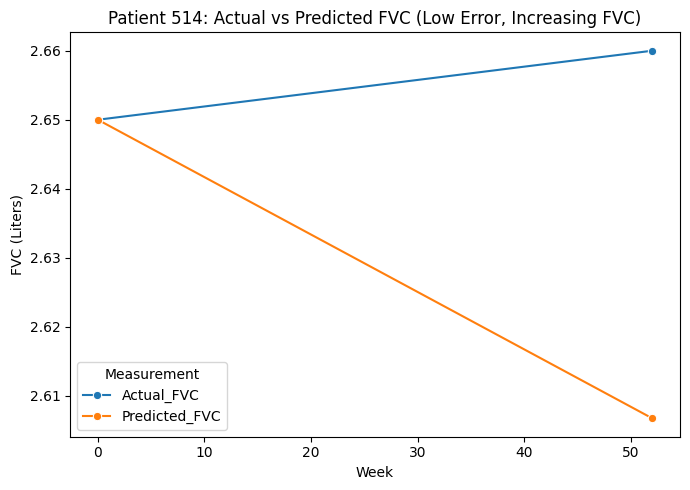

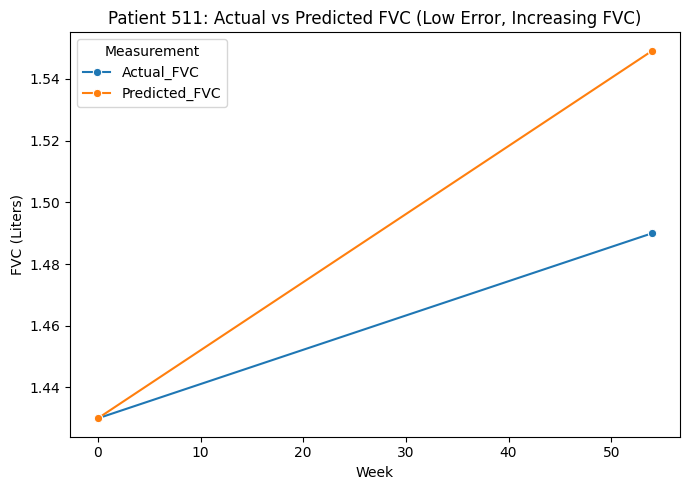

In [4]:
#Pipeline P1: PAM → Correlation with Target → mRMR → VIF
selected_features = ['wavelet-LLL_glszm_GrayLevelVariance_left_lung', 'original_shape_MinorAxisLength_left_lung', 'original_gldm_SmallDependenceHighGrayLevelEmphasis_right_lung', 'original_glszm_LargeAreaLowGrayLevelEmphasis_left_lung', 'log-sigma-3-0-mm-3D_glrlm_ShortRunEmphasis_left_lung', 'log-sigma-5-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_right_lung']
Clinical_Contineous_data_ext = selected_features + Clinical_Contineous_data
print(Clinical_Contineous_data_ext)
X_train, X_test, y_train, y_test = joblib.load("/home/pansurya/OSIC_thesis/radiomics_files/data_splits_clinical_without_harmonization.pkl")
X_train_clini_log = X_train.copy()
X_test_clini_log  = X_test.copy()

# Transform Age
for col in ['Age']:
    X_train_clini_log[col] = np.log(X_train_clini_log[col])
    X_test_clini_log[col] = np.log(X_test_clini_log[col])

# Median imputation (only needed if missing values exist)
imp_median = SimpleImputer(strategy='median')
imp_median.fit(X_train_clini_log)

X_train_median_filled = pd.DataFrame(
    imp_median.transform(X_train_clini_log),
    columns=X_train_clini_log.columns,
    index=X_train_clini_log.index
)

X_test_median_filled = pd.DataFrame(
    imp_median.transform(X_test_clini_log),
    columns=X_test_clini_log.columns,
    index=X_test_clini_log.index
)


# Run experiments
results1 = train_and_evaluate_pls(X_train_median_filled, X_test_median_filled, y_train, y_test, selected_features, Clinical_Contineous_data_ext, Clinical_Categorical_data, 
model_name="/home/pansurya/OSIC_thesis/PLS_model/PLS_PAM_mrmr_VIF_without_harmonization.pkl")

['original_firstorder_Kurtosis_right_lung', 'log-sigma-4-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis_left_lung', 'wavelet-LHL_glrlm_GrayLevelNonUniformity_right_lung', 'wavelet-LLL_glrlm_RunLengthNonUniformity_right_lung', 'log-sigma-2-0-mm-3D_ngtdm_Busyness_left_lung', 'log-sigma-1-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis_right_lung', 'wavelet-HHL_glrlm_GrayLevelNonUniformity_right_lung', 'log-sigma-3-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_right_lung', 'log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity_left_lung', 'original_firstorder_MeanAbsoluteDeviation_right_lung', 'wavelet-LHL_glrlm_GrayLevelNonUniformity_left_lung', 'log-sigma-4-0-mm-3D_glszm_GrayLevelNonUniformity_right_lung', 'log-sigma-2-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis_left_lung', 'original_glrlm_GrayLevelNonUniformity_right_lung', 'original_firstorder_90Percentile_right_lung', 'log-sigma-5-0-mm-3D_firstorder_Energy_left_lung', 'log-sigma-5-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_right_lung

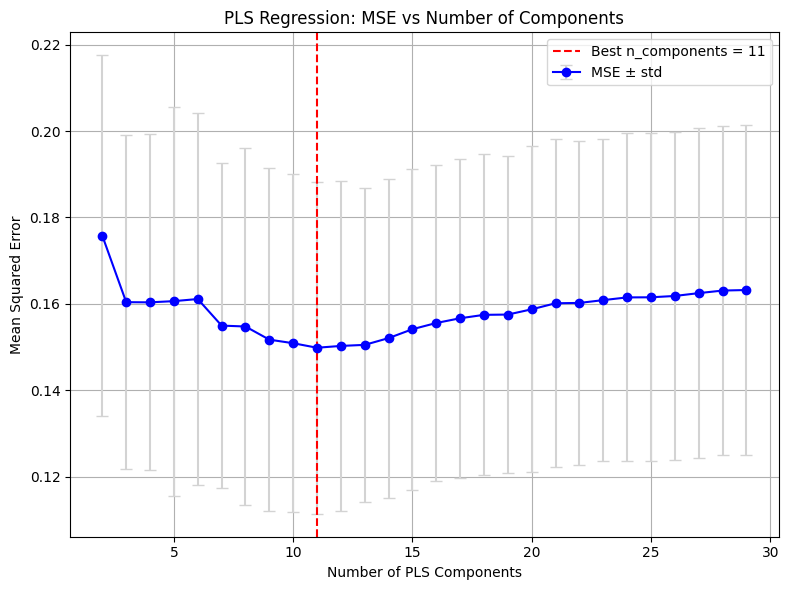


Best number of PLS components: 11

Test set performance (PLS):
- MAE:  0.25 L
- MSE:  0.12 L²
- RMSE: 0.34 L
- R²:   0.820

Training set performance (PLS):
- MAE:  0.24 L
- MSE:  0.12 L²
- RMSE: 0.34 L
- R²:   0.850

PLS coefficients (sorted by |coef|):
                                              Feature  Coefficient
30                              Baseline FVC Volume L     0.723316
38                            Primary Diagnosis_INSIP     0.219933
33                              Primary Diagnosis_CHP    -0.214941
4        log-sigma-2-0-mm-3D_ngtdm_Busyness_left_lung     0.145428
15    log-sigma-5-0-mm-3D_firstorder_Energy_left_lung    -0.134752
17  log-sigma-2-0-mm-3D_glszm_LargeAreaLowGrayLeve...    -0.129738
12  log-sigma-2-0-mm-3D_glrlm_LongRunHighGrayLevel...     0.126056
13   original_glrlm_GrayLevelNonUniformity_right_lung    -0.119589
36                 Primary Diagnosis_Exposure-related     0.118655
28  log-sigma-3-0-mm-3D_glszm_ZoneVariance_right_lung     0.097059
16  log-

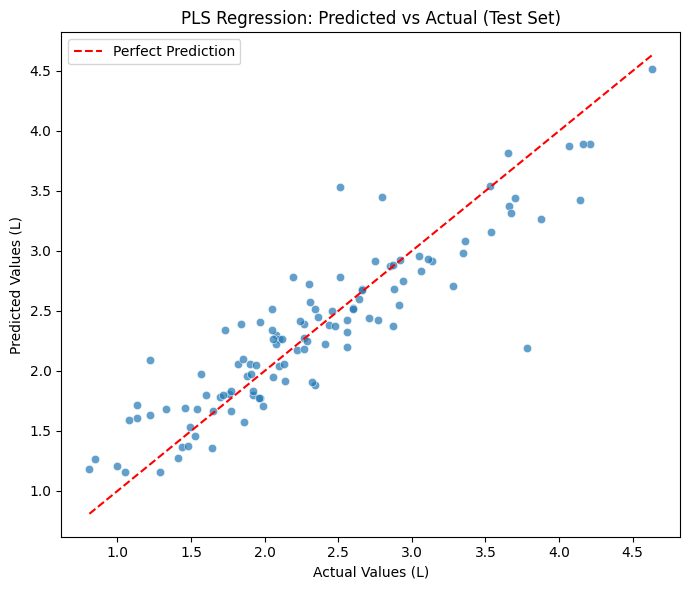


Top 5 patients with largest errors:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
123          2.23        3.78       2.193402   1.586598                0.0   
152          3.63        2.51       3.531763   1.021763                0.0   
233          1.98        1.22       2.090950   0.870950                0.0   
470          4.04        4.14       3.425595   0.714405                0.0   
44           3.44        2.80       3.448464   0.648464                0.0   

     Followup_FVC_Week  
123               51.0  
152               53.0  
233               54.0  
470               53.0  
44                50.0  


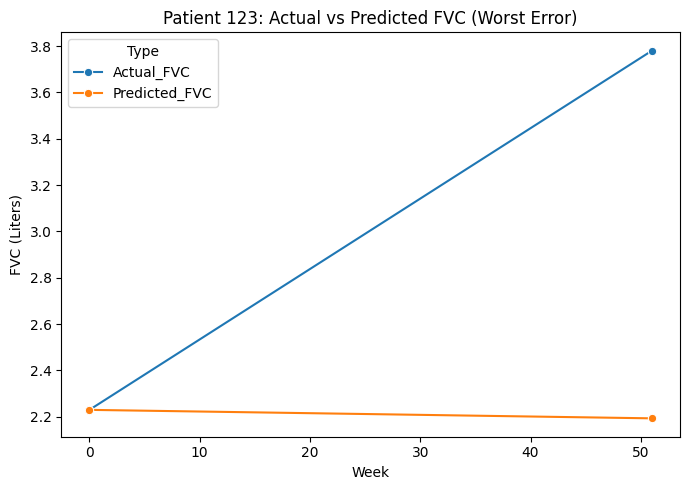

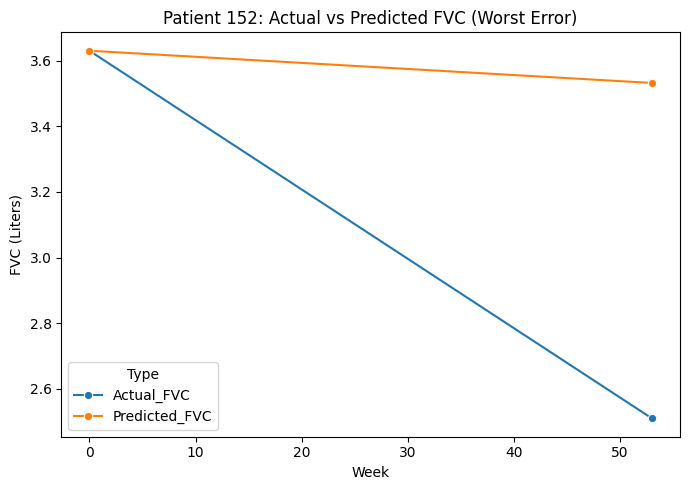

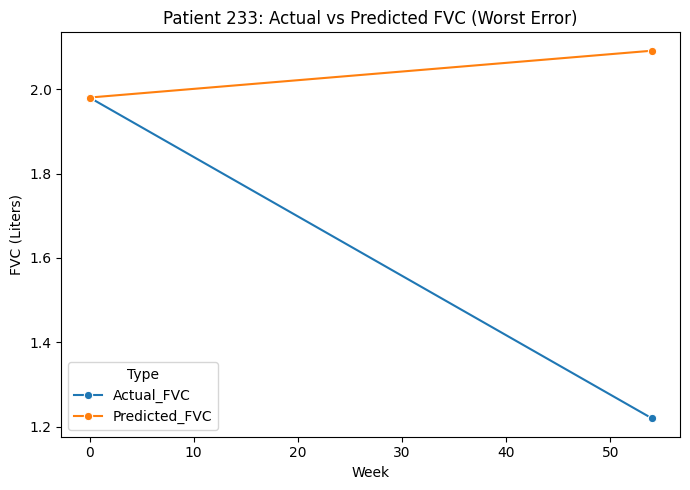

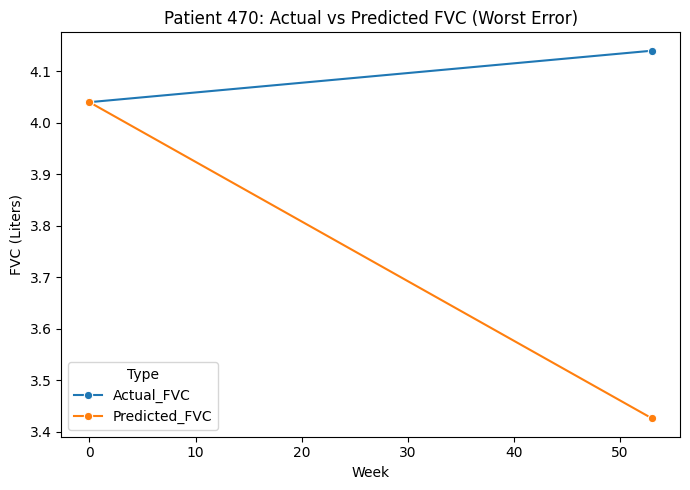

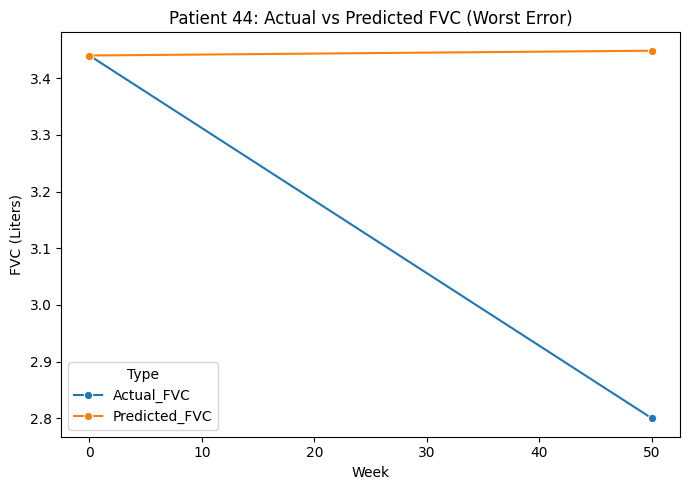


Top 5 patients with increasing FVC and lowest error:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
453          2.87       2.871       2.879375   0.008375                0.0   
514          2.65       2.660       2.676037   0.016037                0.0   
511          1.43       1.490       1.531122   0.041122                0.0   
100          2.35       2.460       2.502329   0.042329                0.0   
4            2.35       2.440       2.381154   0.058846                0.0   

     Followup_FVC_Week  
453               55.0  
514               52.0  
511               54.0  
100               53.0  
4                 51.0  


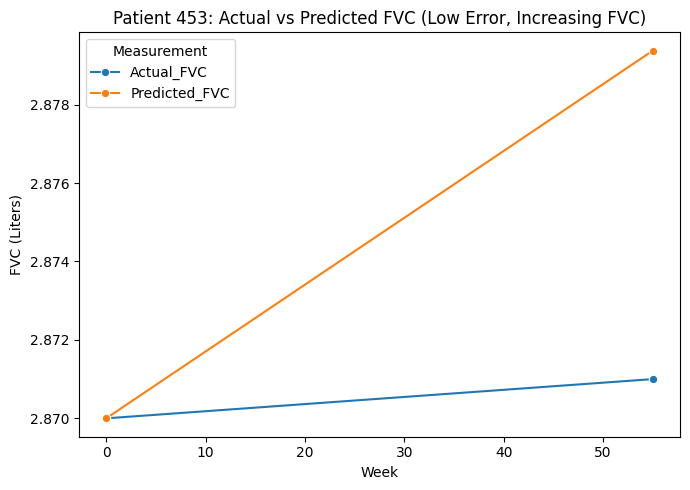

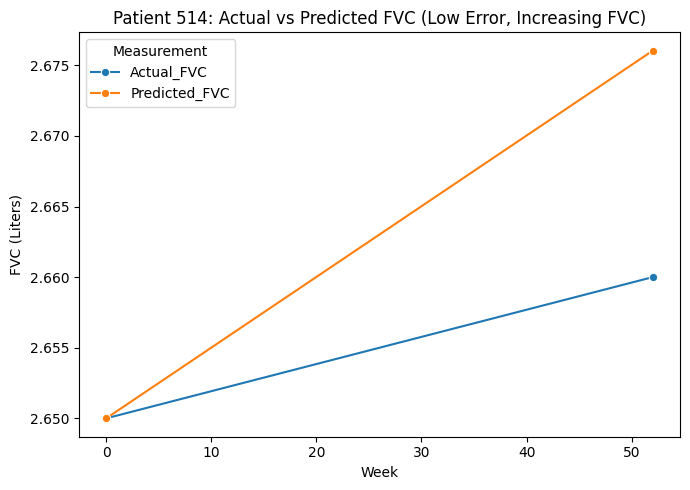

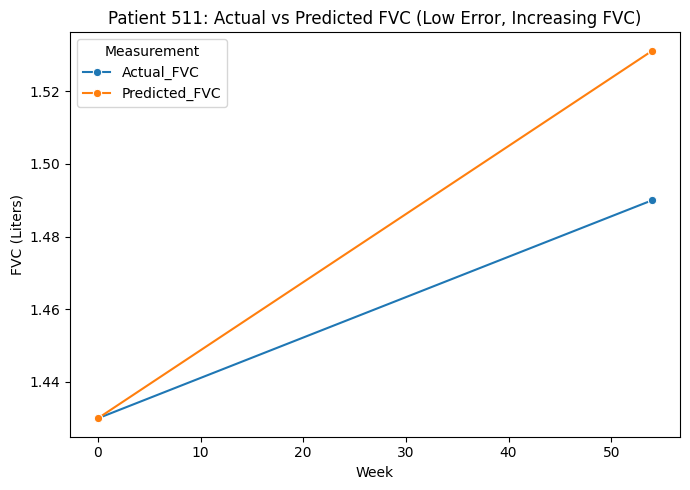

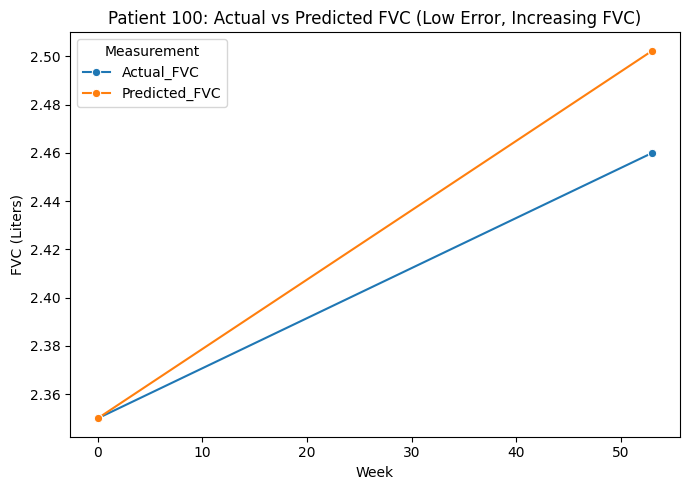

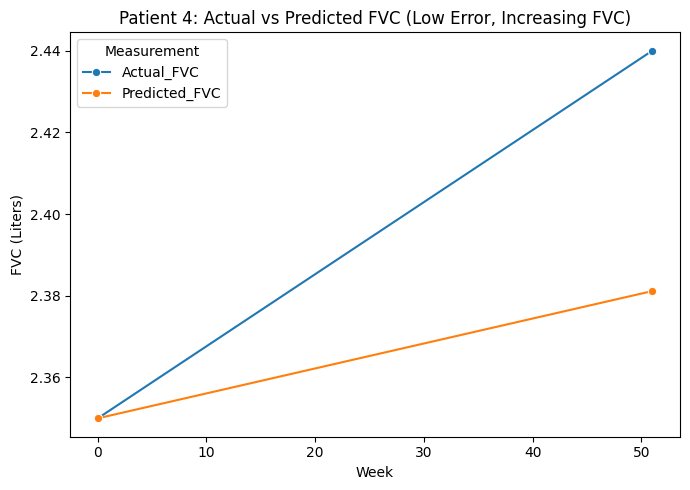

In [5]:
#tested, not good method
selected_features = ['original_firstorder_Kurtosis_right_lung',
       'log-sigma-4-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis_left_lung',
       'wavelet-LHL_glrlm_GrayLevelNonUniformity_right_lung',
       'wavelet-LLL_glrlm_RunLengthNonUniformity_right_lung',
       'log-sigma-2-0-mm-3D_ngtdm_Busyness_left_lung',
       'log-sigma-1-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis_right_lung',
       'wavelet-HHL_glrlm_GrayLevelNonUniformity_right_lung',
       'log-sigma-3-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_right_lung',
       'log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity_left_lung',
       'original_firstorder_MeanAbsoluteDeviation_right_lung',
       'wavelet-LHL_glrlm_GrayLevelNonUniformity_left_lung',
       'log-sigma-4-0-mm-3D_glszm_GrayLevelNonUniformity_right_lung',
       'log-sigma-2-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis_left_lung',
       'original_glrlm_GrayLevelNonUniformity_right_lung',
       'original_firstorder_90Percentile_right_lung',
       'log-sigma-5-0-mm-3D_firstorder_Energy_left_lung',
       'log-sigma-5-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_right_lung',
       'log-sigma-2-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis_right_lung',
       'log-sigma-3-0-mm-3D_glrlm_RunPercentage_left_lung',
       'wavelet-LLL_firstorder_90Percentile_left_lung',
       'wavelet-HLL_glrlm_RunLengthNonUniformity_right_lung',
       'log-sigma-1-0-mm-3D_glszm_ZoneVariance_left_lung',
       'original_shape_MinorAxisLength_left_lung',
       'log-sigma-2-0-mm-3D_ngtdm_Busyness_right_lung',
       'log-sigma-3-0-mm-3D_glrlm_ShortRunEmphasis_left_lung',
       'original_gldm_SmallDependenceHighGrayLevelEmphasis_right_lung',
       'original_glszm_LargeAreaLowGrayLevelEmphasis_left_lung',
       'log-sigma-4-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_left_lung',
       'log-sigma-3-0-mm-3D_glszm_ZoneVariance_right_lung',
       'log-sigma-3-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis_right_lung']
Clinical_Contineous_data_ext = selected_features + Clinical_Contineous_data
print(Clinical_Contineous_data_ext)
X_train, X_test, y_train, y_test = joblib.load("/home/pansurya/OSIC_thesis/radiomics_files/data_splits_clinical_without_harmonization.pkl")
X_train_clini_log = X_train.copy()
X_test_clini_log  = X_test.copy()

# Transform Age
for col in ['Age']:
    X_train_clini_log[col] = np.log(X_train_clini_log[col])
    X_test_clini_log[col] = np.log(X_test_clini_log[col])

# Median imputation (only needed if missing values exist)
imp_median = SimpleImputer(strategy='median')
imp_median.fit(X_train_clini_log)

X_train_median_filled = pd.DataFrame(
    imp_median.transform(X_train_clini_log),
    columns=X_train_clini_log.columns,
    index=X_train_clini_log.index
)

X_test_median_filled = pd.DataFrame(
    imp_median.transform(X_test_clini_log),
    columns=X_test_clini_log.columns,
    index=X_test_clini_log.index
)


# Run experiments
results1 = train_and_evaluate_pls(X_train_median_filled, X_test_median_filled, y_train, y_test, selected_features, Clinical_Contineous_data_ext, Clinical_Categorical_data, 
                                  model_name="/home/pansurya/OSIC_thesis/PLS_model/PAM_ANOVA_VIF_PLS_without_harmonization.pkl")


Hierarchical 

['original_shape_MinorAxisLength_right_lung', 'original_shape_SurfaceArea_left_lung', 'wavelet-LLL_ngtdm_Contrast_right_lung', 'original_glszm_LargeAreaLowGrayLevelEmphasis_right_lung', 'original_gldm_LargeDependenceLowGrayLevelEmphasis_right_lung', 'wavelet-HLL_firstorder_Skewness_right_lung', 'wavelet-HHL_glszm_LargeAreaHighGrayLevelEmphasis_right_lung', 'original_shape_MinorAxisLength_left_lung', 'log-sigma-1-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_left_lung', 'log-sigma-3-0-mm-3D_glrlm_ShortRunEmphasis_left_lung', 'log-sigma-5-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_left_lung', 'Baseline FVC Volume L', 'Age', 'FEV1 Volume L']
Numeric features: ['original_shape_MinorAxisLength_right_lung', 'original_shape_SurfaceArea_left_lung', 'wavelet-LLL_ngtdm_Contrast_right_lung', 'original_glszm_LargeAreaLowGrayLevelEmphasis_right_lung', 'original_gldm_LargeDependenceLowGrayLevelEmphasis_right_lung', 'wavelet-HLL_firstorder_Skewness_right_lung', 'wavelet-HHL_glszm_LargeArea

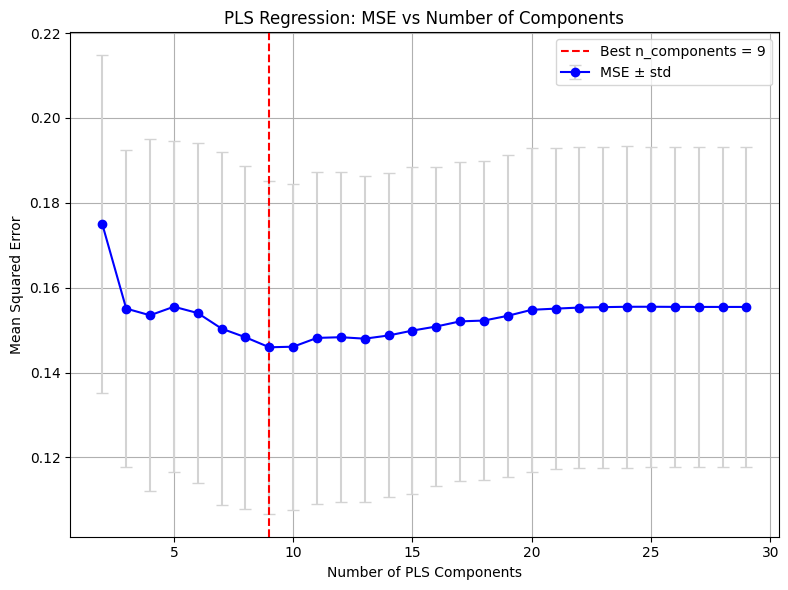


Best number of PLS components: 9

Test set performance (PLS):
- MAE:  0.23 L
- MSE:  0.10 L²
- RMSE: 0.32 L
- R²:   0.843

Training set performance (PLS):
- MAE:  0.24 L
- MSE:  0.13 L²
- RMSE: 0.35 L
- R²:   0.840

PLS coefficients (sorted by |coef|):
                                              Feature  Coefficient
11                              Baseline FVC Volume L     0.696312
14                              Primary Diagnosis_CHP    -0.190962
19                            Primary Diagnosis_INSIP     0.182507
17                 Primary Diagnosis_Exposure-related     0.110598
32                      Smoking History_Active Smoker     0.104175
12                                                Age    -0.067882
7            original_shape_MinorAxisLength_left_lung     0.067382
31                                           Sex_Male     0.061242
30                                         Sex_Female    -0.061242
33                          Smoking History_Ex Smoker    -0.059125
29       

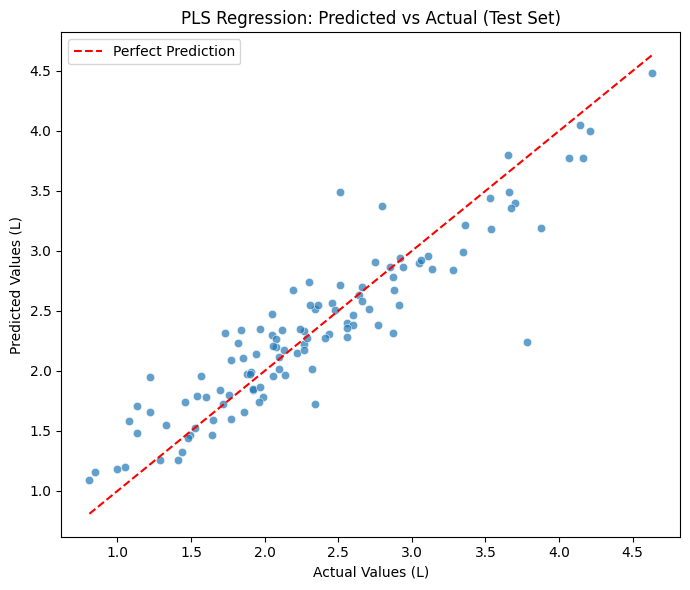


Top 5 patients with largest errors:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
123          2.23        3.78       2.243841   1.536159                0.0   
152          3.63        2.51       3.488606   0.978606                0.0   
233          1.98        1.22       1.951585   0.731585                0.0   
81           3.59        3.88       3.194493   0.685507                0.0   
28           1.89        2.34       1.724207   0.615793                0.0   

     Followup_FVC_Week  
123               51.0  
152               53.0  
233               54.0  
81                52.0  
28                48.0  


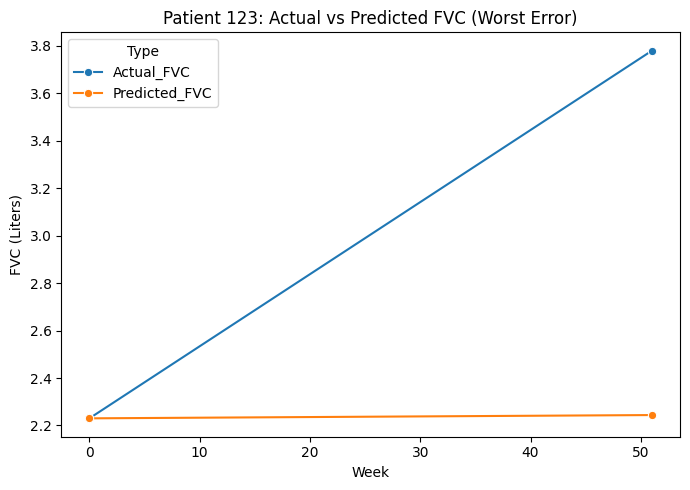

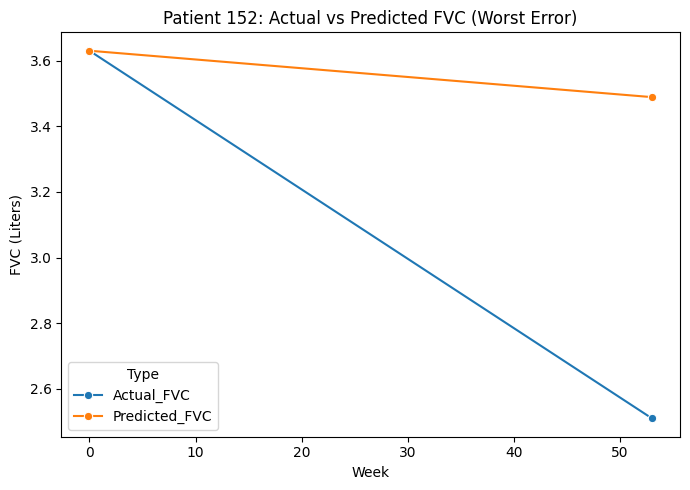

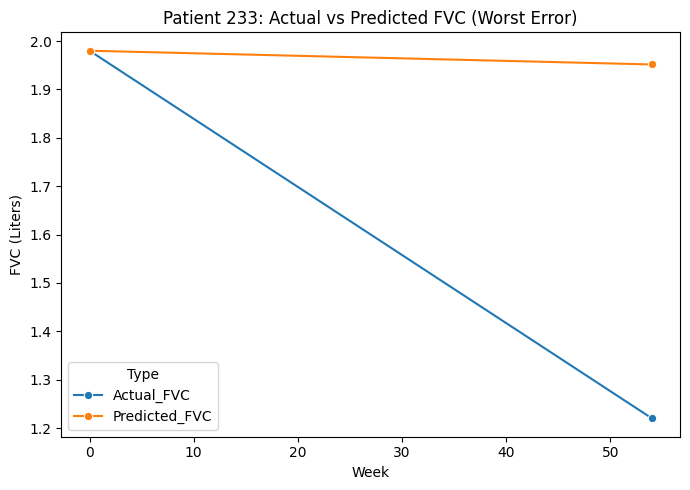

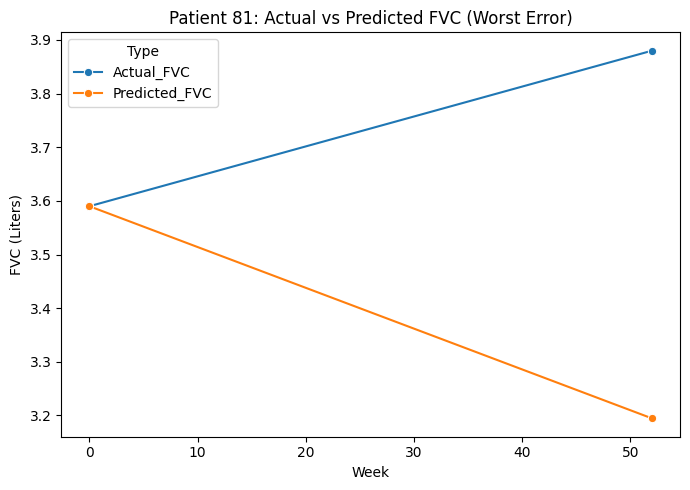

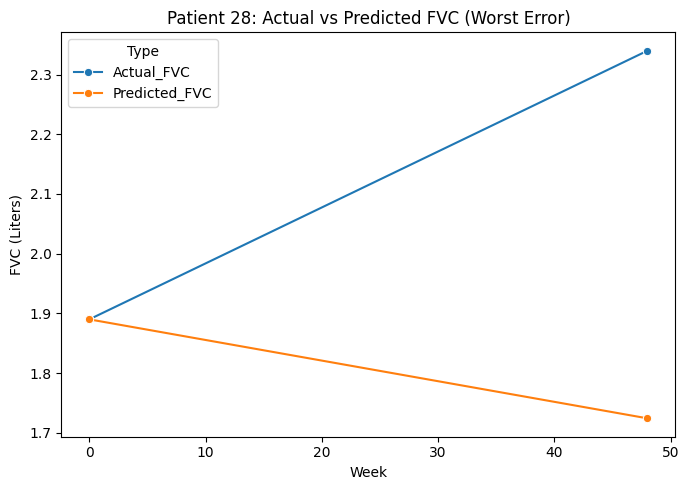


Top 5 patients with increasing FVC and lowest error:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
426          1.66        1.72       1.725872   0.005872                0.0   
511          1.43        1.49       1.463828   0.026172                0.0   
535          1.43        1.48       1.439147   0.040853                0.0   
99           1.81        1.92       1.850232   0.069768                0.0   
514          2.65        2.66       2.586566   0.073434                0.0   

     Followup_FVC_Week  
426               52.0  
511               54.0  
535               55.0  
99                48.0  
514               52.0  


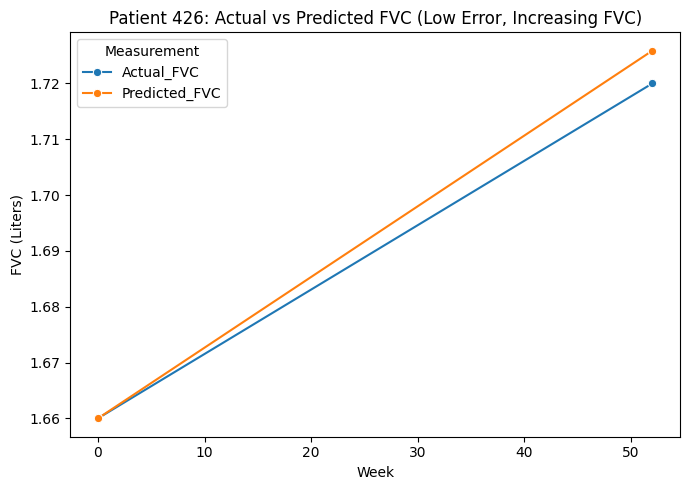

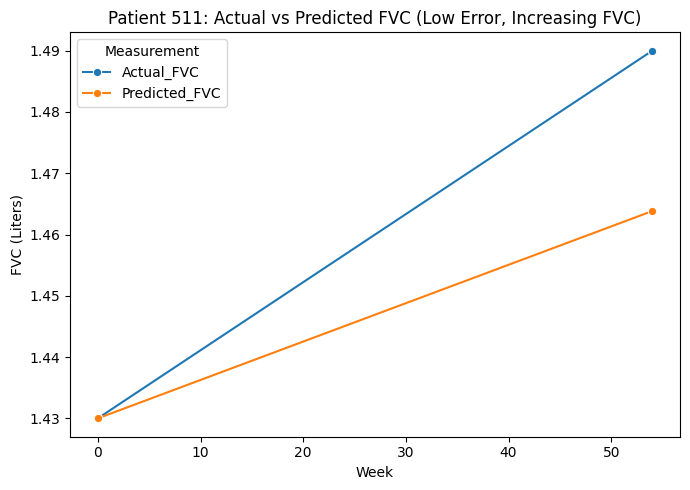

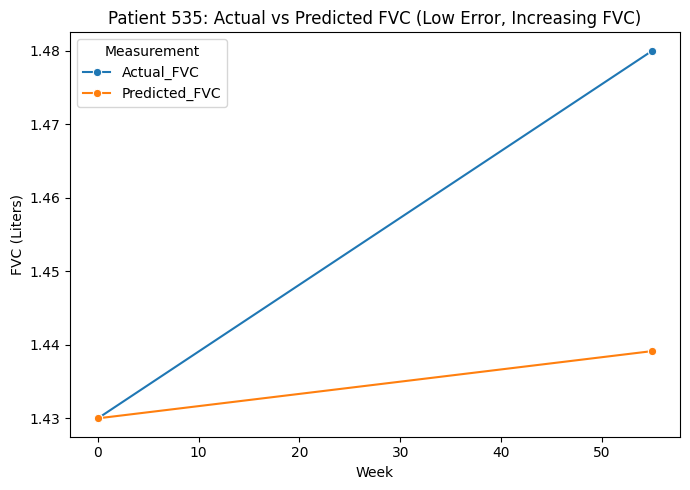

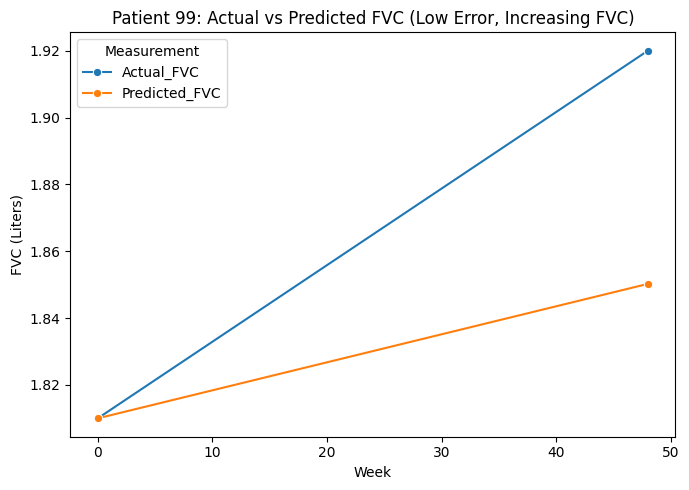

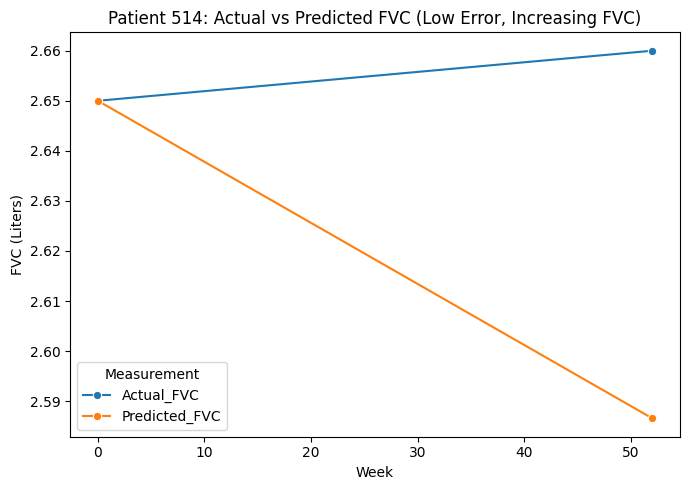

In [6]:
selected_features = ['original_shape_MinorAxisLength_right_lung', 'original_shape_SurfaceArea_left_lung', 'wavelet-LLL_ngtdm_Contrast_right_lung', 'original_glszm_LargeAreaLowGrayLevelEmphasis_right_lung', 'original_gldm_LargeDependenceLowGrayLevelEmphasis_right_lung', 'wavelet-HLL_firstorder_Skewness_right_lung', 'wavelet-HHL_glszm_LargeAreaHighGrayLevelEmphasis_right_lung', 'original_shape_MinorAxisLength_left_lung', 'log-sigma-1-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_left_lung', 'log-sigma-3-0-mm-3D_glrlm_ShortRunEmphasis_left_lung', 'log-sigma-5-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_left_lung']
Clinical_Contineous_data_ext = selected_features + Clinical_Contineous_data
print(Clinical_Contineous_data_ext)
X_train, X_test, y_train, y_test = joblib.load("/home/pansurya/OSIC_thesis/radiomics_files/data_splits_clinical_without_harmonization.pkl")
X_train_clini_log = X_train.copy()
X_test_clini_log  = X_test.copy()

# Transform Age
for col in ['Age']:
    X_train_clini_log[col] = np.log(X_train_clini_log[col])
    X_test_clini_log[col] = np.log(X_test_clini_log[col])

# Median imputation (only needed if missing values exist)
imp_median = SimpleImputer(strategy='median')
imp_median.fit(X_train_clini_log)

X_train_median_filled = pd.DataFrame(
    imp_median.transform(X_train_clini_log),
    columns=X_train_clini_log.columns,
    index=X_train_clini_log.index
)

X_test_median_filled = pd.DataFrame(
    imp_median.transform(X_test_clini_log),
    columns=X_test_clini_log.columns,
    index=X_test_clini_log.index
)
results1 = train_and_evaluate_pls(X_train_median_filled, X_test_median_filled, y_train, y_test, selected_features, Clinical_Contineous_data_ext, Clinical_Categorical_data, 
                                         model_name="/home/pansurya/OSIC_thesis/PLS_model/Hierarchical_ANOVA_VIF_PLS_without_harmonization.pkl")



['original_shape_MinorAxisLength_left_lung', 'wavelet-HHH_glcm_MCC_right_lung', 'wavelet-LLL_glszm_GrayLevelVariance_left_lung', 'original_shape_MinorAxisLength_right_lung', 'wavelet-LHL_glrlm_GrayLevelNonUniformity_right_lung', 'log-sigma-1-0-mm-3D_gldm_GrayLevelNonUniformity_left_lung', 'log-sigma-3-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis_right_lung', 'log-sigma-2-0-mm-3D_ngtdm_Busyness_right_lung', 'log-sigma-2-0-mm-3D_ngtdm_Busyness_left_lung', 'original_firstorder_90Percentile_right_lung', 'log-sigma-3-0-mm-3D_glszm_ZoneVariance_right_lung', 'original_shape_SurfaceArea_left_lung', 'wavelet-HHL_glrlm_GrayLevelNonUniformity_right_lung', 'original_glszm_SmallAreaHighGrayLevelEmphasis_right_lung', 'log-sigma-1-0-mm-3D_ngtdm_Busyness_right_lung', 'log-sigma-1-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_left_lung', 'wavelet-LLH_glrlm_GrayLevelNonUniformity_right_lung', 'wavelet-LHL_firstorder_Kurtosis_right_lung', 'wavelet-LLL_glszm_GrayLevelNonUniformity_right_lung', 'original

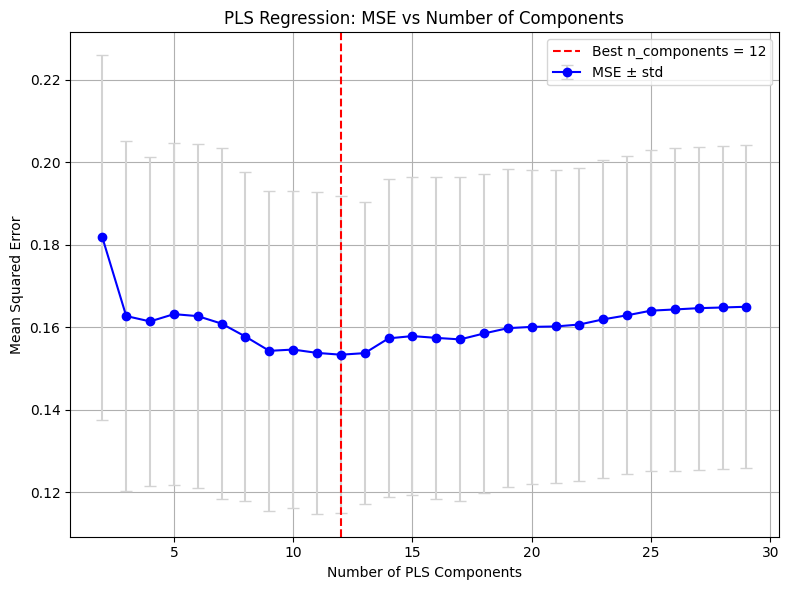


Best number of PLS components: 12

Test set performance (PLS):
- MAE:  0.25 L
- MSE:  0.12 L²
- RMSE: 0.34 L
- R²:   0.816

Training set performance (PLS):
- MAE:  0.24 L
- MSE:  0.12 L²
- RMSE: 0.34 L
- R²:   0.850

PLS coefficients (sorted by |coef|):
                                              Feature  Coefficient
30                              Baseline FVC Volume L     0.710141
33                              Primary Diagnosis_CHP    -0.253662
38                            Primary Diagnosis_INSIP     0.218307
13  original_glszm_SmallAreaHighGrayLevelEmphasis_...     0.135698
16  wavelet-LLH_glrlm_GrayLevelNonUniformity_right...    -0.132982
36                 Primary Diagnosis_Exposure-related     0.122502
9         original_firstorder_90Percentile_right_lung    -0.100188
26  log-sigma-5-0-mm-3D_glrlm_LongRunHighGrayLevel...     0.086814
24  log-sigma-5-0-mm-3D_gldm_LargeDependenceHighGr...    -0.086733
29  log-sigma-1-0-mm-3D_gldm_SmallDependenceLowGra...    -0.082620
51      

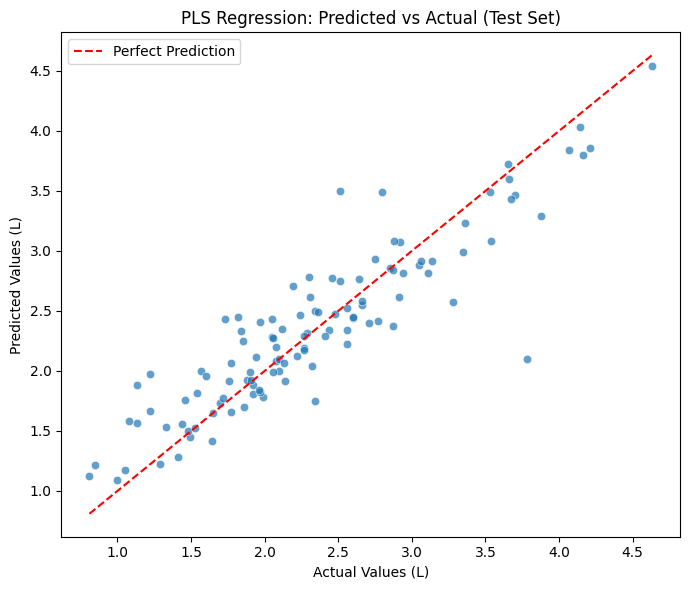


Top 5 patients with largest errors:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
123          2.23        3.78       2.098054   1.681946                0.0   
152          3.63        2.51       3.498700   0.988700                0.0   
368          1.56        1.13       1.885992   0.755992                0.0   
233          1.98        1.22       1.975630   0.755630                0.0   
289          2.94        3.28       2.576061   0.703939                0.0   

     Followup_FVC_Week  
123               51.0  
152               53.0  
368               49.0  
233               54.0  
289               56.0  


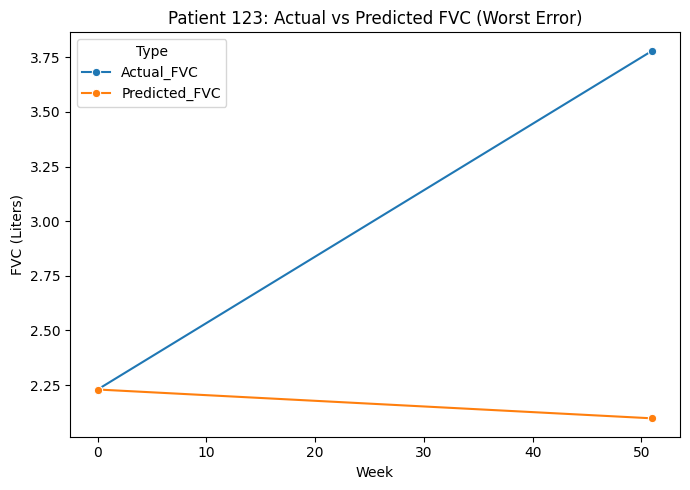

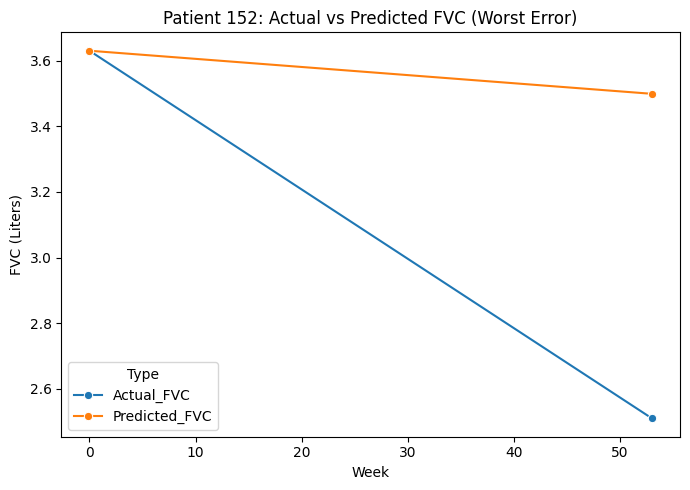

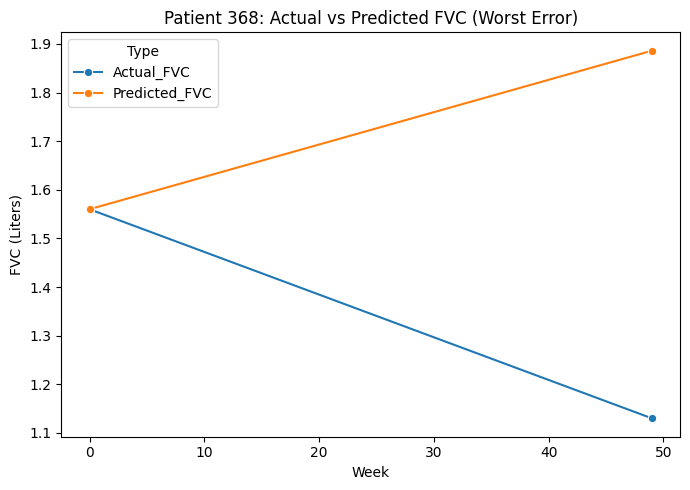

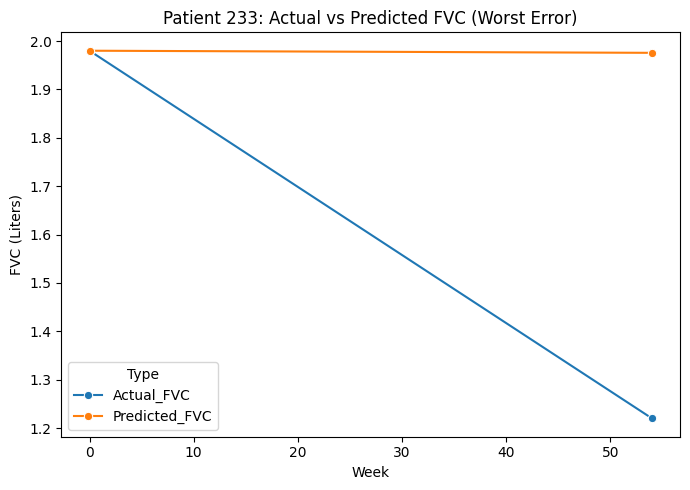

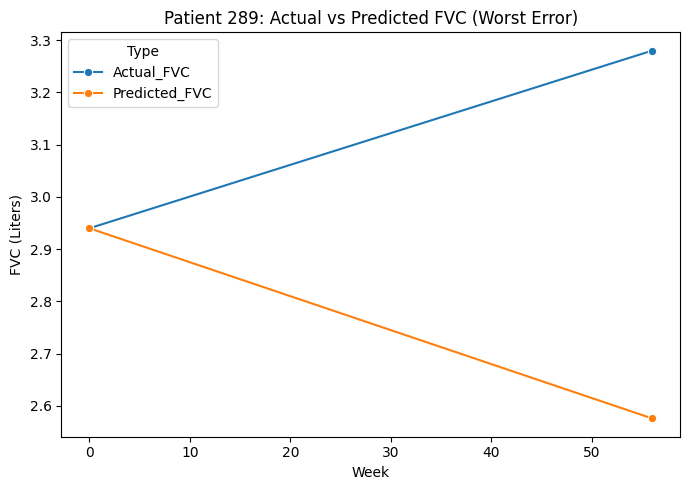


Top 5 patients with increasing FVC and lowest error:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
535          1.43       1.480       1.500093   0.020093                0.0   
453          2.87       2.871       2.840907   0.030093                0.0   
162          1.84       1.920       1.884827   0.035173                0.0   
180          2.43       2.560       2.522213   0.037787                0.0   
511          1.43       1.490       1.449578   0.040422                0.0   

     Followup_FVC_Week  
535               55.0  
453               55.0  
162               48.0  
180               52.0  
511               54.0  


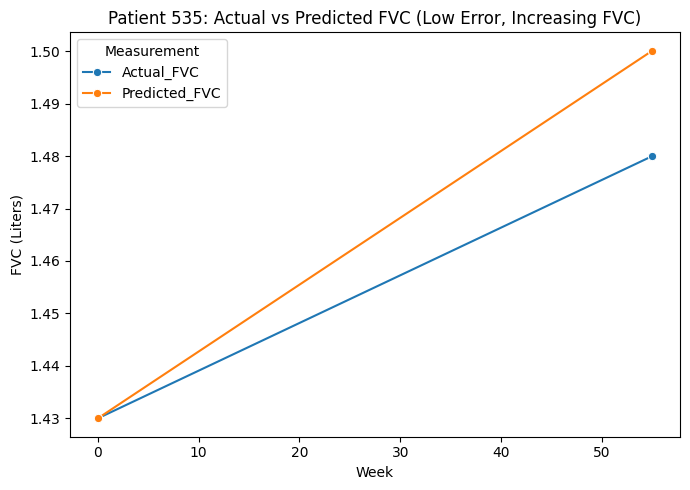

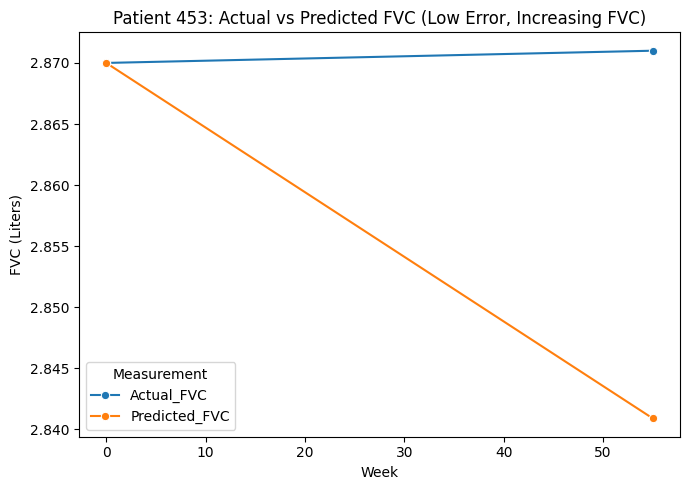

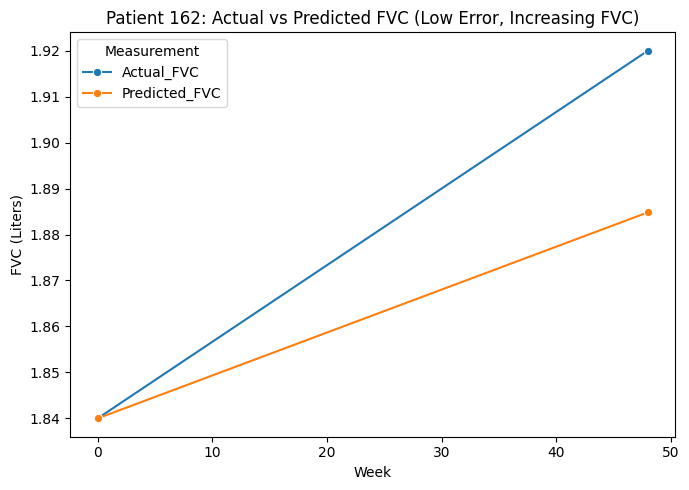

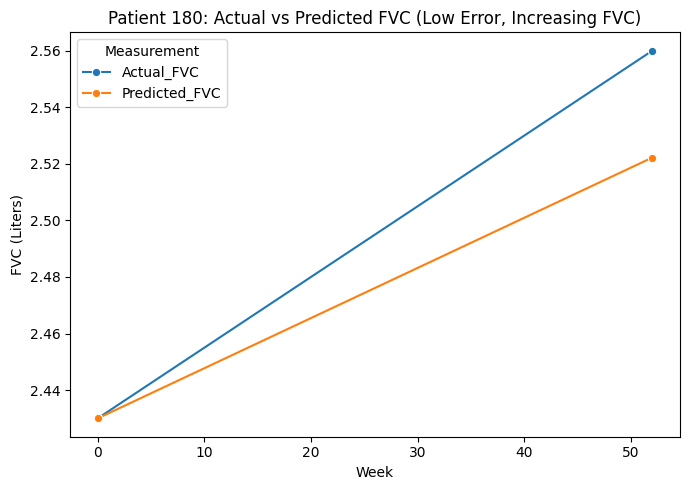

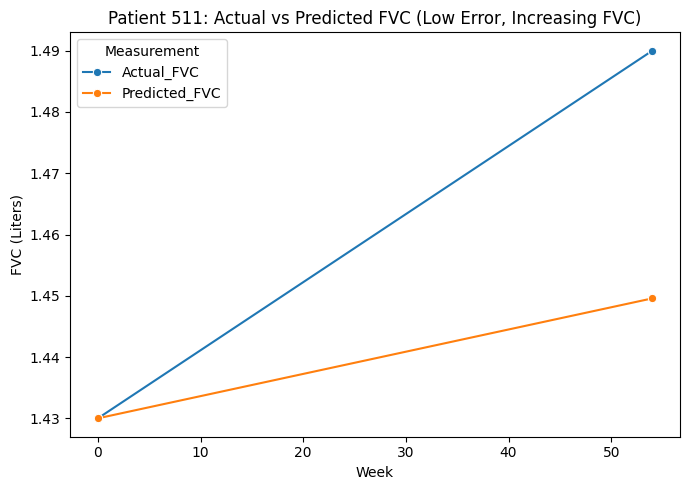

In [11]:
selected_features =['original_shape_MinorAxisLength_left_lung', 'wavelet-HHH_glcm_MCC_right_lung', 'wavelet-LLL_glszm_GrayLevelVariance_left_lung', 'original_shape_MinorAxisLength_right_lung', 'wavelet-LHL_glrlm_GrayLevelNonUniformity_right_lung', 'log-sigma-1-0-mm-3D_gldm_GrayLevelNonUniformity_left_lung', 'log-sigma-3-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis_right_lung', 'log-sigma-2-0-mm-3D_ngtdm_Busyness_right_lung', 'log-sigma-2-0-mm-3D_ngtdm_Busyness_left_lung', 'original_firstorder_90Percentile_right_lung', 'log-sigma-3-0-mm-3D_glszm_ZoneVariance_right_lung', 'original_shape_SurfaceArea_left_lung', 'wavelet-HHL_glrlm_GrayLevelNonUniformity_right_lung', 'original_glszm_SmallAreaHighGrayLevelEmphasis_right_lung', 'log-sigma-1-0-mm-3D_ngtdm_Busyness_right_lung', 'log-sigma-1-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_left_lung', 'wavelet-LLH_glrlm_GrayLevelNonUniformity_right_lung', 'wavelet-LHL_firstorder_Kurtosis_right_lung', 'wavelet-LLL_glszm_GrayLevelNonUniformity_right_lung', 'original_gldm_LargeDependenceLowGrayLevelEmphasis_right_lung', 'wavelet-HLL_glrlm_RunLengthNonUniformity_right_lung', 'original_firstorder_90Percentile_left_lung', 'original_glszm_LargeAreaLowGrayLevelEmphasis_right_lung', 'log-sigma-3-0-mm-3D_glrlm_ShortRunEmphasis_left_lung', 'log-sigma-5-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_left_lung', 'wavelet-LHL_ngtdm_Busyness_right_lung', 'log-sigma-5-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis_left_lung', 'log-sigma-2-0-mm-3D_firstorder_Kurtosis_left_lung', 'wavelet-LLL_ngtdm_Contrast_right_lung', 'log-sigma-1-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis_left_lung']
Clinical_Contineous_data_ext = selected_features + Clinical_Contineous_data
print(Clinical_Contineous_data_ext)
X_train, X_test, y_train, y_test = joblib.load("/home/pansurya/OSIC_thesis/radiomics_files/data_splits_clinical_without_harmonization.pkl")
X_train_clini_log = X_train.copy()
X_test_clini_log  = X_test.copy()

# Transform Age
for col in ['Age']:
    X_train_clini_log[col] = np.log(X_train_clini_log[col])
    X_test_clini_log[col] = np.log(X_test_clini_log[col])

# Median imputation (only needed if missing values exist)
imp_median = SimpleImputer(strategy='median')
imp_median.fit(X_train_clini_log)

X_train_median_filled = pd.DataFrame(
    imp_median.transform(X_train_clini_log),
    columns=X_train_clini_log.columns,
    index=X_train_clini_log.index
)

X_test_median_filled = pd.DataFrame(
    imp_median.transform(X_test_clini_log),
    columns=X_test_clini_log.columns,
    index=X_test_clini_log.index
)
# Run experiments
results1 = train_and_evaluate_pls(X_train_median_filled, X_test_median_filled, y_train, y_test, selected_features, Clinical_Contineous_data_ext, Clinical_Categorical_data, 
                                  model_name="/home/pansurya/OSIC_thesis/PLS_model/Hierarchical_mrmr_VIF_PLS_without_harmonization.pkl")


Correlation-Based Pipelines

['original_shape_MinorAxisLength_right_lung', 'original_shape_SurfaceArea_right_lung', 'original_gldm_LargeDependenceLowGrayLevelEmphasis_right_lung', 'wavelet-HHL_glcm_Idmn_right_lung', 'log-sigma-2-0-mm-3D_firstorder_Median_right_lung', 'log-sigma-3-0-mm-3D_glcm_Idmn_right_lung', 'log-sigma-3-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis_right_lung', 'log-sigma-4-0-mm-3D_glcm_InverseVariance_right_lung', 'original_shape_MinorAxisLength_left_lung', 'log-sigma-1-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis_left_lung', 'Baseline FVC Volume L', 'Age', 'FEV1 Volume L']
Numeric features: ['original_shape_MinorAxisLength_right_lung', 'original_shape_SurfaceArea_right_lung', 'original_gldm_LargeDependenceLowGrayLevelEmphasis_right_lung', 'wavelet-HHL_glcm_Idmn_right_lung', 'log-sigma-2-0-mm-3D_firstorder_Median_right_lung', 'log-sigma-3-0-mm-3D_glcm_Idmn_right_lung', 'log-sigma-3-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis_right_lung', 'log-sigma-4-0-mm-3D_glcm_InverseVariance_right_lung',

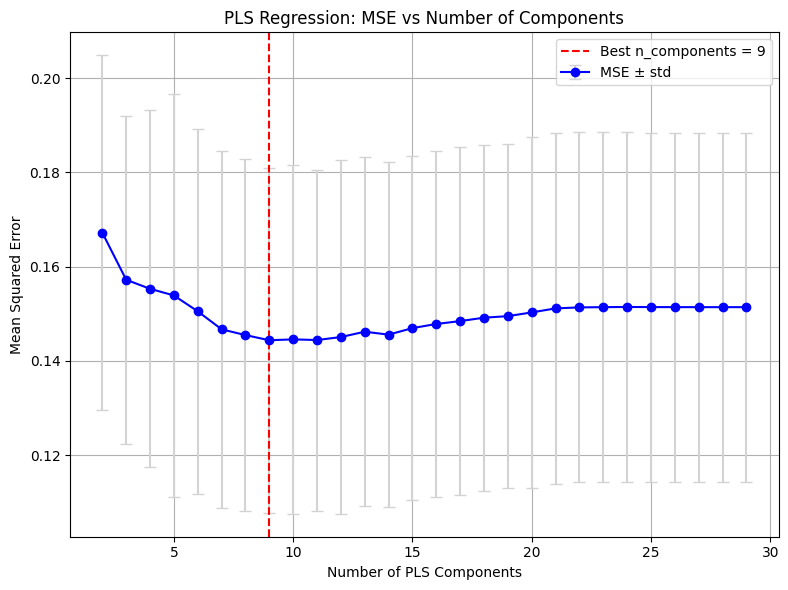


Best number of PLS components: 9

Test set performance (PLS):
- MAE:  0.23 L
- MSE:  0.10 L²
- RMSE: 0.32 L
- R²:   0.839

Training set performance (PLS):
- MAE:  0.24 L
- MSE:  0.12 L²
- RMSE: 0.35 L
- R²:   0.841

PLS coefficients (sorted by |coef|):
                                              Feature  Coefficient
10                              Baseline FVC Volume L     0.719242
13                              Primary Diagnosis_CHP    -0.199166
18                            Primary Diagnosis_INSIP     0.174412
5            log-sigma-3-0-mm-3D_glcm_Idmn_right_lung    -0.113212
31                      Smoking History_Active Smoker     0.110635
16                 Primary Diagnosis_Exposure-related     0.107707
11                                                Age    -0.070739
28                             Primary Diagnosis_UILD    -0.063320
8            original_shape_MinorAxisLength_left_lung     0.059043
33                       Smoking History_Never Smoker    -0.057755
9   log-s

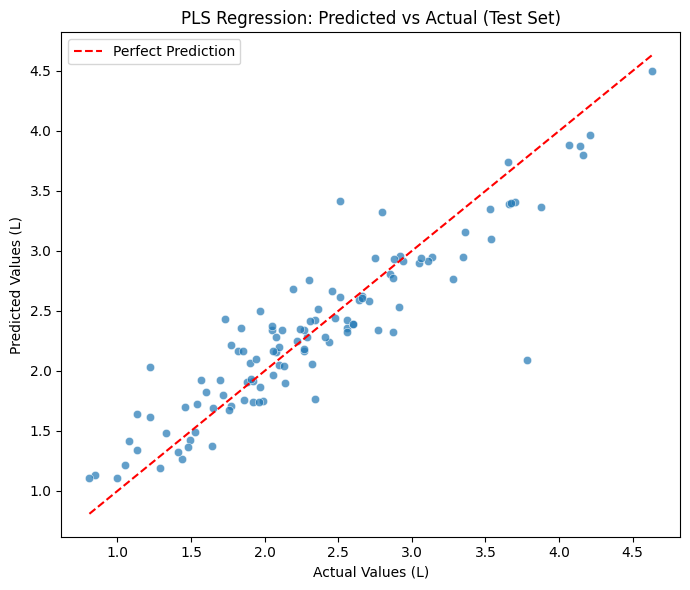


Top 5 patients with largest errors:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
123          2.23        3.78       2.093821   1.686179                0.0   
152          3.63        2.51       3.415812   0.905812                0.0   
233          1.98        1.22       2.031355   0.811355                0.0   
326          2.37        1.73       2.432183   0.702183                0.0   
28           1.89        2.34       1.766818   0.573182                0.0   

     Followup_FVC_Week  
123               51.0  
152               53.0  
233               54.0  
326               56.0  
28                48.0  


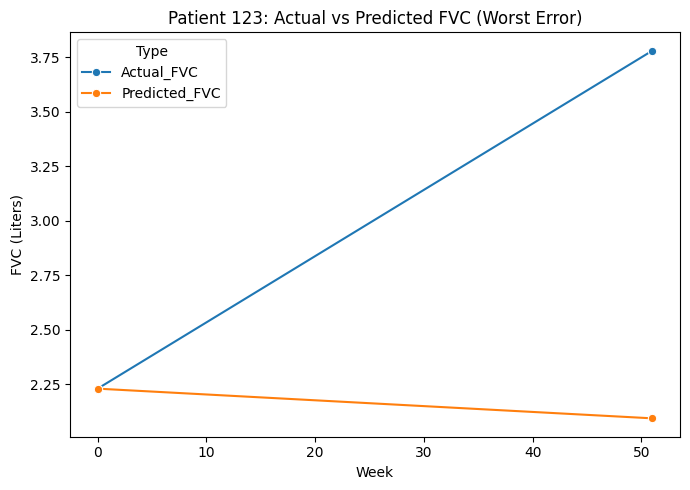

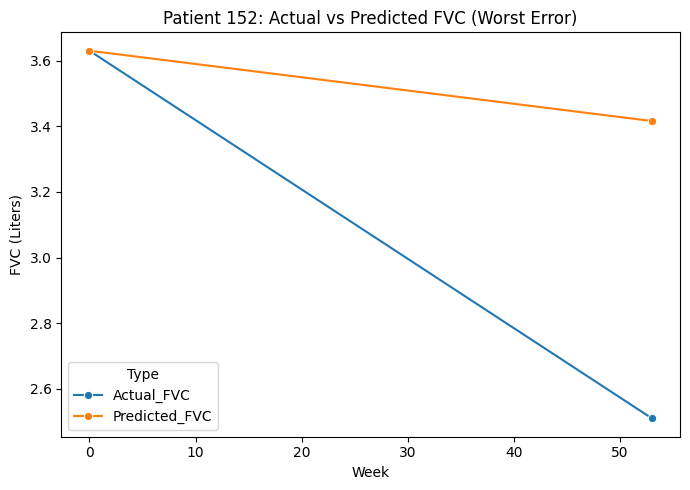

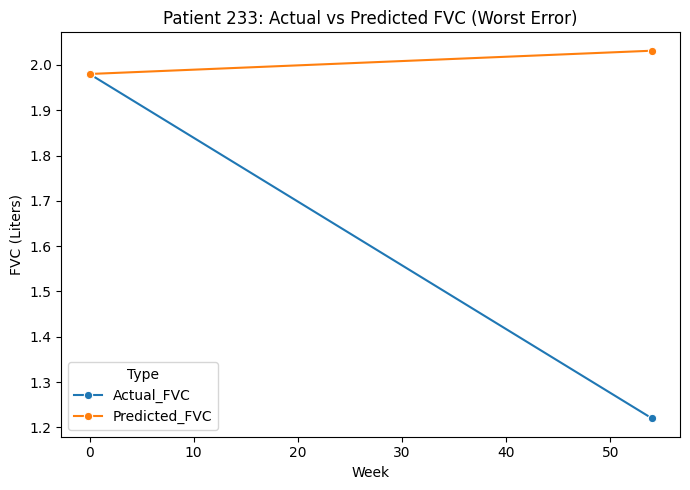

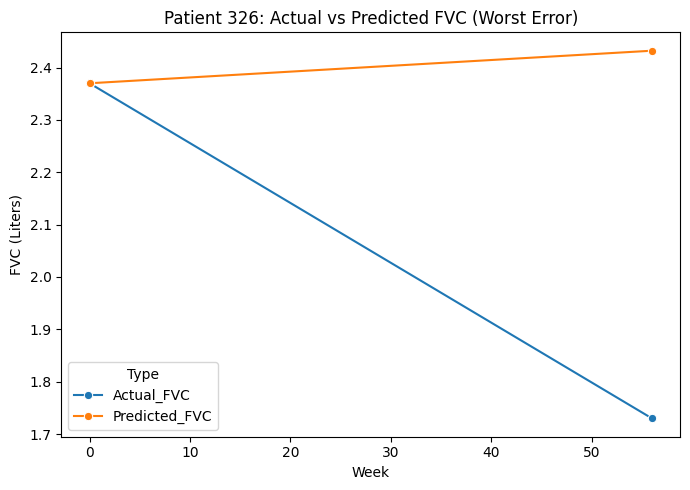

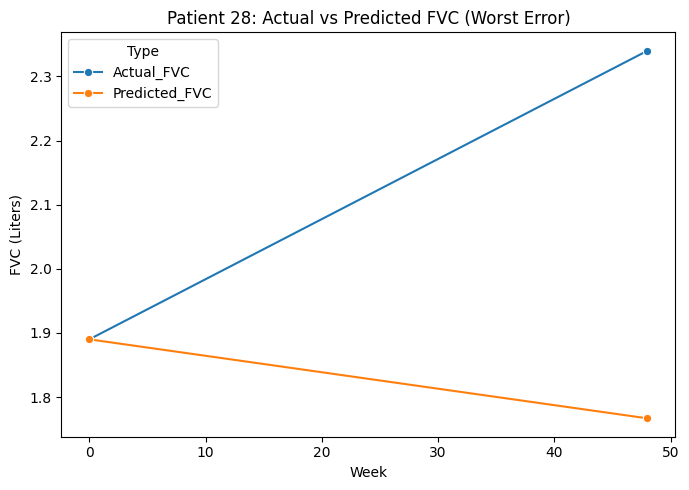


Top 5 patients with increasing FVC and lowest error:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
162          1.84        1.92       1.913873   0.006127                0.0   
514          2.65        2.66       2.609290   0.050710                0.0   
107          2.81        2.88       2.933439   0.053439                0.0   
511          1.43        1.49       1.425983   0.064017                0.0   
426          1.66        1.72       1.800690   0.080690                0.0   

     Followup_FVC_Week  
162               48.0  
514               52.0  
107               54.0  
511               54.0  
426               52.0  


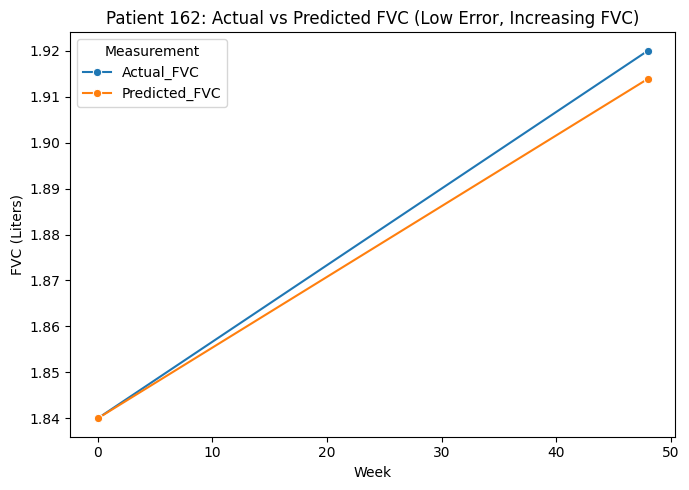

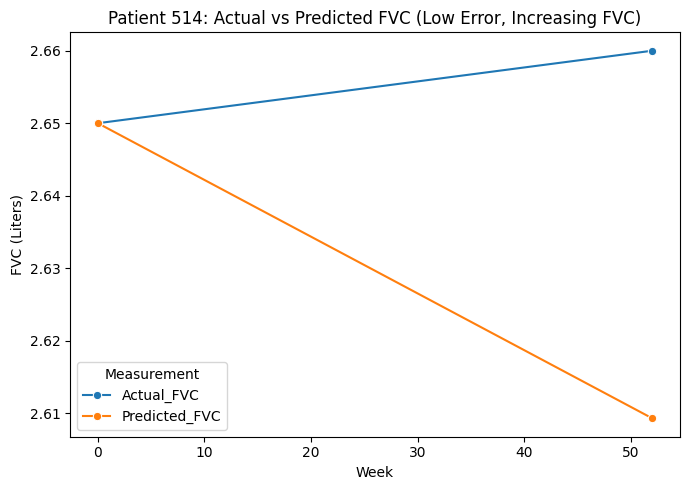

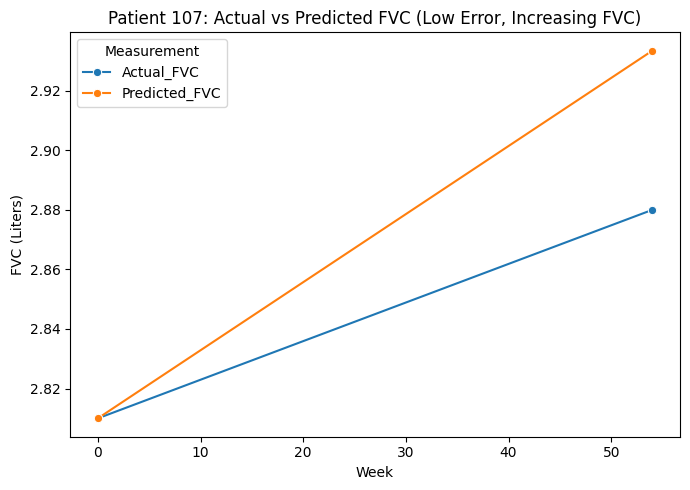

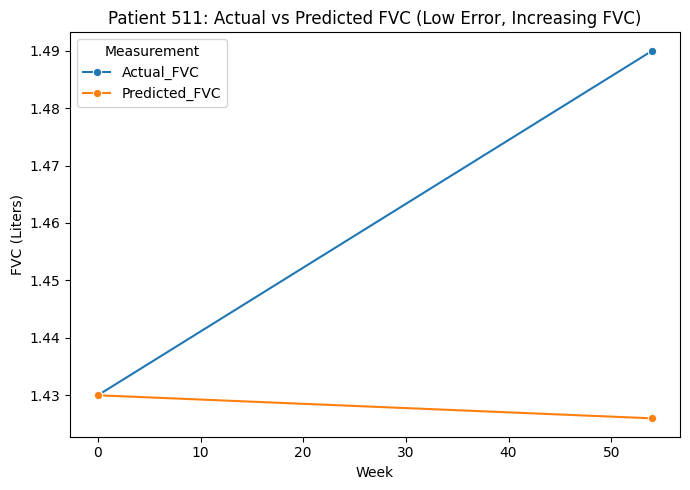

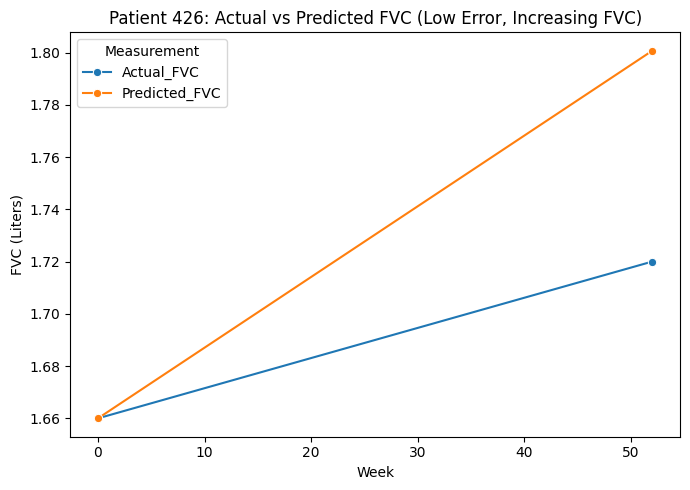

In [12]:
selected_features = ['original_shape_MinorAxisLength_right_lung', 'original_shape_SurfaceArea_right_lung', 'original_gldm_LargeDependenceLowGrayLevelEmphasis_right_lung', 'wavelet-HHL_glcm_Idmn_right_lung', 'log-sigma-2-0-mm-3D_firstorder_Median_right_lung', 'log-sigma-3-0-mm-3D_glcm_Idmn_right_lung', 'log-sigma-3-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis_right_lung', 'log-sigma-4-0-mm-3D_glcm_InverseVariance_right_lung', 'original_shape_MinorAxisLength_left_lung', 'log-sigma-1-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis_left_lung']
Clinical_Contineous_data_ext = selected_features + Clinical_Contineous_data
print(Clinical_Contineous_data_ext)
X_train, X_test, y_train, y_test = joblib.load("/home/pansurya/OSIC_thesis/radiomics_files/data_splits_clinical_without_harmonization.pkl")
X_train_clini_log = X_train.copy()
X_test_clini_log  = X_test.copy()

# Transform Age
for col in ['Age']:
    X_train_clini_log[col] = np.log(X_train_clini_log[col])
    X_test_clini_log[col] = np.log(X_test_clini_log[col])

# Median imputation (only needed if missing values exist)
imp_median = SimpleImputer(strategy='median')
imp_median.fit(X_train_clini_log)

X_train_median_filled = pd.DataFrame(
    imp_median.transform(X_train_clini_log),
    columns=X_train_clini_log.columns,
    index=X_train_clini_log.index
)

X_test_median_filled = pd.DataFrame(
    imp_median.transform(X_test_clini_log),
    columns=X_test_clini_log.columns,
    index=X_test_clini_log.index
)
results1 = train_and_evaluate_pls(X_train_median_filled, X_test_median_filled, y_train, y_test, selected_features, Clinical_Contineous_data_ext, Clinical_Categorical_data, 
                                         model_name="/home/pansurya/OSIC_thesis/PLS_model/Correlation_based_Using_Target_FVC_PLS_without_harmonization.pkl")


['original_shape_MinorAxisLength_left_lung', 'wavelet-HLH_gldm_DependenceNonUniformityNormalized_right_lung', 'log-sigma-2-0-mm-3D_firstorder_10Percentile_right_lung', 'original_shape_MinorAxisLength_right_lung', 'wavelet-HHL_glcm_Idmn_right_lung', 'original_shape_SurfaceArea_right_lung', 'original_gldm_LargeDependenceLowGrayLevelEmphasis_right_lung', 'log-sigma-3-0-mm-3D_glcm_InverseVariance_right_lung', 'log-sigma-2-0-mm-3D_firstorder_Kurtosis_left_lung', 'log-sigma-1-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis_right_lung', 'log-sigma-3-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis_right_lung', 'log-sigma-1-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis_left_lung', 'log-sigma-4-0-mm-3D_glcm_InverseVariance_right_lung', 'wavelet-LHL_glcm_Idmn_left_lung', 'log-sigma-1-0-mm-3D_firstorder_Skewness_left_lung', 'wavelet-HLL_firstorder_Kurtosis_left_lung', 'Baseline FVC Volume L', 'Age', 'FEV1 Volume L']
Numeric features: ['original_shape_MinorAxisLength_left_lung', 'wavelet-HLH_gldm_Depende

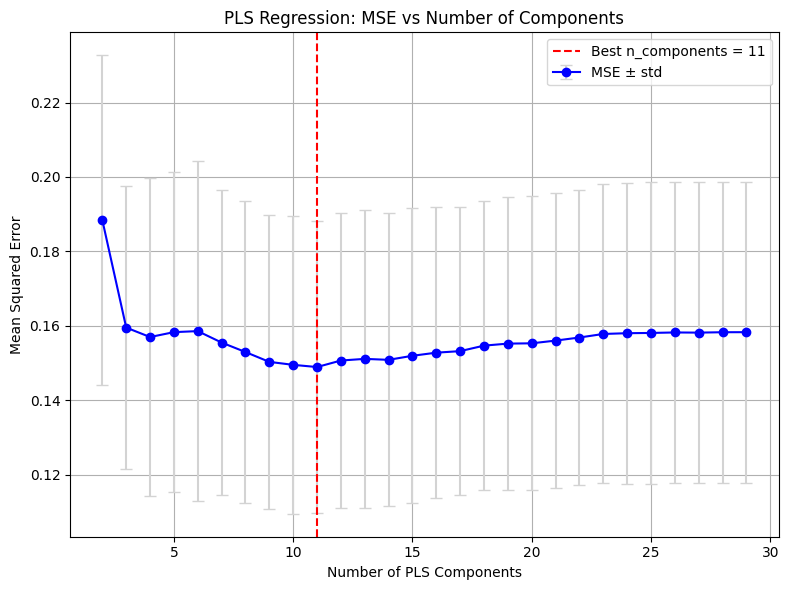


Best number of PLS components: 11

Test set performance (PLS):
- MAE:  0.23 L
- MSE:  0.10 L²
- RMSE: 0.32 L
- R²:   0.838

Training set performance (PLS):
- MAE:  0.24 L
- MSE:  0.12 L²
- RMSE: 0.35 L
- R²:   0.844

PLS coefficients (sorted by |coef|):
                                              Feature  Coefficient
16                              Baseline FVC Volume L     0.698585
24                            Primary Diagnosis_INSIP     0.247677
19                              Primary Diagnosis_CHP    -0.211428
22                 Primary Diagnosis_Exposure-related     0.148408
8   log-sigma-2-0-mm-3D_firstorder_Kurtosis_left_lung    -0.121465
37                      Smoking History_Active Smoker     0.110721
14  log-sigma-1-0-mm-3D_firstorder_Skewness_left_lung    -0.087700
34                             Primary Diagnosis_UILD    -0.078535
35                                         Sex_Female    -0.074435
36                                           Sex_Male     0.074435
23      

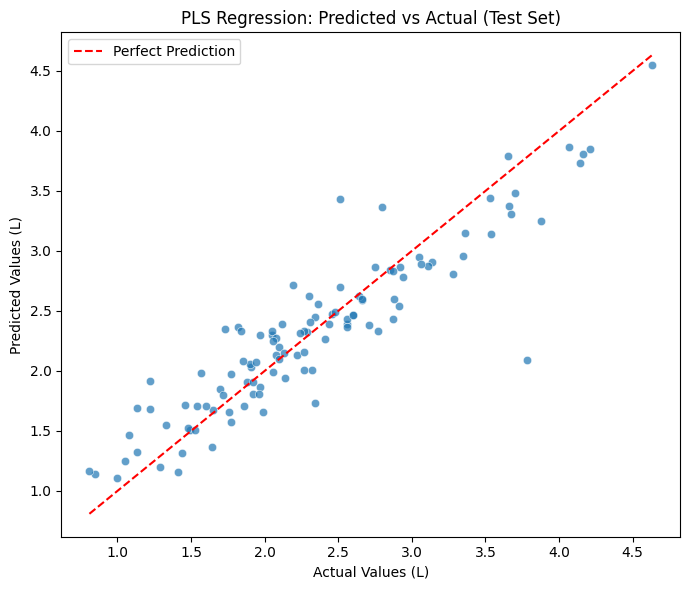


Top 5 patients with largest errors:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
123          2.23        3.78       2.092684   1.687316                0.0   
152          3.63        2.51       3.435735   0.925735                0.0   
233          1.98        1.22       1.918748   0.698748                0.0   
81           3.59        3.88       3.252876   0.627124                0.0   
326          2.37        1.73       2.350471   0.620471                0.0   

     Followup_FVC_Week  
123               51.0  
152               53.0  
233               54.0  
81                52.0  
326               56.0  


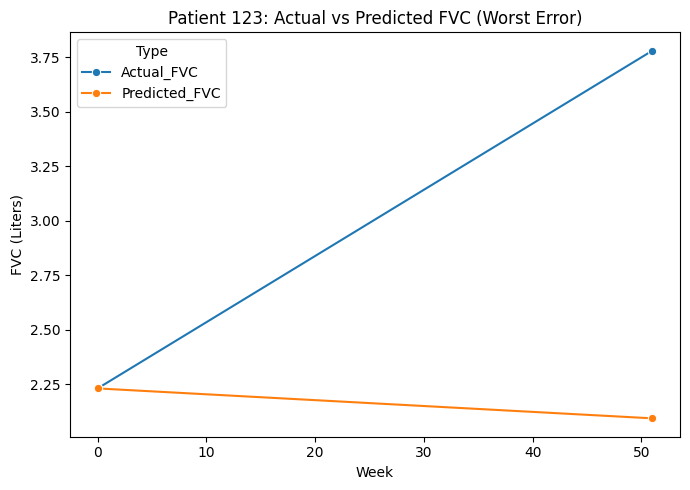

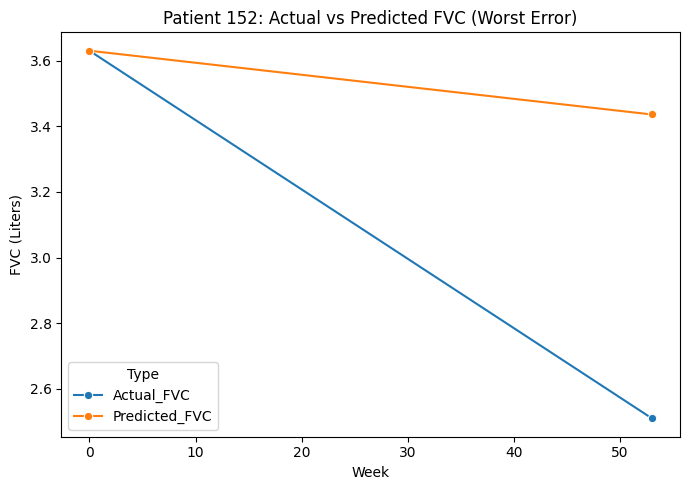

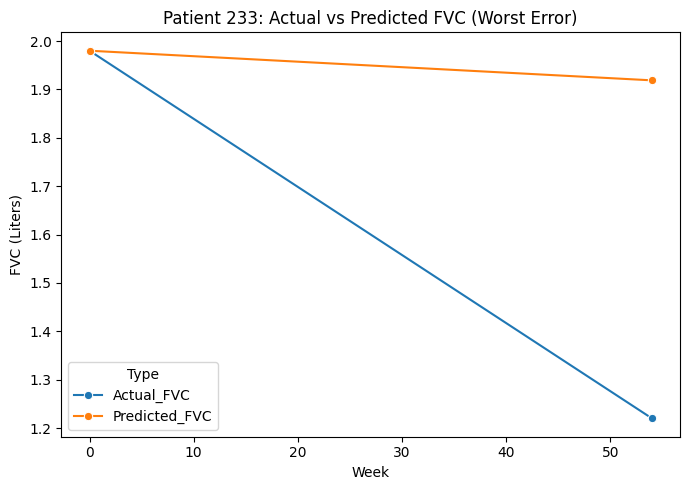

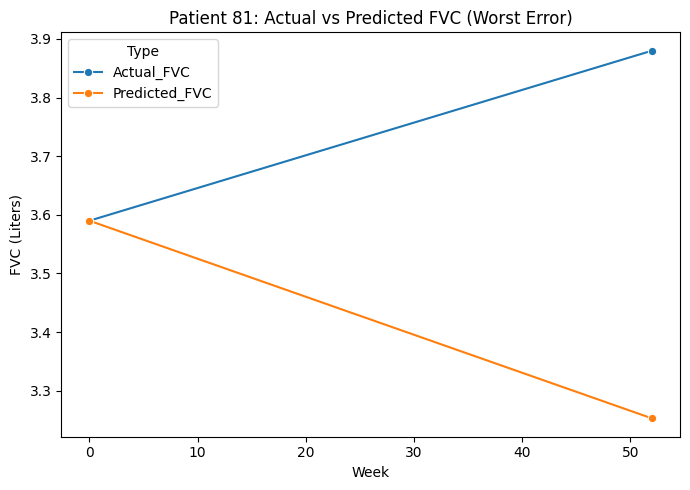

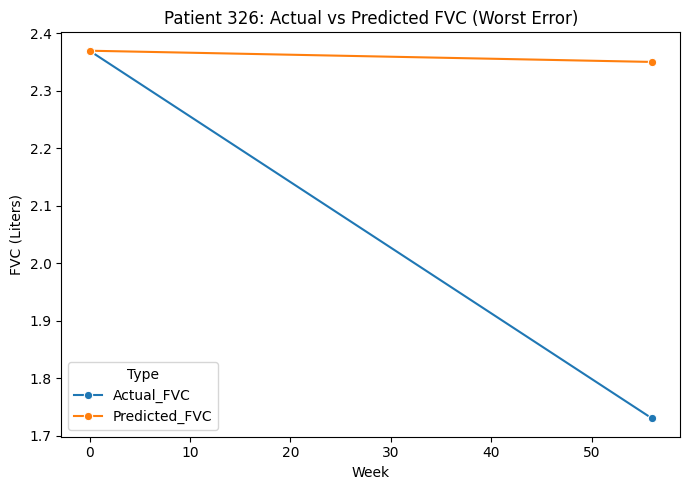


Top 5 patients with increasing FVC and lowest error:
     Baseline_FVC  Target_FVC  Predicted_FVC  Abs_Error  Baseline_FVC_Week  \
162          1.84       1.920       1.912066   0.007934                0.0   
511          1.43       1.490       1.504080   0.014080                0.0   
100          2.35       2.460       2.477679   0.017679                0.0   
453          2.87       2.871       2.836072   0.034929                0.0   
4            2.35       2.440       2.394490   0.045510                0.0   

     Followup_FVC_Week  
162               48.0  
511               54.0  
100               53.0  
453               55.0  
4                 51.0  


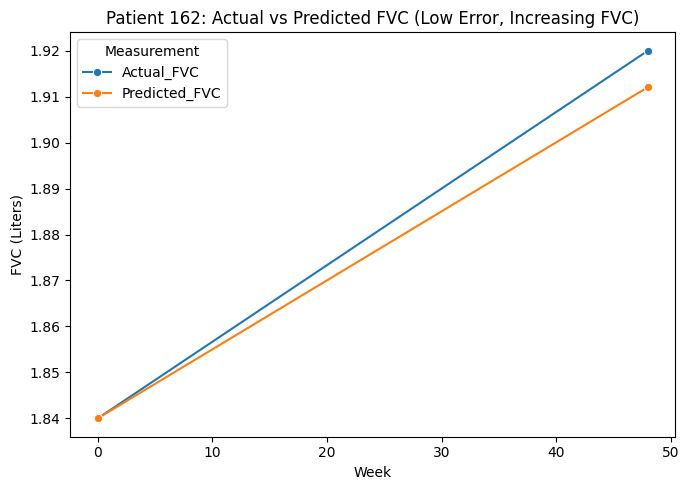

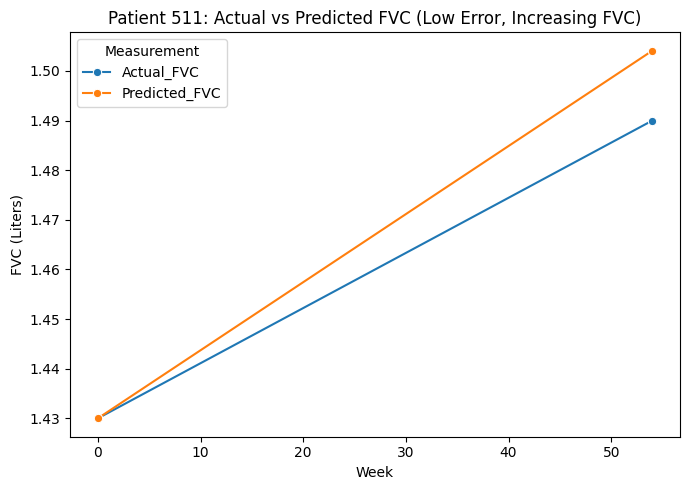

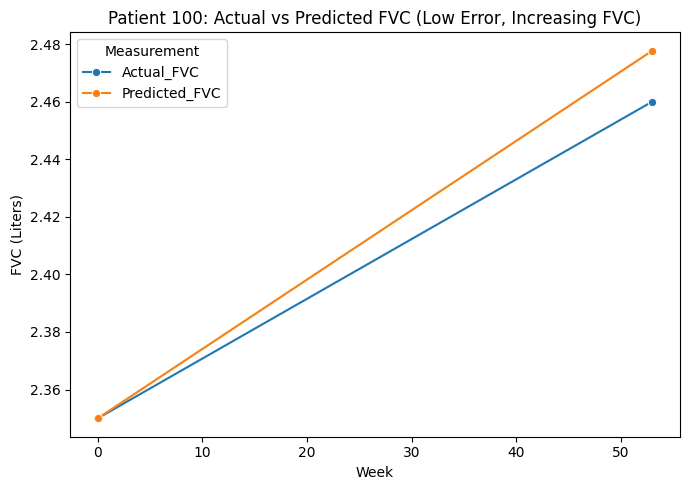

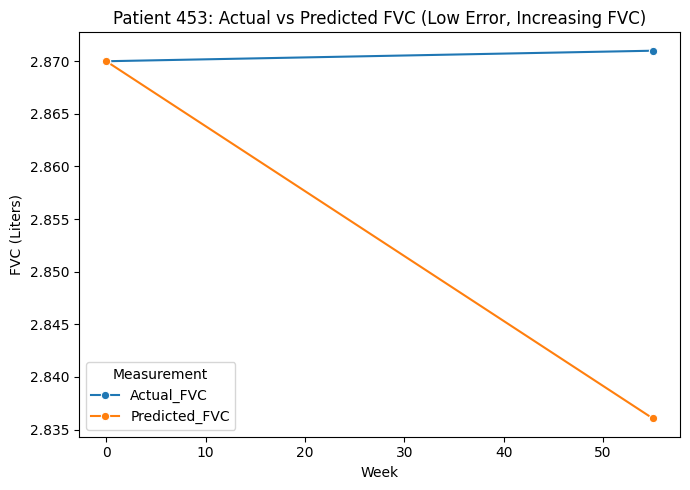

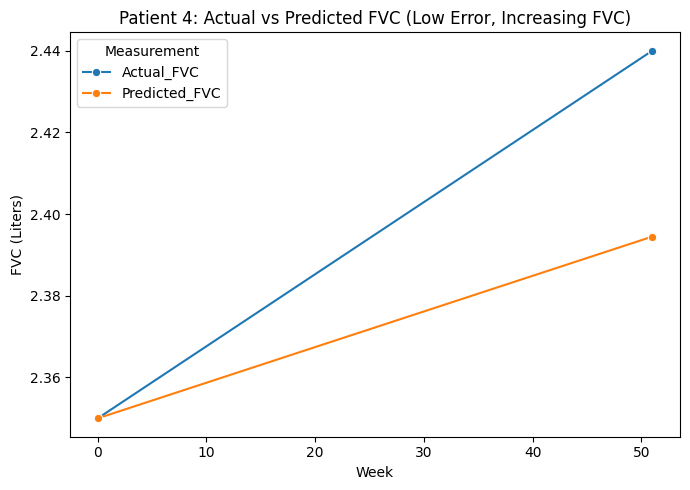

In [13]:
selected_features = ['original_shape_MinorAxisLength_left_lung', 'wavelet-HLH_gldm_DependenceNonUniformityNormalized_right_lung', 'log-sigma-2-0-mm-3D_firstorder_10Percentile_right_lung', 'original_shape_MinorAxisLength_right_lung', 'wavelet-HHL_glcm_Idmn_right_lung', 'original_shape_SurfaceArea_right_lung', 'original_gldm_LargeDependenceLowGrayLevelEmphasis_right_lung', 'log-sigma-3-0-mm-3D_glcm_InverseVariance_right_lung', 'log-sigma-2-0-mm-3D_firstorder_Kurtosis_left_lung', 'log-sigma-1-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis_right_lung', 'log-sigma-3-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis_right_lung', 'log-sigma-1-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis_left_lung', 'log-sigma-4-0-mm-3D_glcm_InverseVariance_right_lung', 'wavelet-LHL_glcm_Idmn_left_lung', 'log-sigma-1-0-mm-3D_firstorder_Skewness_left_lung', 'wavelet-HLL_firstorder_Kurtosis_left_lung']
Clinical_Contineous_data_ext = selected_features + Clinical_Contineous_data
print(Clinical_Contineous_data_ext)
X_train, X_test, y_train, y_test = joblib.load("/home/pansurya/OSIC_thesis/radiomics_files/data_splits_clinical_without_harmonization.pkl")
X_train_clini_log = X_train.copy()
X_test_clini_log  = X_test.copy()

# Transform Age
for col in ['Age']:
    X_train_clini_log[col] = np.log(X_train_clini_log[col])
    X_test_clini_log[col] = np.log(X_test_clini_log[col])

# Median imputation (only needed if missing values exist)
imp_median = SimpleImputer(strategy='median')
imp_median.fit(X_train_clini_log)

X_train_median_filled = pd.DataFrame(
    imp_median.transform(X_train_clini_log),
    columns=X_train_clini_log.columns,
    index=X_train_clini_log.index
)

X_test_median_filled = pd.DataFrame(
    imp_median.transform(X_test_clini_log),
    columns=X_test_clini_log.columns,
    index=X_test_clini_log.index
)


# Run experiments
results1 = train_and_evaluate_pls(X_train_median_filled, X_test_median_filled, y_train, y_test, selected_features, Clinical_Contineous_data_ext, Clinical_Categorical_data, 
                                         model_name="/home/pansurya/OSIC_thesis/PLS_model/Correlation_based_Using_mrmr_PLS_without_harmonization.pkl")

##Other things

/tmp/ipykernel_3251776/1951600055.py:46: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=melted, x="Metric", y="Value", hue="Model",


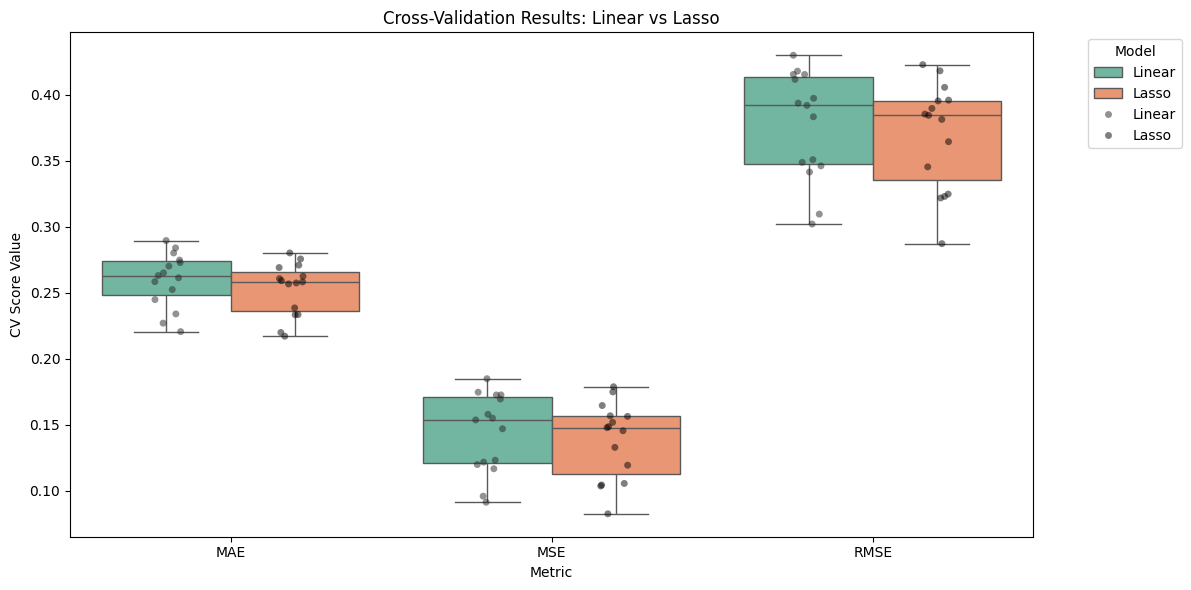

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Linear model CV results (15 folds)
# ------------------------------
linear_data = {
    "RepeatFold": list(range(1, 16)),
'MAE': [0.26295306171150423, 0.25236078861666833, 0.27276023364192753, 0.23388352193766943, 0.2649739889182695, 0.2746773690750782, 0.2839014819541063, 0.22044785304343154, 0.2447320561017776, 0.2894733957827127, 0.26124071150463324, 0.28003895864310846, 0.22688404625326866, 0.2700772622503131, 0.25833511052731467],
'MSE': [0.15491894290453037, 0.11975374368877044, 0.17251037388003468, 0.12160248798585387, 0.14687756201990482, 0.17248454245086872, 0.16938886151066385, 0.09577973781411005, 0.11656507698031575, 0.1847724718829563, 0.15781188886471295, 0.17456201141766484, 0.09119094937022035, 0.15355683303650186, 0.12302798719345225],
'RMSE': [0.3935974376244469, 0.34605453860449575, 0.41534368164212476, 0.34871548285938475, 0.3832460854593362, 0.4153125840266205, 0.41156878102045574, 0.30948301700434233, 0.3414162810709468, 0.42985168591382344, 0.3972554453556464, 0.4178061888216411, 0.301978392224047, 0.3918632836034806, 0.3507534564240989],
}
linear_cv = pd.DataFrame(linear_data)
linear_cv["Model"] = "Linear"

# ------------------------------
# Lasso model CV results (15 folds)
# ------------------------------
lasso_data = {
    "RepeatFold": list(range(1, 16)),
'MAE': [0.2590482079644644, 0.2573376947830238, 0.25660512360832577, 0.2333733120352697, 0.2624007573263708, 0.2605998152576159, 0.2755178298703751, 0.23326220673578993, 0.21981740937646554, 0.28007303800502314, 0.2690068242847488, 0.2708468799744973, 0.21698949514268348, 0.25810541991940317, 0.23841767998554364],
'MSE': [0.14771481827553853, 0.13275970989693076, 0.1453665641859832, 0.11924180787572425, 0.15670132035183346, 0.15174738911310842, 0.15624367257658947, 0.1054239092976543, 0.10426422528377767, 0.17476543876704276, 0.1644637115318106, 0.1786982575616283, 0.08243528987660072, 0.1484377634625975, 0.10350205707032835],
'RMSE': [0.3843368552136765, 0.3643620588054288, 0.3812696738346537, 0.3453140713549395, 0.3958551759821178, 0.3895476724524335, 0.39527670381213903, 0.32469048230222936, 0.3228997139728954, 0.41804956496454193, 0.40554125749646064, 0.4227271668128609, 0.2871154643633824, 0.3852762170996252, 0.32171735587364314],
}
lasso_cv = pd.DataFrame(lasso_data)
lasso_cv["Model"] = "Lasso"

# ------------------------------
# Combine and reshape
# ------------------------------
combined = pd.concat([linear_cv, lasso_cv], ignore_index=True)
                                  
melted = combined.melt(
    id_vars=["RepeatFold", "Model"],
    value_vars=["MAE", "MSE", "RMSE"],
    var_name="Metric",
    value_name="Value"
)

# ------------------------------
# Plot boxplots
# ------------------------------
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted, x="Metric", y="Value", hue="Model", palette="Set2")
sns.stripplot(data=melted, x="Metric", y="Value", hue="Model",
              dodge=True, color="black", alpha=0.5)

plt.title("Cross-Validation Results: Linear vs Lasso")
plt.ylabel("CV Score Value")
plt.xlabel("Metric")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [35]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

def train_pls_with_tuning(X_train, X_test, y_train, y_test, selected_features,
                          numeric_features, onehot_features,
                          model_name="pls_best_model.pkl"):

    # Preprocessing
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), numeric_features),
        ("cat", "passthrough", onehot_features)
    ])

    # Pipeline
    pipeline = Pipeline([
        ("pre", preprocessor),
        ("pls", PLSRegression())
    ])

    # Grid search over number of components
    param_grid = {
        "pls__n_components": list(range(2, min(len(numeric_features) + len(onehot_features), 20)))
    }

    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    # Best model
    best_model = grid.best_estimator_
    best_n = grid.best_params_["pls__n_components"]
    print(f"✅ Best number of components: {best_n}")

    # Evaluate on test set
    y_test_pred = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)

    print("\n📊 Test set performance:")
    print(f"MAE:  {test_mae:.3f}")
    print(f"RMSE: {test_rmse:.3f}")
    print(f"R²:   {test_r2:.3f}")

    # Save model
    joblib.dump(best_model, model_name)

    # Plot predicted vs actual
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=y_test, y=y_test_pred.flatten(), alpha=0.7)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             color="red", linestyle="--")
    plt.xlabel("Actual FVC")
    plt.ylabel("Predicted FVC")
    plt.title("PLS: Predicted vs Actual")
    plt.tight_layout()
    plt.show()

    return {
        "best_n_components": best_n,
        "test_results": {
            "MAE": test_mae,
            "RMSE": test_rmse,
            "R2": test_r2
        }
    }


selected_features = ['original_firstorder_Kurtosis_right_lung',
       'log-sigma-4-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis_left_lung',
       'wavelet-LHL_glrlm_GrayLevelNonUniformity_right_lung',
       'wavelet-LLL_glrlm_RunLengthNonUniformity_right_lung',
       'log-sigma-2-0-mm-3D_ngtdm_Busyness_left_lung',
       'log-sigma-1-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis_right_lung',
       'wavelet-HHL_glrlm_GrayLevelNonUniformity_right_lung',
       'log-sigma-3-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_right_lung',
       'log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity_left_lung',
       'original_firstorder_MeanAbsoluteDeviation_right_lung',
       'wavelet-LHL_glrlm_GrayLevelNonUniformity_left_lung',
       'log-sigma-4-0-mm-3D_glszm_GrayLevelNonUniformity_right_lung',
       'log-sigma-2-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis_left_lung',
       'original_glrlm_GrayLevelNonUniformity_right_lung',
       'original_firstorder_90Percentile_right_lung',
       'log-sigma-5-0-mm-3D_firstorder_Energy_left_lung',
       'log-sigma-5-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_right_lung',
       'log-sigma-2-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis_right_lung',
       'log-sigma-3-0-mm-3D_glrlm_RunPercentage_left_lung',
       'wavelet-LLL_firstorder_90Percentile_left_lung',
       'wavelet-HLL_glrlm_RunLengthNonUniformity_right_lung',
       'log-sigma-1-0-mm-3D_glszm_ZoneVariance_left_lung',
       'original_shape_MinorAxisLength_left_lung',
       'log-sigma-2-0-mm-3D_ngtdm_Busyness_right_lung',
       'log-sigma-3-0-mm-3D_glrlm_ShortRunEmphasis_left_lung',
       'original_gldm_SmallDependenceHighGrayLevelEmphasis_right_lung',
       'original_glszm_LargeAreaLowGrayLevelEmphasis_left_lung',
       'log-sigma-4-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_left_lung',
       'log-sigma-3-0-mm-3D_glszm_ZoneVariance_right_lung',
       'log-sigma-3-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis_right_lung']
Clinical_Contineous_data_ext = Clinical_Contineous_data + selected_features
print(selected_features)
X_train, X_test, y_train, y_test = joblib.load("data_splits.pkl")
# Subset features
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]
print(X_train_sel.shape)
print(X_test_sel.shape)
# Run experiments
results1 = train_pls_with_tuning(X_train, X_test, y_train, y_test, selected_features, Clinical_Contineous_data_ext, Clinical_Categorical_data, model_name="/home/pansurya/OSIC_thesis/Linear_model/PAM_ANOVA_VIF.pkl")

['original_firstorder_Kurtosis_right_lung', 'log-sigma-4-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis_left_lung', 'wavelet-LHL_glrlm_GrayLevelNonUniformity_right_lung', 'wavelet-LLL_glrlm_RunLengthNonUniformity_right_lung', 'log-sigma-2-0-mm-3D_ngtdm_Busyness_left_lung', 'log-sigma-1-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis_right_lung', 'wavelet-HHL_glrlm_GrayLevelNonUniformity_right_lung', 'log-sigma-3-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_right_lung', 'log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity_left_lung', 'original_firstorder_MeanAbsoluteDeviation_right_lung', 'wavelet-LHL_glrlm_GrayLevelNonUniformity_left_lung', 'log-sigma-4-0-mm-3D_glszm_GrayLevelNonUniformity_right_lung', 'log-sigma-2-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis_left_lung', 'original_glrlm_GrayLevelNonUniformity_right_lung', 'original_firstorder_90Percentile_right_lung', 'log-sigma-5-0-mm-3D_firstorder_Energy_left_lung', 'log-sigma-5-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_right_lung

ValueError: 
All the 90 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pansurya/.venv/lib64/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pansurya/.venv/lib64/python3.9/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/pansurya/.venv/lib64/python3.9/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/home/pansurya/.venv/lib64/python3.9/site-packages/sklearn/cross_decomposition/_pls.py", line 719, in fit
    super().fit(X, y)
  File "/home/pansurya/.venv/lib64/python3.9/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/pansurya/.venv/lib64/python3.9/site-packages/sklearn/cross_decomposition/_pls.py", line 265, in fit
    X = validate_data(
  File "/home/pansurya/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py", line 2944, in validate_data
    out = check_array(X, input_name="X", **check_params)
  File "/home/pansurya/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py", line 1107, in check_array
    _assert_all_finite(
  File "/home/pansurya/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/home/pansurya/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
PLSRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
import joblib
import pandas as pd

import pandas as pd

# One patient's data with all required features
new_patient_data = pd.DataFrame([{
    'wavelet-HLL_firstorder_Skewness_right_lung': 0.85,
    'DLCO_CAP': 55.2,
    'Primary Diagnosis_Exposure-related': 0,
    'Smoking History_Never Smoker': 0,
    'Primary Diagnosis_CTD-ILD': 0,
    'Smoking History_No Knowledge': 0,
    'Primary Diagnosis_Idiopathic OP': 0,
    'Primary Diagnosis_UILD': 0,
    'Primary Diagnosis_Fibrotic HP (FHP)': 0,
    'log-sigma-1-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_left_lung': 1.12,
    'original_shape_MinorAxisLength_right_lung': 92.3,
    'FEV1 Volume L': 2.1,
    'Sex_Male': 1,
    'log-sigma-3-0-mm-3D_glrlm_ShortRunEmphasis_left_lung': 0.76,
    'original_shape_SurfaceArea_left_lung': 1450.5,
    'original_shape_MinorAxisLength_left_lung': 88.7,
    'Primary Diagnosis_No information': 0,
    'Primary Diagnosis_Sarcoidosis': 0,
    'Primary Diagnosis_Occupational-related ILD': 0,
    'Baseline FVC Volume L': 2.95,
    'Primary Diagnosis_Miscellaneous': 0,
    'Primary Diagnosis_INSIP': 0,
    'Smoking History_Ex Smoker': 1,
    'Primary Diagnosis_IPF': 1,
    'Primary Diagnosis_Emphysema': 0,
    'original_gldm_LargeDependenceLowGrayLevelEmphasis_right_lung': 0.43,
    'Primary Diagnosis_Idiopathic pleuroparenchymal fibroelastosis (IPPFE)': 0,
    'Primary Diagnosis_Smoking Related ILD (DIP / RB / RB-ILD)': 0,
    'log-sigma-5-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_left_lung': 1.34,
    'Age': 55, 'wavelet-LLL_ngtdm_Contrast_right_lung': 0.00435, 'original_glszm_LargeAreaLowGrayLevelEmphasis_right_lung': 0.5645, 'wavelet-HHL_glszm_LargeAreaHighGrayLevelEmphasis_right_lung': 0.00564
}])



# Load the saved Lasso pipeline
pipeline = joblib.load("/home/pansurya/OSIC_thesis/Linear_model/Hierarchical_ANOVA_VIF.pkl")
# Predict FVC
predicted_fvc = pipeline.predict(new_patient_data)[0]
print(f"Predicted FVC: {predicted_fvc:.2f} L")


Predicted FVC: 2.45 L


/tmp/ipykernel_3251776/571583855.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")


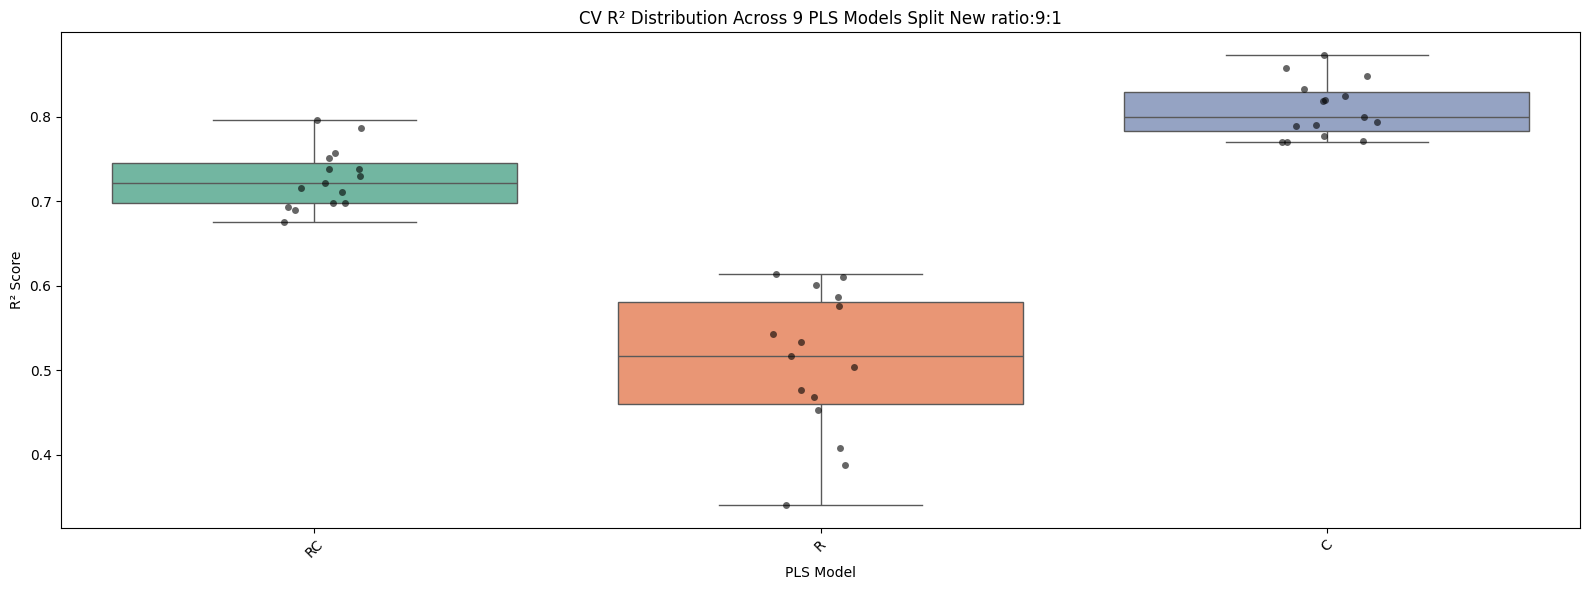

In [80]:
pls_results = {
    "RC": [0.7384823326473196, 0.7861559651647637, 0.6749109971285072, 0.7513242164089492, 0.6927771718430262, 0.6975647635179076, 0.7102903448687544, 0.7960268774023673, 0.6983463531338241, 0.720834518933858, 0.7570450691910321, 0.6900526661789779, 0.7301694370710045, 0.7383517472433251, 0.71564982667442],
    "R": [0.503653877471491, 0.5757928969452792, 0.40834646784873974, 0.517131219185247, 0.5422816638033113, 0.45287928465245164, 0.47665593545437257, 0.6136126230899832, 0.38739938165794585, 0.6008034670718457, 0.5862330497806937, 0.340158874580731, 0.6097078744074367, 0.5331402544757957, 0.46783022028466514],
    "C": [0.7712702727304298, 0.8330448020820078, 0.8575504918159761, 0.8183679391337342, 0.7897491793108784, 0.8199553007218978, 0.7770803041004699, 0.8483141565970743, 0.7704396472670266, 0.8001024110981281, 0.8731005020573543, 0.7893688692658936, 0.7936231945057011, 0.8245996561812622, 0.7696100100076229]
 

}

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------
# Convert dictionary → long-format DataFrame
# -----------------------------------------
df = pd.DataFrame(pls_results)
df_melted = df.melt(var_name="Model", value_name="R2")

# -----------------------------------------
# Plot: Individual boxplots for each model
# -----------------------------------------
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")
sns.stripplot(data=df_melted, x="Model", y="R2",
              color="black", alpha=0.6, jitter=True)

plt.title("CV R² Distribution Across 9 PLS Models Split New ratio:9:1")
plt.xlabel("PLS Model")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3251776/3704894623.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")


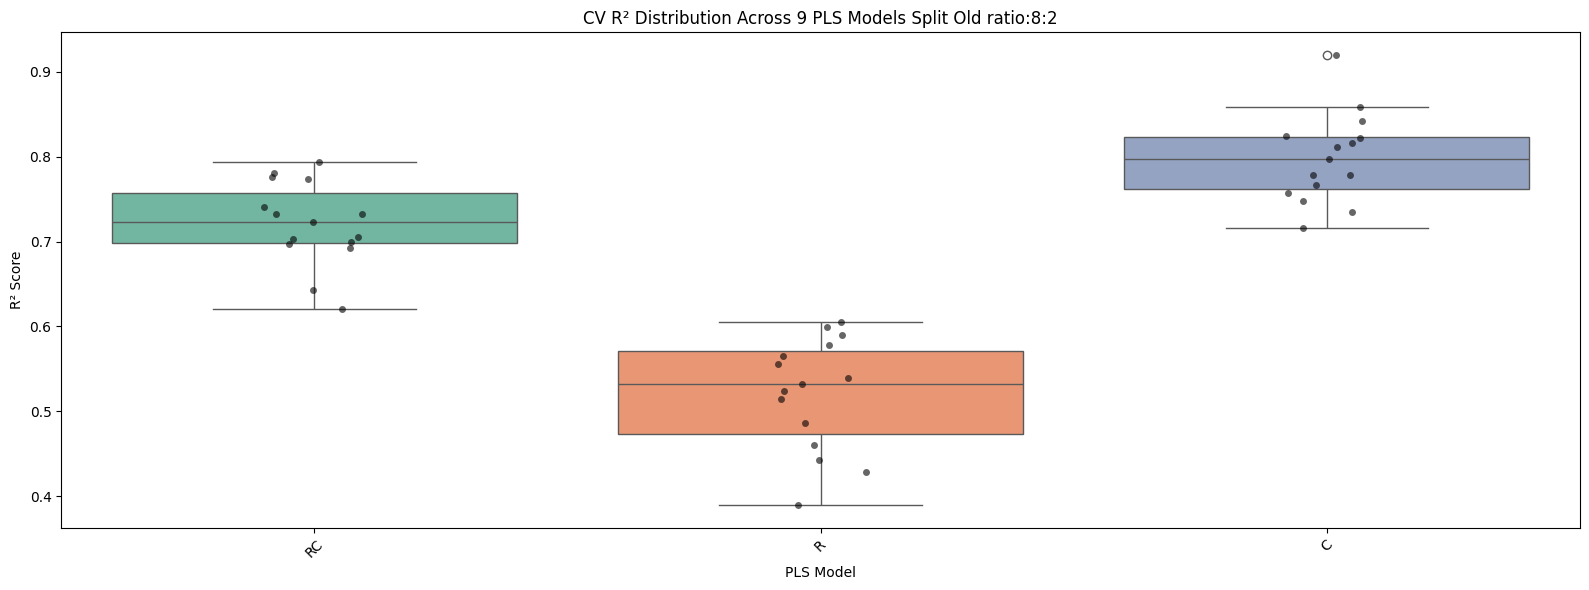

In [81]:
pls_results = {
    "RC": [0.7328226927345967, 0.6429690885063363, 0.702895920663567, 0.7931019031659812, 0.7328011924734728, 0.780278927070724, 0.6918950034808184, 0.6999825206707293, 0.7048669461343111, 0.7235800665430412, 0.7754470887774586, 0.6201913835189357, 0.6968743294577215, 0.7410646280841842, 0.7734699570819568]
 ,
    "R": [0.6057567089964762, 0.38960848228796996, 0.5649168283216667, 0.5396218308189067, 0.5143434776119225, 0.5999393551100586, 0.46078867984062377, 0.5243509356349979, 0.589966825034959, 0.442692073692997, 0.5318096004067081, 0.4290752528715678, 0.4862697833411942, 0.5557537448981615, 0.5784498671278662]
 ,
    "C": [0.7967048400540916, 0.7572739345901254, 0.8425035757136767, 0.8108712393722877, 0.7782035411499387, 0.9198475691727602, 0.778402430301431, 0.7163235169078392, 0.7661246348104919, 0.8159975225948654, 0.8241184896886595, 0.7476387469582056, 0.7343401986164928, 0.8586682123565419, 0.8220710332861383]
 
 

}

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------
# Convert dictionary → long-format DataFrame
# -----------------------------------------
df = pd.DataFrame(pls_results)
df_melted = df.melt(var_name="Model", value_name="R2")

# -----------------------------------------
# Plot: Individual boxplots for each model
# -----------------------------------------
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")
sns.stripplot(data=df_melted, x="Model", y="R2",
              color="black", alpha=0.6, jitter=True)

plt.title("CV R² Distribution Across 9 PLS Models Split Old ratio:8:2")
plt.xlabel("PLS Model")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3251776/71281992.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")


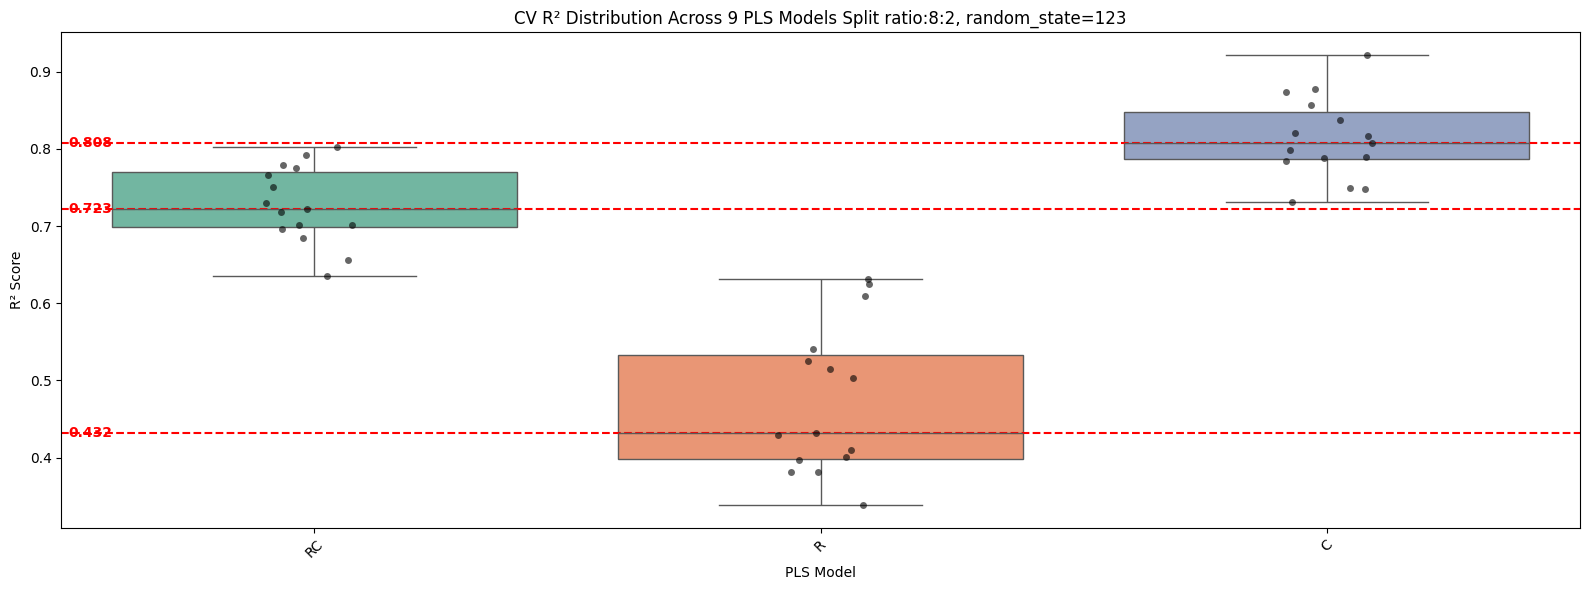

In [90]:
#8:2 seeds: 123
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pls_results = {
    "RC": [0.7303143071907406, 0.6966850951356961, 0.7500387780337964, 0.7755683579617109, 0.7226862490263659, 0.6851640501956259, 0.6564700690449682, 0.7791024282310088, 0.8028149929796986, 0.6354840252780457, 0.7920544277929203, 0.7655728278732438, 0.7188805620909225, 0.7013572091830417, 0.7017177719961502]

 ,
    "R": [0.6316281428584083, 0.4002978531393375, 0.6089158809576045, 0.39650913064271, 0.4096252292216632, 0.3814282865547113, 0.5149266818722937, 0.4291926480910738, 0.6245812365800795, 0.33838964952539263, 0.5246585588476376, 0.5034056071800836, 0.38148218517211585, 0.5409032086842012, 0.43192446663506934]
 ,
    "C": [0.8076242993743727, 0.7476147581602038, 0.8377351154620925, 0.8571062225354061, 0.7876610039284806, 0.7488264383905279, 0.7849608521689359, 0.9219043034042917, 0.8732308689793343, 0.7311591528015572, 0.7990505735595286, 0.8772600966805807, 0.8207548422225018, 0.7899992721928746, 0.8164306565215584]
 
}


# -----------------------------------------
# Convert dictionary → long-format DataFrame
# -----------------------------------------
df = pd.DataFrame(pls_results)
df_melted = df.melt(var_name="Model", value_name="R2")

# -----------------------------------------
# Plot: Individual boxplots for each model
# -----------------------------------------
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")
sns.stripplot(data=df_melted, x="Model", y="R2",
              color="black", alpha=0.6, jitter=True)

# -----------------------------------------
# Add full-width red horizontal lines at each model's median
# -----------------------------------------
medians = df_melted.groupby("Model")["R2"].median()

# Get x-axis tick positions
xticks = range(len(medians))

for i, model in enumerate(medians.index):
    median_value = medians[model]
    # Draw full-width horizontal line
    plt.axhline(y=median_value, color="red", linestyle="--", linewidth=1.5)

    # Optional: annotate median value
    plt.text(
        x=-0.4,  # left margin near Y-axis
        y=median_value,
        s=f"{median_value:.3f}",
        color="red",
        va="center",
        ha="right",
        fontsize=10,
        fontweight="bold"
    )

# -----------------------------------------
# Labels and formatting
# -----------------------------------------
plt.title("CV R² Distribution Across 9 PLS Models Split ratio:8:2, random_state=123")
plt.xlabel("PLS Model")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



/tmp/ipykernel_3251776/3180988284.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")


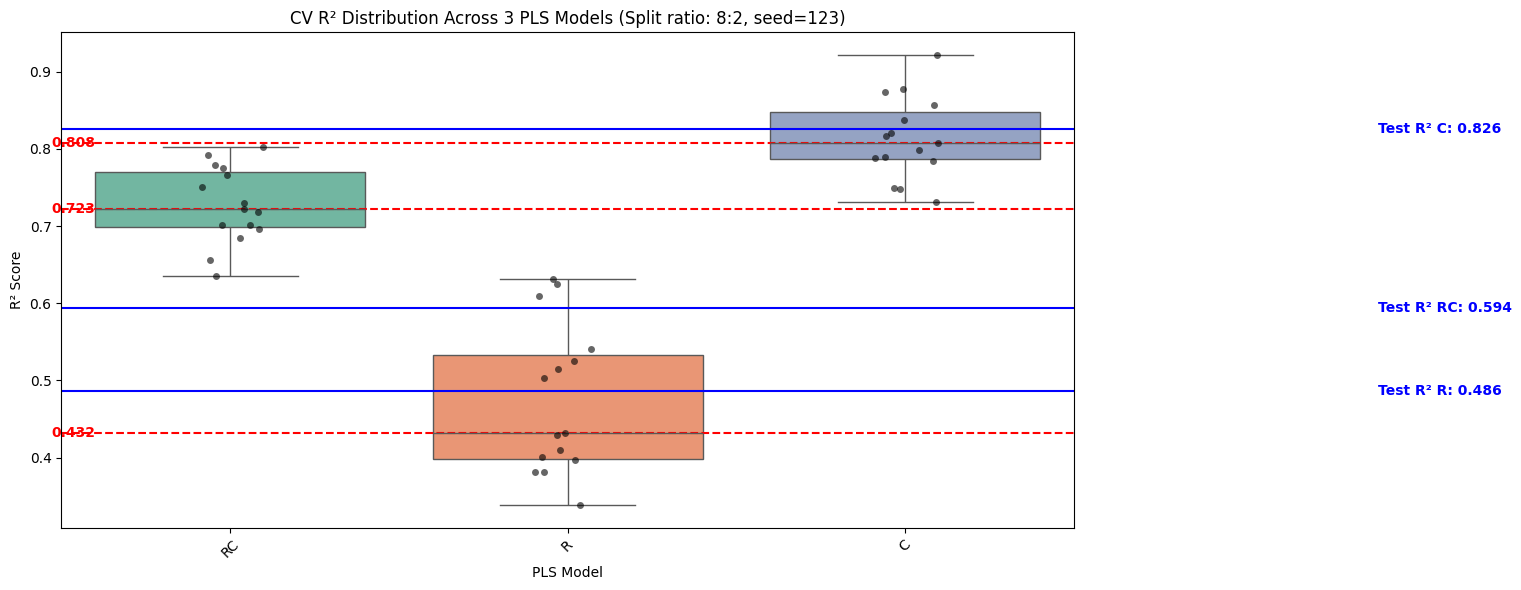

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------
# Your CV results
# -----------------------------------------
pls_results = {
    "RC": [0.7303143071907406, 0.6966850951356961, 0.7500387780337964, 0.7755683579617109, 0.7226862490263659, 0.6851640501956259, 0.6564700690449682, 0.7791024282310088, 0.8028149929796986, 0.6354840252780457, 0.7920544277929203, 0.7655728278732438, 0.7188805620909225, 0.7013572091830417, 0.7017177719961502],
    "R": [0.6316281428584083, 0.4002978531393375, 0.6089158809576045, 0.39650913064271, 0.4096252292216632, 0.3814282865547113, 0.5149266818722937, 0.4291926480910738, 0.6245812365800795, 0.33838964952539263, 0.5246585588476376, 0.5034056071800836, 0.38148218517211585, 0.5409032086842012, 0.43192446663506934],
    "C": [0.8076242993743727, 0.7476147581602038, 0.8377351154620925, 0.8571062225354061, 0.7876610039284806, 0.7488264383905279, 0.7849608521689359, 0.9219043034042917, 0.8732308689793343, 0.7311591528015572, 0.7990505735595286, 0.8772600966805807, 0.8207548422225018, 0.7899992721928746, 0.8164306565215584]
}

# -----------------------------------------
# Your test R² values
# -----------------------------------------
test_r2 = {
    "RC": 0.594,
    "R": 0.486,
    "C": 0.826
}

# -----------------------------------------
# Convert dictionary → long-format DataFrame
# -----------------------------------------
df = pd.DataFrame(pls_results)
df_melted = df.melt(var_name="Model", value_name="R2")

# -----------------------------------------
# Plot: Individual boxplots for each model
# -----------------------------------------
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")
sns.stripplot(data=df_melted, x="Model", y="R2", color="black", alpha=0.6, jitter=True)

# -----------------------------------------
# Add full-width red horizontal lines at each model's median
# -----------------------------------------
medians = df_melted.groupby("Model")["R2"].median()
for model, median_value in medians.items():
    plt.axhline(y=median_value, color="red", linestyle="--", linewidth=1.5)
    plt.text(
        x=-0.4,
        y=median_value,
        s=f"{median_value:.3f}",
        color="red",
        va="center",
        ha="right",
        fontsize=10,
        fontweight="bold"
    )

# -----------------------------------------
# Add full-width blue horizontal lines for test R²
# -----------------------------------------
for model, test_value in test_r2.items():
    plt.axhline(y=test_value, color="blue", linestyle="-", linewidth=1.5)
    plt.text(
        x=len(test_r2) + 0.4,
        y=test_value,
        s=f"Test R² {model}: {test_value:.3f}",
        color="blue",
        va="center",
        ha="left",
        fontsize=10,
        fontweight="bold"
    )

# -----------------------------------------
# Labels and formatting
# -----------------------------------------
plt.title("CV R² Distribution Across 3 PLS Models (Split ratio: 8:2, seed=123)")
plt.xlabel("PLS Model")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_3251776/2582349635.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")


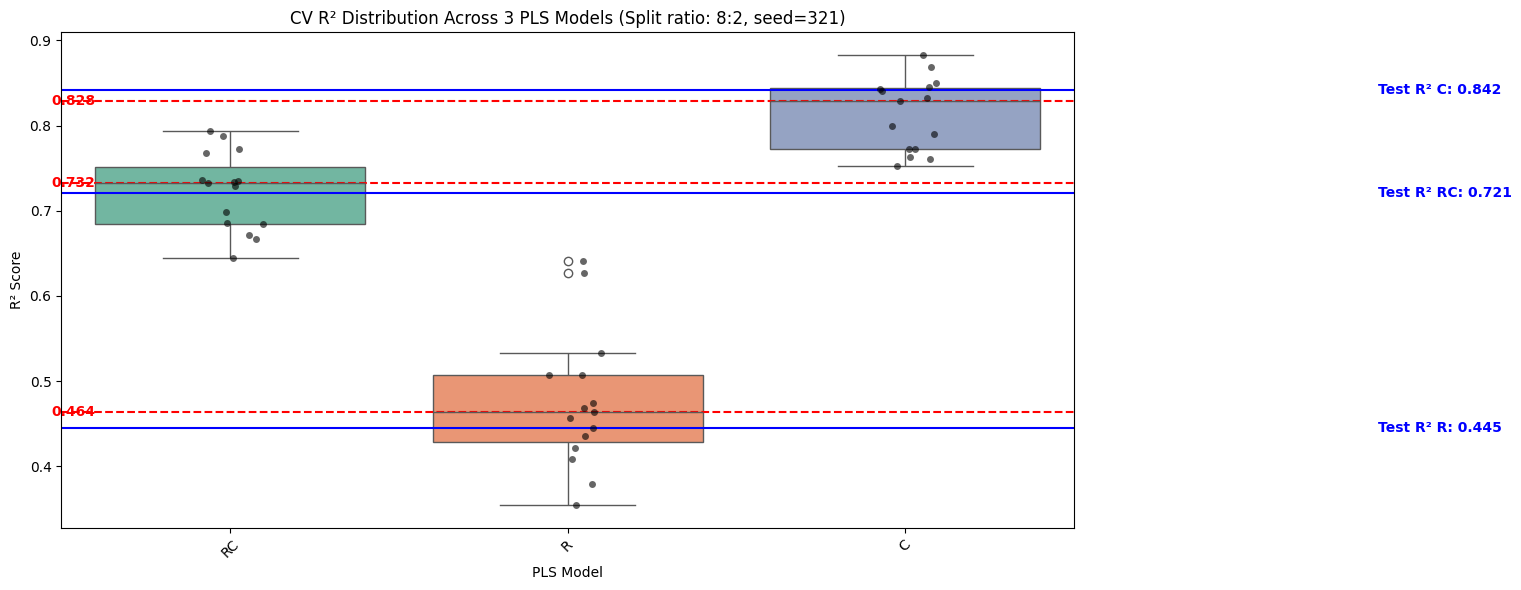

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------
# Your CV results
# -----------------------------------------
pls_results = {
    "RC": [0.7673137694144643, 0.7323393514522938, 0.7358619163594597, 0.6667247815827365, 0.7719945466605297, 0.7879763476252898, 0.6840108727056514, 0.6859848818124367, 0.7332799202572182, 0.6716839974514079, 0.6447502659508499, 0.6985061990063632, 0.7937615245707361, 0.729490909601297, 0.7355680377192864]

 ,
    "R":  [0.5325868825148816, 0.4641824927398355, 0.507376685828877, 0.3791686826116145, 0.4746438704764133, 0.5077605245991101, 0.44543708319815534, 0.436131100471593, 0.6416533215354554, 0.40868586823001296, 0.35448288670392036, 0.42105357465140547, 0.626833707726328, 0.45696683051467746, 0.4688892144717093]
 ,
    "C": [0.8329543779587496, 0.8691832126682931, 0.7629387600887125, 0.842560116164979, 0.761177988929106, 0.8830995060263614, 0.7997360557615877, 0.7728724073324457, 0.8283739841273036, 0.7730532073666389, 0.7530289077547243, 0.8449745883100874, 0.8408719355863772, 0.7896175810572441, 0.8500063017977728]
}

# -----------------------------------------
# Your test R² values
# -----------------------------------------
test_r2 = {
    "RC": 0.721,
    "R": 0.445,
    "C": 0.842
}

# -----------------------------------------
# Convert dictionary → long-format DataFrame
# -----------------------------------------
df = pd.DataFrame(pls_results)
df_melted = df.melt(var_name="Model", value_name="R2")

# -----------------------------------------
# Plot: Individual boxplots for each model
# -----------------------------------------
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")
sns.stripplot(data=df_melted, x="Model", y="R2", color="black", alpha=0.6, jitter=True)

# -----------------------------------------
# Add full-width red horizontal lines at each model's median
# -----------------------------------------
medians = df_melted.groupby("Model")["R2"].median()
for model, median_value in medians.items():
    plt.axhline(y=median_value, color="red", linestyle="--", linewidth=1.5)
    plt.text(
        x=-0.4,
        y=median_value,
        s=f"{median_value:.3f}",
        color="red",
        va="center",
        ha="right",
        fontsize=10,
        fontweight="bold"
    )

# -----------------------------------------
# Add full-width blue horizontal lines for test R²
# -----------------------------------------
for model, test_value in test_r2.items():
    plt.axhline(y=test_value, color="blue", linestyle="-", linewidth=1.5)
    plt.text(
        x=len(test_r2) + 0.4,
        y=test_value,
        s=f"Test R² {model}: {test_value:.3f}",
        color="blue",
        va="center",
        ha="left",
        fontsize=10,
        fontweight="bold"
    )

# -----------------------------------------
# Labels and formatting
# -----------------------------------------
plt.title("CV R² Distribution Across 3 PLS Models (Split ratio: 8:2, seed=321)")
plt.xlabel("PLS Model")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_3251776/3755384442.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")


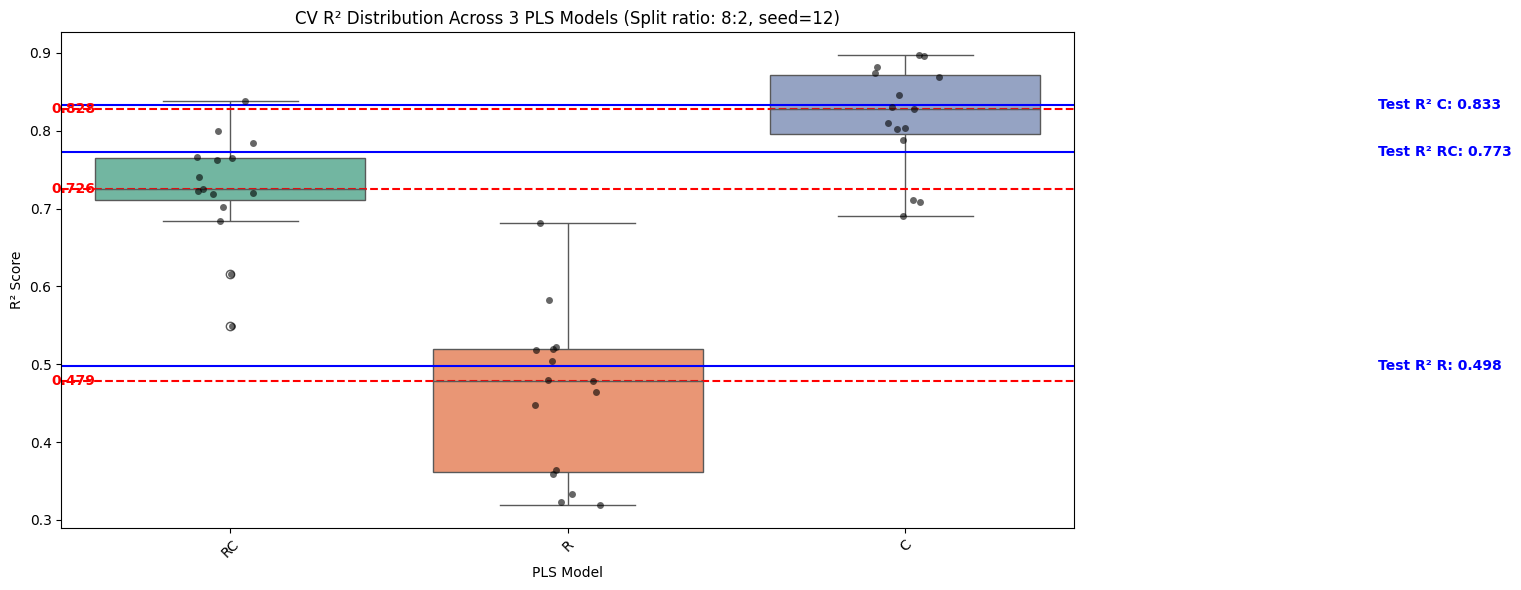

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------
# Your CV results
# -----------------------------------------
pls_results = {
    "RC": [0.6835913754737097, 0.7644439555201045, 0.7994215067297041, 0.7023557962161864, 0.7188748964279441, 0.7400232195261794, 0.5493697606637571, 0.7255948561005381, 0.7203511955649393, 0.8385717367283112, 0.6153994878053416, 0.765840930840966, 0.7835979374262938, 0.7628447037608368, 0.7230571314497944]

 ,
    "R":  [0.31899162677459314, 0.5199810839490224, 0.5038073660596575, 0.5179670099099437, 0.478530001605484, 0.3587393026530067, 0.3231300109842187, 0.44721726198235867, 0.3647003946756445, 0.6809439461459792, 0.33342641687445795, 0.5227053875272519, 0.5823254136535505, 0.48021484153945093, 0.4638963876310287]
 ,
    "C": [0.7111921331411379, 0.8028441217185407, 0.8963727673302646, 0.8027409077548001, 0.8463432554080715, 0.8097537527111921, 0.7881258104014685, 0.7084304854892687, 0.8973565830724464, 0.8814898688527045, 0.6899980314674787, 0.8743194103907302, 0.8283437912656578, 0.868905455084798, 0.8309179800116457]
}

# -----------------------------------------
# Your test R² values
# -----------------------------------------
test_r2 = {
    "RC": 0.773,
    "R": 0.498,
    "C": 0.833
}

# -----------------------------------------
# Convert dictionary → long-format DataFrame
# -----------------------------------------
df = pd.DataFrame(pls_results)
df_melted = df.melt(var_name="Model", value_name="R2")

# -----------------------------------------
# Plot: Individual boxplots for each model
# -----------------------------------------
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")
sns.stripplot(data=df_melted, x="Model", y="R2", color="black", alpha=0.6, jitter=True)

# -----------------------------------------
# Add full-width red horizontal lines at each model's median
# -----------------------------------------
medians = df_melted.groupby("Model")["R2"].median()
for model, median_value in medians.items():
    plt.axhline(y=median_value, color="red", linestyle="--", linewidth=1.5)
    plt.text(
        x=-0.4,
        y=median_value,
        s=f"{median_value:.3f}",
        color="red",
        va="center",
        ha="right",
        fontsize=10,
        fontweight="bold"
    )

# -----------------------------------------
# Add full-width blue horizontal lines for test R²
# -----------------------------------------
for model, test_value in test_r2.items():
    plt.axhline(y=test_value, color="blue", linestyle="-", linewidth=1.5)
    plt.text(
        x=len(test_r2) + 0.4,
        y=test_value,
        s=f"Test R² {model}: {test_value:.3f}",
        color="blue",
        va="center",
        ha="left",
        fontsize=10,
        fontweight="bold"
    )

# -----------------------------------------
# Labels and formatting
# -----------------------------------------
plt.title("CV R² Distribution Across 3 PLS Models (Split ratio: 8:2, seed=12)")
plt.xlabel("PLS Model")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_3251776/2912110270.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")


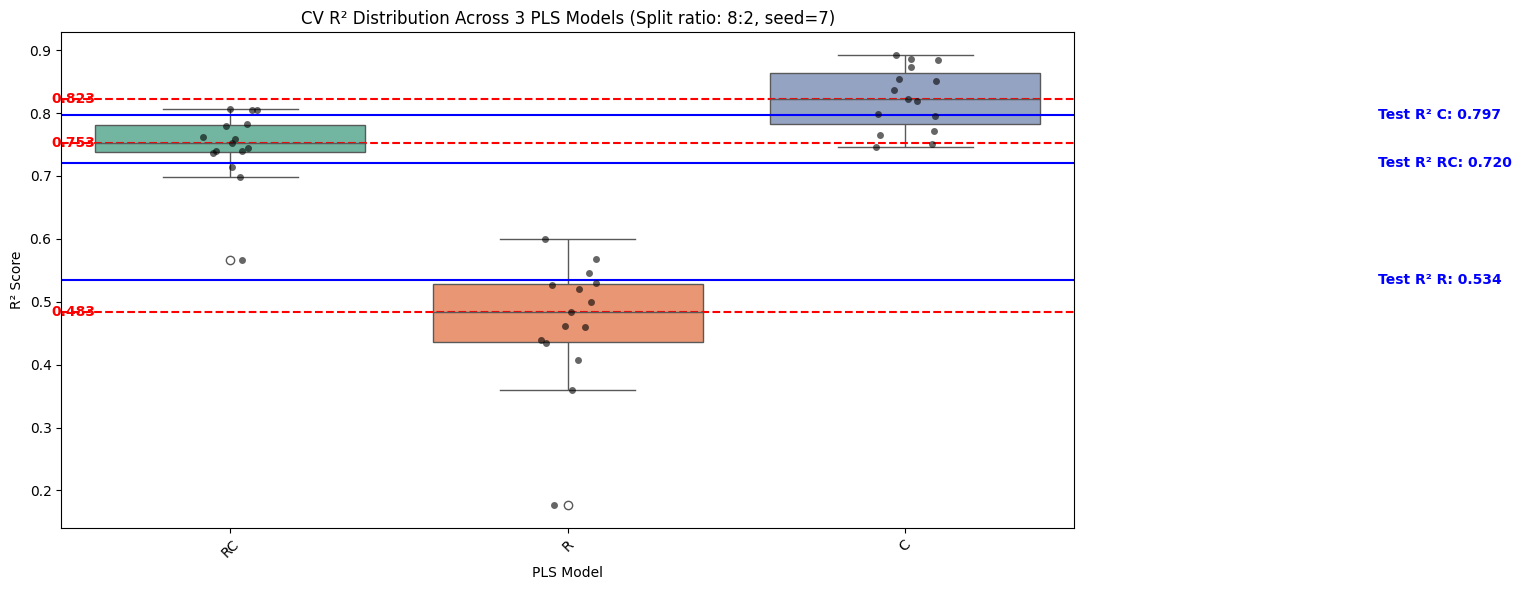

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------
# Your CV results
# -----------------------------------------
pls_results = {
    "RC": [0.8049879456727073, 0.6989279625772917, 0.7358860297526617, 0.7134332276057176, 0.7527866987183598, 0.7584721601504656, 0.7623165033057595, 0.7826871958127372, 0.7396879116263693, 0.8057532535745187, 0.7437921288733222, 0.7389201947529398, 0.7798180597223758, 0.5666184453524825, 0.8049273282865639]
 

 ,
    "R":  [0.5680954366162954, 0.1766335284555074, 0.5304596637032096, 0.5194763103314725, 0.5270074444066257, 0.3590140666025967, 0.45969564384580464, 0.5995501071515732, 0.5001999620649583, 0.46098267439771534, 0.4383573253099965, 0.4833355604816538, 0.5459205469463655, 0.4348091411456504, 0.4066388530824424]
 
 ,
    "C": [0.892448992958591, 0.8737750964952704, 0.7717422445949381, 0.8195502682235949, 0.7646420337569126, 0.8857251080422672, 0.8506790873809567, 0.7986853877444239, 0.7452071200983277, 0.8369879421018233, 0.8227147094655822, 0.8848671648522272, 0.7946747719734342, 0.7506932852903667, 0.8540847100381174]
}

# -----------------------------------------
# Your test R² values
# -----------------------------------------
test_r2 = {
    "RC": 0.720,
    "R": 0.534,
    "C": 0.797
}

# -----------------------------------------
# Convert dictionary → long-format DataFrame
# -----------------------------------------
df = pd.DataFrame(pls_results)
df_melted = df.melt(var_name="Model", value_name="R2")

# -----------------------------------------
# Plot: Individual boxplots for each model
# -----------------------------------------
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")
sns.stripplot(data=df_melted, x="Model", y="R2", color="black", alpha=0.6, jitter=True)

# -----------------------------------------
# Add full-width red horizontal lines at each model's median
# -----------------------------------------
medians = df_melted.groupby("Model")["R2"].median()
for model, median_value in medians.items():
    plt.axhline(y=median_value, color="red", linestyle="--", linewidth=1.5)
    plt.text(
        x=-0.4,
        y=median_value,
        s=f"{median_value:.3f}",
        color="red",
        va="center",
        ha="right",
        fontsize=10,
        fontweight="bold"
    )

# -----------------------------------------
# Add full-width blue horizontal lines for test R²
# -----------------------------------------
for model, test_value in test_r2.items():
    plt.axhline(y=test_value, color="blue", linestyle="-", linewidth=1.5)
    plt.text(
        x=len(test_r2) + 0.4,
        y=test_value,
        s=f"Test R² {model}: {test_value:.3f}",
        color="blue",
        va="center",
        ha="left",
        fontsize=10,
        fontweight="bold"
    )

# -----------------------------------------
# Labels and formatting
# -----------------------------------------
plt.title("CV R² Distribution Across 3 PLS Models (Split ratio: 8:2, seed=7)")
plt.xlabel("PLS Model")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_3251776/1638146391.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")


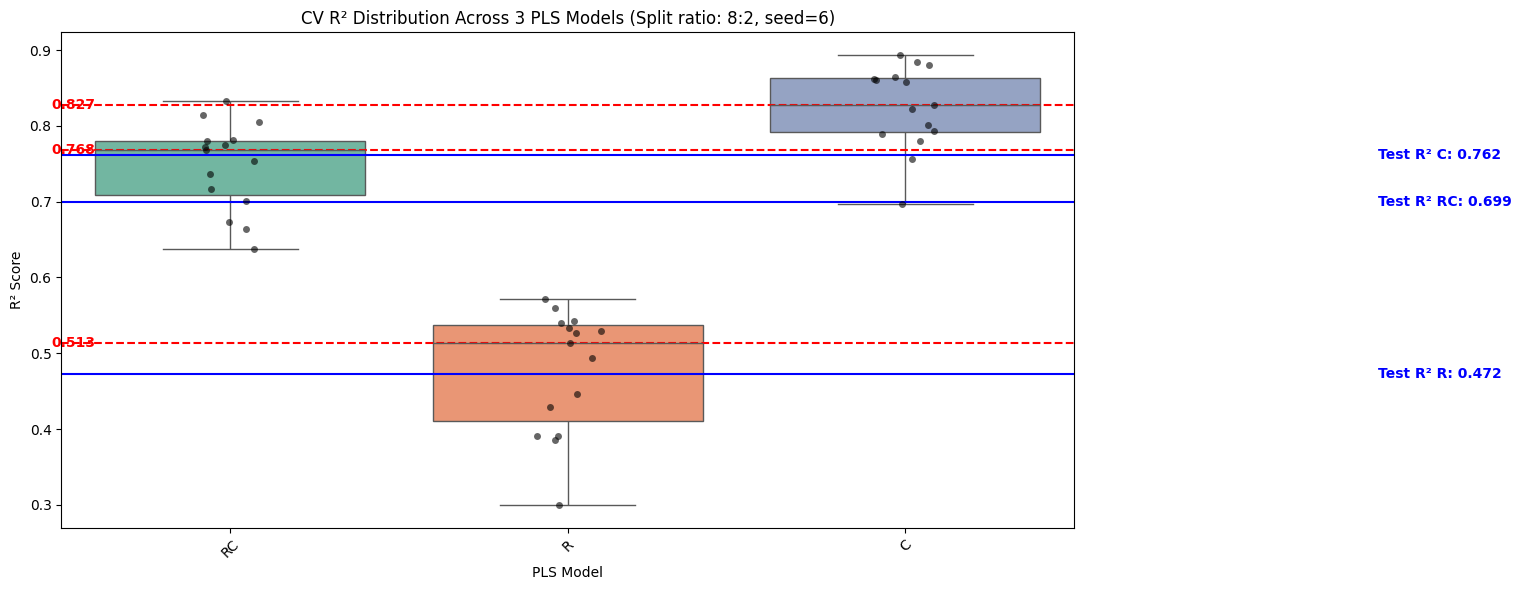

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------
# Your CV results
# -----------------------------------------
pls_results = {
    "RC": [0.8141125460979757, 0.7370032784268953, 0.7811039603420783, 0.6724630569261136, 0.7529773242841282, 0.7796477478059798, 0.7168797929614033, 0.8325806977162429, 0.7752664639907209, 0.6369860118398869, 0.7719187653868667, 0.7005188750990612, 0.7682883020672403, 0.6644059630579942, 0.805078444801854]
 ,
    "R":  [0.5333316092987395, 0.42953913253764897, 0.5708558406559296, 0.3852994070290022, 0.4462216877987373, 0.49412265418793544, 0.3912924050179978, 0.5128153505008526, 0.5269966917941961, 0.5293508701394762, 0.559163714044838, 0.2995522877645702, 0.5404769127297162, 0.3908482435642221, 0.5427564590984756]

 ,
    "C": [0.8799326064534928, 0.8621521106784358, 0.8013241769015291, 0.75558506693359, 0.8582860021794849, 0.864370247789419, 0.7797737914737979, 0.8936264122856229, 0.8610231220006465, 0.6968146201595552, 0.8268802334573719, 0.7938070426755668, 0.8215814462501869, 0.7892554379793429, 0.8845411020008371]
}

# -----------------------------------------
# Your test R² values
# -----------------------------------------
test_r2 = {
    "RC": 0.699,
    "R": 0.472,
    "C": 0.762
}

# -----------------------------------------
# Convert dictionary → long-format DataFrame
# -----------------------------------------
df = pd.DataFrame(pls_results)
df_melted = df.melt(var_name="Model", value_name="R2")

# -----------------------------------------
# Plot: Individual boxplots for each model
# -----------------------------------------
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")
sns.stripplot(data=df_melted, x="Model", y="R2", color="black", alpha=0.6, jitter=True)

# -----------------------------------------
# Add full-width red horizontal lines at each model's median
# -----------------------------------------
medians = df_melted.groupby("Model")["R2"].median()
for model, median_value in medians.items():
    plt.axhline(y=median_value, color="red", linestyle="--", linewidth=1.5)
    plt.text(
        x=-0.4,
        y=median_value,
        s=f"{median_value:.3f}",
        color="red",
        va="center",
        ha="right",
        fontsize=10,
        fontweight="bold"
    )

# -----------------------------------------
# Add full-width blue horizontal lines for test R²
# -----------------------------------------
for model, test_value in test_r2.items():
    plt.axhline(y=test_value, color="blue", linestyle="-", linewidth=1.5)
    plt.text(
        x=len(test_r2) + 0.4,
        y=test_value,
        s=f"Test R² {model}: {test_value:.3f}",
        color="blue",
        va="center",
        ha="left",
        fontsize=10,
        fontweight="bold"
    )

# -----------------------------------------
# Labels and formatting
# -----------------------------------------
plt.title("CV R² Distribution Across 3 PLS Models (Split ratio: 8:2, seed=6)")
plt.xlabel("PLS Model")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_1493237/3841765120.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")


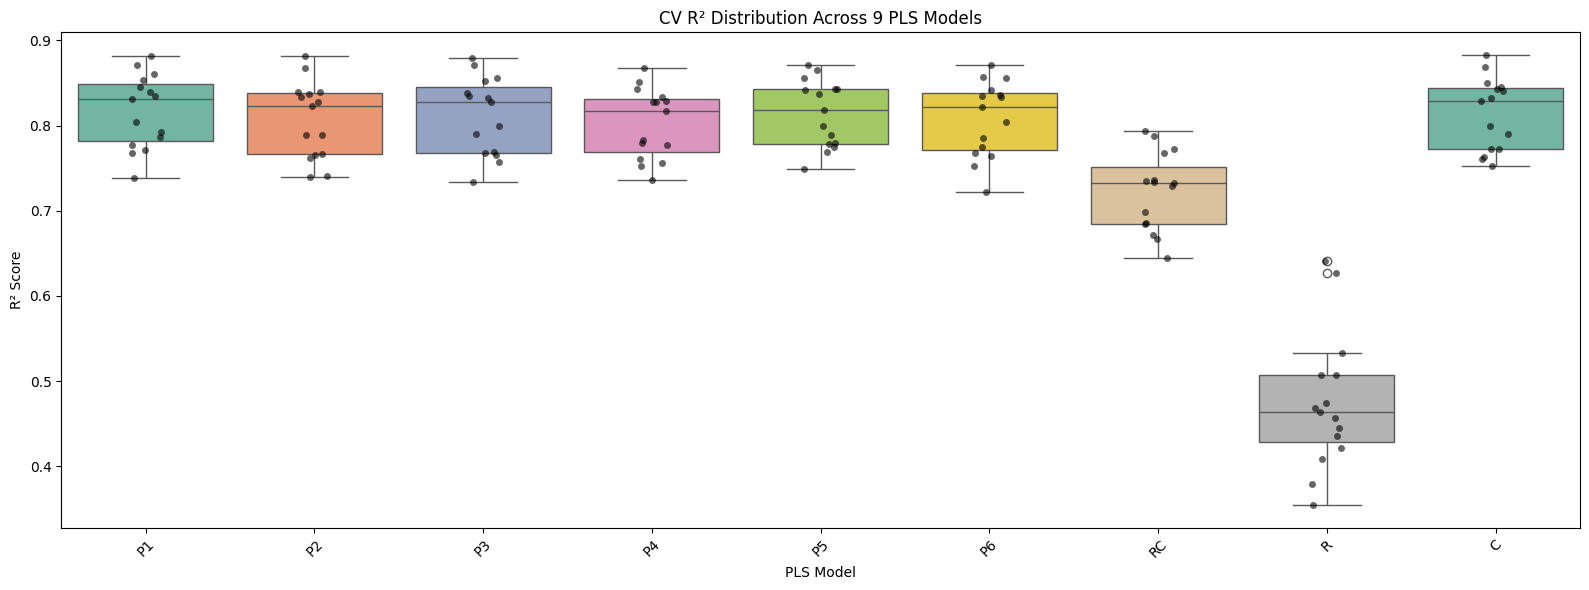

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------
# Your CV results
# -----------------------------------------
pls_results = {

"P1":[0.8352037256238952, 0.8708200666461621, 0.7769128795145175, 0.8313917030271224, 0.7676297024681716, 0.8821093490138344, 0.8037231776448044, 0.786702371063218, 0.839339088070159, 0.7718750805482891, 0.738377481479717, 0.8536007832632458, 0.8601125000750863, 0.7923087739214301, 0.8452792210541807],
"P2": [0.8274819373715318, 0.8673738860837186, 0.7668889560861457, 0.8373776537793877, 0.7412298939431619, 0.8814932924262635, 0.7887613124674238, 0.7655373116475505, 0.8332568133354521, 0.7622175164280897, 0.7398885088665689, 0.8225465615741542, 0.8392922300440597, 0.7890016532782071, 0.8392079051100023],
"P3": [0.8279958331697725, 0.8709590428799241, 0.765640530698324, 0.8348981754782596, 0.757500198995464, 0.8798866435659535, 0.7999812042783225, 0.7674711299577478, 0.8326616808387662, 0.7693289813421009, 0.7341146635841875, 0.8387660225076785, 0.8556961789901274, 0.7900479218033208, 0.8524058216352477],
"P4": [0.82876993383032, 0.8507374307160647, 0.7526609289959982, 0.833746292123658, 0.7566034292575639, 0.8672266329738175, 0.78002070332168, 0.7770625058252015, 0.8277990129069718, 0.7608445593242271, 0.7361405426376186, 0.8175859645213817, 0.8429219050005257, 0.7827812133325485, 0.8280602009158882],
"P5": [0.818816044751691, 0.8653027843021781, 0.7695791727832102, 0.8420648553488851, 0.7749109200990039, 0.8712127350219773, 0.7992319428861241, 0.7785795727681983, 0.8373009337269413, 0.7790718231377065, 0.7485247940481754, 0.843360654525289, 0.8555374897703907, 0.7890653095175484, 0.8434468821323229],
"P6": [0.8214229021835281, 0.8561877090858634, 0.7746545028996589, 0.8351897713304148, 0.7641287785385418, 0.8710441228205573, 0.8040115884933446, 0.7678158894192271, 0.8357694674658844, 0.7521236569951941, 0.722056722420249, 0.833266748744491, 0.8576582004811497, 0.7860560853373338, 0.8417047333435058],
"RC": [0.7673137694144643, 0.7323393514522938, 0.7358619163594597, 0.6667247815827365, 0.7719945466605297, 0.7879763476252898, 0.6840108727056514, 0.6859848818124367, 0.7332799202572182, 0.6716839974514079, 0.6447502659508499, 0.6985061990063632, 0.7937615245707361, 0.729490909601297, 0.7355680377192864],
"R": [0.5325868825148816, 0.4641824927398355, 0.507376685828877, 0.3791686826116145, 0.4746438704764133, 0.5077605245991101, 0.44543708319815534, 0.436131100471593, 0.6416533215354554, 0.40868586823001296, 0.35448288670392036, 0.42105357465140547, 0.626833707726328, 0.45696683051467746, 0.4688892144717093],
"C": [0.8329543779587496, 0.8691832126682931, 0.7629387600887125, 0.842560116164979, 0.761177988929106, 0.8830995060263614, 0.7997360557615877, 0.7728724073324457, 0.8283739841273036, 0.7730532073666389, 0.7530289077547243, 0.8449745883100874, 0.8408719355863772, 0.7896175810572441, 0.8500063017977728]
}

# -----------------------------------------
# Your test R² values
# -----------------------------------------
test_r2 = {

"P1":   0.834,
"P2":   0.820,
"P3":   0.843,
"P4": 0.816,
"P5": 0.839,
"P6":  0.838,
"RC": 0.721,
"R": 0.445,
"C":0.842,
}

# -----------------------------------------
# Convert dictionary → long-format DataFrame
# -----------------------------------------
df = pd.DataFrame(pls_results)
df_melted = df.melt(var_name="Model", value_name="R2")

# -----------------------------------------
# Plot: Individual boxplots for each model
# -----------------------------------------
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_melted, x="Model", y="R2", palette="Set2")
sns.stripplot(data=df_melted, x="Model", y="R2", color="black", alpha=0.6, jitter=True)

# # -----------------------------------------
# # Add full-width red horizontal lines at each model's median
# # -----------------------------------------
# medians = df_melted.groupby("Model")["R2"].median()
# for model, median_value in medians.items():
#     plt.axhline(y=median_value, color="red", linestyle="--", linewidth=1.5)
#     plt.text(
#         x=-0.4,
#         y=median_value,
#         s=f"{median_value:.3f}",
#         color="red",
#         va="center",
#         ha="right",
#         fontsize=10,
#         fontweight="bold"
#     )

# -----------------------------------------
# Add full-width blue horizontal lines for test R²
# -----------------------------------------
# for model, test_value in test_r2.items():
#     plt.axhline(y=test_value, color="blue", linestyle="--", linewidth=1.5)
#     plt.text(
#         x=len(test_r2) + 0.4,
#         y=test_value,
#         s=f"Test R² {model}: {test_value:.3f}",
#         color="blue",
#         va="center",
#         ha="left",
#         fontsize=10,
#         fontweight="bold"
#     )

# -----------------------------------------
# Labels and formatting
# -----------------------------------------
plt.title("CV R² Distribution Across 9 PLS Models")
plt.xlabel("PLS Model")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [1]:
import numpy as np

pls_results = {

"P1":[0.8352037256238952, 0.8708200666461621, 0.7769128795145175, 0.8313917030271224, 0.7676297024681716, 0.8821093490138344, 0.8037231776448044, 0.786702371063218, 0.839339088070159, 0.7718750805482891, 0.738377481479717, 0.8536007832632458, 0.8601125000750863, 0.7923087739214301, 0.8452792210541807],
"P2": [0.8274819373715318, 0.8673738860837186, 0.7668889560861457, 0.8373776537793877, 0.7412298939431619, 0.8814932924262635, 0.7887613124674238, 0.7655373116475505, 0.8332568133354521, 0.7622175164280897, 0.7398885088665689, 0.8225465615741542, 0.8392922300440597, 0.7890016532782071, 0.8392079051100023],
"P3": [0.8279958331697725, 0.8709590428799241, 0.765640530698324, 0.8348981754782596, 0.757500198995464, 0.8798866435659535, 0.7999812042783225, 0.7674711299577478, 0.8326616808387662, 0.7693289813421009, 0.7341146635841875, 0.8387660225076785, 0.8556961789901274, 0.7900479218033208, 0.8524058216352477],
"P4": [0.82876993383032, 0.8507374307160647, 0.7526609289959982, 0.833746292123658, 0.7566034292575639, 0.8672266329738175, 0.78002070332168, 0.7770625058252015, 0.8277990129069718, 0.7608445593242271, 0.7361405426376186, 0.8175859645213817, 0.8429219050005257, 0.7827812133325485, 0.8280602009158882],
"P5": [0.818816044751691, 0.8653027843021781, 0.7695791727832102, 0.8420648553488851, 0.7749109200990039, 0.8712127350219773, 0.7992319428861241, 0.7785795727681983, 0.8373009337269413, 0.7790718231377065, 0.7485247940481754, 0.843360654525289, 0.8555374897703907, 0.7890653095175484, 0.8434468821323229],
"P6": [0.8214229021835281, 0.8561877090858634, 0.7746545028996589, 0.8351897713304148, 0.7641287785385418, 0.8710441228205573, 0.8040115884933446, 0.7678158894192271, 0.8357694674658844, 0.7521236569951941, 0.722056722420249, 0.833266748744491, 0.8576582004811497, 0.7860560853373338, 0.8417047333435058],
"RC": [0.7673137694144643, 0.7323393514522938, 0.7358619163594597, 0.6667247815827365, 0.7719945466605297, 0.7879763476252898, 0.6840108727056514, 0.6859848818124367, 0.7332799202572182, 0.6716839974514079, 0.6447502659508499, 0.6985061990063632, 0.7937615245707361, 0.729490909601297, 0.7355680377192864],
"R": [0.5325868825148816, 0.4641824927398355, 0.507376685828877, 0.3791686826116145, 0.4746438704764133, 0.5077605245991101, 0.44543708319815534, 0.436131100471593, 0.6416533215354554, 0.40868586823001296, 0.35448288670392036, 0.42105357465140547, 0.626833707726328, 0.45696683051467746, 0.4688892144717093],
"C": [0.8329543779587496, 0.8691832126682931, 0.7629387600887125, 0.842560116164979, 0.761177988929106, 0.8830995060263614, 0.7997360557615877, 0.7728724073324457, 0.8283739841273036, 0.7730532073666389, 0.7530289077547243, 0.8449745883100874, 0.8408719355863772, 0.7896175810572441, 0.8500063017977728]
}

results = {}

for key, values in pls_results.items():
    arr = np.array(values)
    median = np.median(arr)
    mean = np.mean(arr)
    std = np.std(arr, ddof=1)  # sample standard deviation
    results[key] = (
        # round(median, 3),
        round(mean, 3),
        round(std, 3)
    )

results


print(results)

{'P1': (0.817, 0.043), 'P2': (0.807, 0.045), 'P3': (0.812, 0.046), 'P4': (0.803, 0.041), 'P5': (0.814, 0.039), 'P6': (0.808, 0.045), 'RC': (0.723, 0.046), 'R': (0.475, 0.08), 'C': (0.814, 0.043)}
